Milestone I

Short and Long-Term Asset Performance Analysis: A Cross-Market Study of FAANG, Cryptocurrencie, Traditional Safe Havens and the Inflation Impact

Students:
Alan Mossinger,
Chris Zhang

Mentor: Erik Lang



Executive Summary: Financial Analysis Code Review

The study conducted a detailed analysis of multiple asset classes including FAANG stocks, cryptocurrencies (Bitcoin), traditional market indices (S&P 500), and gold from 2005 to 2024. The research employed various portfolio combinations and analytical tools to understand performance, risk metrics, and inflation impacts.
Key Findings:

Portfolio Performance:

The FAANG portfolio showed the highest average daily return (0.1234%) with a total return of 3,063%
Adding Bitcoin to the diversified portfolio (FAANG + Gold + S&P 500) increased total returns to 3,451.85%
The Inflation Focus Portfolio demonstrated more modest returns (543.19%) but with potentially better inflation protection

Risk Metrics:

Pure FAANG portfolio showed highest volatility (Daily Return Std Dev: 2.1920%)
Adding Gold and S&P 500 reduced volatility (Std Dev down to 1.8552%)
Further Bitcoin addition slightly reduced volatility (1.7777%)

Portfolio Diversification Effects:

Gold and S&P 500 inclusion provided risk reduction benefits
Bitcoin addition improved returns but with increased volatility spikes
The Inflation Focus Portfolio showed different risk-return characteristics

Key Findings

1. Performance Analysis

Highest Average Return: Netflix (554.33%) over the period.

Lowest Average Return: S&P 500 (3.96x growth), indicating long-term stability.

Most Volatile Asset: Bitcoin (Annualized Volatility 57.46%), making it high-risk.

Most Stable Asset: Gold (Annualized Volatility 17.67%), ideal for risk-averse investors.

2. Risk & Return Metrics

Best Risk-Adjusted Return: Apple (Sharpe Ratio: 0.8560), highest among assets.

Worst Risk-Adjusted Return: S&P 500 (Sharpe Ratio: 0.2523), reflecting lower excess returns.

Highest Drawdown: Bitcoin (Max Drawdown: -83.4%), showing extreme downside risk.

Lowest Drawdown: Gold (Max Drawdown: -44.36%), reinforcing its hedge status.

3. Inflation Correlation Insights

Bitcoin shows the highest correlation with inflation (0.49), indicating it may act as an inflation hedge.

Gold exhibits a weak correlation with inflation (0.21), contrary to popular belief.

FAANG stocks maintain moderate correlation (~0.36-0.46), implying resilience during inflationary periods.

4. Decision Recommendations

For High Growth: Invest in Netflix, Apple, or Bitcoin for long-term capital appreciation.

For Stability: Gold and S&P 500 are the best options for conservative portfolios.

For Risk Management: Avoid Bitcoin unless risk tolerance is high due to its extreme volatility and drawdowns.

For Inflation Hedging: Bitcoin appears to be the most responsive to inflation trends.

5. Prediction Capabilities

ARIMA Model

Integrate macroeconomic factors (interest rates, GDP) for a holistic analysis.

Conclusion

The financial analysis code provides valuable insights into asset performance and risk-return dynamics. The findings suggest Netflix, Bitcoin, and Apple offer the highest returns, while Gold and S&P 500 provide the best stability.

Next Steps

Optimize data processing for efficiency.

Refine financial assumptions for accuracy.

Expand predictive modeling to anticipate market movements.

These enhancements will improve decision-making for investors, portfolio managers, and financial analysts.

Areas for Improvement

1. Performance Optimization

2. Replace loops with vectorized pandas operations for faster processing.

3. Integrate macroeconomic factors (interest rates, GDP) for a holistic analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.dates import YearLocator, DateFormatter
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import os

In [2]:
# Define the directory for datasets
DATASET_DIR = r"./datasets"

# Create directory if it doesn't exist
os.makedirs(DATASET_DIR, exist_ok=True)

# Define the date range to be analyzed
START_DATE = '2004-12-01'
END_DATE = '2024-12-31'

# Helper function to convert date formats
def convert_date_format(date, to_monthly=False):
    if to_monthly:
        return pd.to_datetime(date).strftime('%Y-%m')
    return pd.to_datetime(date).strftime('%Y-%m-%d')

# Fetch and save stock data
def fetch_and_save_stock_data(ticker):
    """
    Fetches stock data and saves it with the required column names
    """
    # Download data
    data = yf.download(ticker, start=START_DATE, end=END_DATE)

    # Reset index to get Date as a column
    data = data.reset_index()

    # Rename 'Date' to 'Price' for consistency with existing files
    data = data.rename(columns={'Date': 'Price'})

    # Reorder columns
    data = data[['Price', 'Close', 'High', 'Low', 'Open', 'Volume']]

    # Save in raw format
    filepath = os.path.join(DATASET_DIR, f"{ticker.replace('^', '').replace('=', '_')}_data.csv")
    data.to_csv(filepath, index=False)
    return data

# export the cpi data as a pd.DataFrame
def get_cpi_data(start_date, end_date):
    file_path = os.path.join(DATASET_DIR, 'cpi_inflation_data.xlsx')
    cpi_df = pd.read_excel(file_path)
    
    start_year = pd.to_datetime(start_date).year
    end_year = pd.to_datetime(end_date).year
    
    start_month = pd.to_datetime(start_date).month - 1
    end_month = pd.to_datetime(end_date).month - 1
    
    # Start cleaning the dataframe
    
    cpi_df.drop(columns=["HALF1", "HALF2"], inplace=True)
    
    # Replace the "Month" column with 0-indexed month indices
    melted_inflation = cpi_df.melt(
            id_vars=["Year"],
            value_vars=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
            value_name="CPI"
        )
    month_to_index = {
        "Jan": 0, "Feb": 1, "Mar": 2, "Apr": 3,
        "May": 4, "Jun": 5, "Jul": 6, "Aug": 7,
        "Sep": 8, "Oct": 9, "Nov": 10, "Dec": 11
    }
    melted_inflation["month_idx"] = melted_inflation["variable"].map(month_to_index)
    
    # Calculate Year-over-Year Inflation
    melted_inflation["YoY_Inflation"] = melted_inflation["CPI"].pct_change(periods=1) * 100
    
    # sort the data by year and month
    melted_inflation.sort_values(by=["Year", "month_idx"], inplace=True)
    
    # calculate monthly inflation rate
    melted_inflation["MoM_Inflation"] = melted_inflation["CPI"].pct_change() * 100
    
    # Filter the data based on the date range
    melted_inflation = melted_inflation[
        (melted_inflation["Year"] >= start_year) & (melted_inflation["Year"] <= end_year)
    ]
    melted_inflation = melted_inflation[~((melted_inflation["Year"] == start_year) & (melted_inflation["month_idx"] < start_month))]
    melted_inflation = melted_inflation[~((melted_inflation["Year"] == end_year) & (melted_inflation["month_idx"] > end_month))]
    
    # Create a new date column
    melted_inflation["Month"] = melted_inflation["Year"].astype(str) + "-" + (melted_inflation["month_idx"] + 1).astype(str).str.zfill(2)
    melted_inflation["Date"] = pd.to_datetime(melted_inflation["Month"])
    
    return melted_inflation

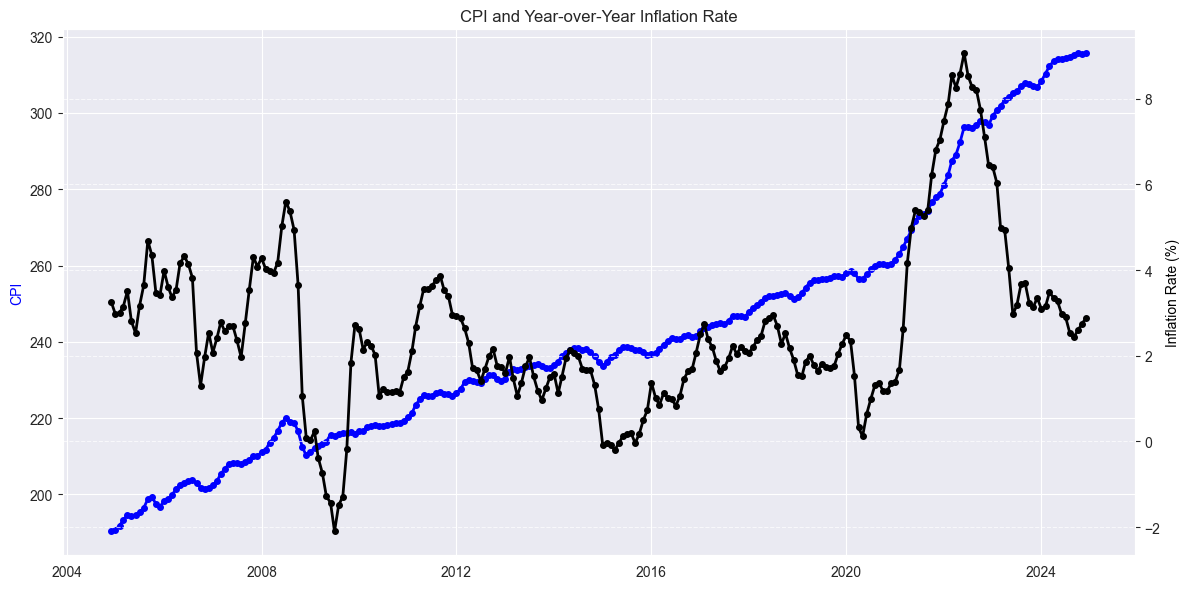

In [3]:
# Fetch, save, clean, and plot inflation rate data and CPI data
def plot_inflation_and_cpi(start_date, end_date):
    df = get_cpi_data(start_date, end_date)

    # Create plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    # Plot CPI
    ax1.plot(df['Date'], df['CPI'], marker='o', color='blue',
             linewidth=2, markersize=4, label='CPI')
    ax1.set_ylabel('CPI', color='blue')

    # Plot Inflation Rate
    ax2.plot(df['Date'], df['YoY_Inflation'], marker='o', color='black',
             linewidth=2, markersize=4, label='Inflation Rate')
    ax2.set_ylabel('Inflation Rate (%)', color='black')

    # Format x-axis
    plt.xticks(rotation=0)
    plt.xlabel('Date')
    plt.title('CPI and Year-over-Year Inflation Rate')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
plot_inflation_and_cpi(START_DATE, END_DATE)

In [4]:
#Keep Cleaning stock data

def clean_dataset(filepath):
    """
    Cleans a dataset to ensure proper format:
    - Rename Price to Date
    - Remove empty rows and row 2
    - Ensure proper data types
    """
    output_path = os.path.join(DATASET_DIR, f"{ticker.replace('^', '').replace('=', '_')}_cleaned.csv")
    # Load the dataset
    df = pd.read_csv(filepath)
    
    # Rename 'Price' column to 'Date'
    if 'Price' in df.columns:
        df = df.rename(columns={'Price': 'Date'})
    
    # Remove row 2 and any empty rows
    df = df.dropna(how='all')  # Remove completely empty rows
    if len(df) > 2:  # Make sure we have enough rows
        df = pd.concat([df.iloc[:1], df.iloc[2:]]).reset_index(drop=True)
    
    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Convert numeric columns to appropriate types
    numeric_columns = ['Close', 'High', 'Low', 'Open', 'Volume']
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    # Drop any rows with NaN values after conversion
    df = df.dropna()
    
    # Ensure correct column order
    df = df[['Date', 'Close', 'High', 'Low', 'Open', 'Volume']]
    
    df.to_csv(output_path, index=False)

# Define tickers
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG', '^GSPC', 'BTC-USD', 'GC=F']

# Step 1: Fetch and save all data
raw_data = {}
for ticker in tickers:
    try:
        raw_data[ticker] = fetch_and_save_stock_data(ticker)
    except Exception as e:
        print(f"Error fetching {ticker}: {str(e)}")

# Step 2: Clean all datasets
for ticker in tickers:
    try:
        input_path = os.path.join(DATASET_DIR, f"{ticker.replace('^', '').replace('=', '_')}_data.csv")
        # Verify the output
    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        
# if no error, print success statement
print("All datasets fetched and cleaned successfully.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

All datasets fetched and cleaned successfully.


In [5]:
# Define file names and colors for all datasets
stock_names_color = {
    "Amazon": "#FF9900",    # Amazon orange
    "Apple": "#A2AAAD",     # Apple silver
    "Bitcoin": "#00FF00", # Bitcoin green
    "Facebook": "#0668E1",   # Meta blue
    "Google": "#4285F4",     # Google blue
    "Netflix": "#E50914",    # Netflix red
    "S&P 500": "#0033A0",    # Dark blue
    "Gold": "#FFD700"        # Gold
}
#Inflaton Black
#CPi Blue

In [6]:
# Function to clean CSV file by removing conflict markers
def clean_csv_file(file_path):
    """Clean CSV file by removing lines with conflict markers"""
    cleaned_lines = []
    with open(file_path, 'r') as file:
        for line in file:
            if not any(marker in line for marker in ['<<<<<<<', '=======', '>>>>>>>']):
                cleaned_lines.append(line)
    with open(file_path, 'w') as file:
        file.writelines(cleaned_lines)

# Function to load cleaned data
def load_cleaned_data(ticker):
    """Load cleaned data from CSV and set Date as index"""
    file_path = os.path.join(DATASET_DIR, f"{ticker.replace('^', '').replace('=', '_')}_cleaned.csv")
    clean_csv_file(file_path)  # Clean the CSV file before loading
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # add a column for the average monthly price
    df['Month'] = df.index.year.astype(str) + '-' + df.index.month.astype(str).str.zfill(2)
    df['Monthly_Avg'] = df.groupby('Month')['Close'].transform('mean')
    
    df['RollingMean'] = df['Close'].rolling(window=30).mean()
    df['RollingStd'] = df['Close'].rolling(window=30).mean()
    
    return df

# Load all cleaned data
meta = load_cleaned_data('META')
aapl = load_cleaned_data('AAPL')
amzn = load_cleaned_data('AMZN')
nflx = load_cleaned_data('NFLX')
goog = load_cleaned_data('GOOG')
sp500 = load_cleaned_data('GSPC')
bitcoin = load_cleaned_data('BTC-USD')
gold = load_cleaned_data('GC=F')


# Create portfolio 
# Create FAANG portfolio
FAANG = {
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog
}

# Create FAANG + Gold portfolio
FAANG_GOLD = {
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog,
    'Gold': gold
}

# Create All Assets dict
ALL_ASSETS = {
    'Amazon': amzn,
    'Apple': aapl,
    'Bitcoin': bitcoin,
    'Facebook': meta,
    'Gold': gold,
    'Google': goog,
    'Netflix': nflx,
    'S&P 500': sp500,
}

Loading and processing market data...
Creating visualization...
Visualization saved as 'market_analysis.png'


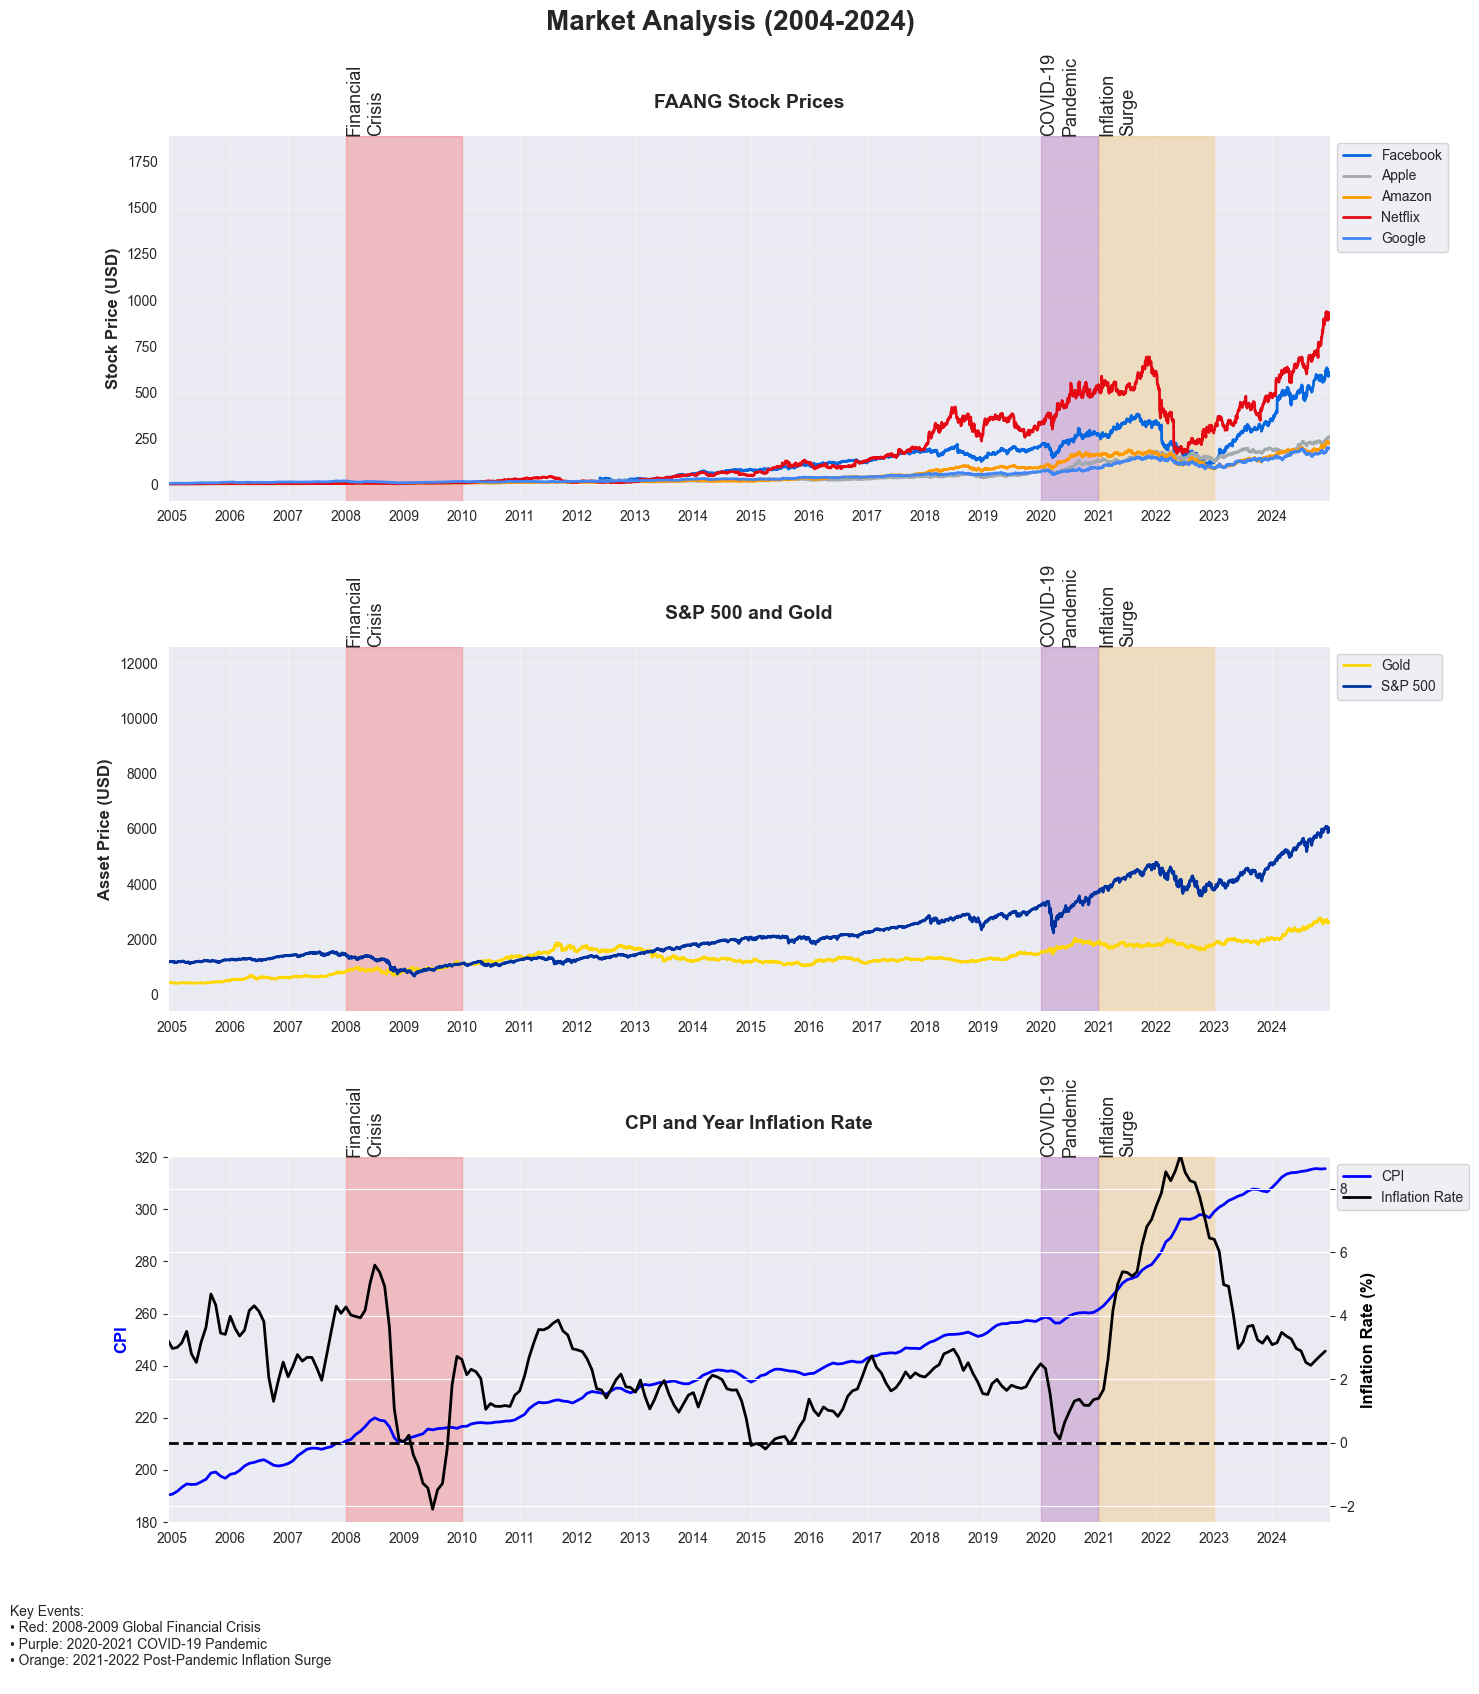

In [7]:
#Plotting the all data in the same plot for comparison together with key events
def create_combined_plot(tech_data, trad_data, inflation_data, events, start_date, end_date):
    """
    Create three-panel visualization showing market data and economic indicators.
    """
    fig = plt.figure(figsize=(15, 18))
    gs = GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.4)

    # Define color schemes for better visualization
    tech_colors = {
        "Amazon": "#FF9900",
        "Apple": "#A2AAAD",
        "Facebook": "#0668E1",
        "Google": "#4285F4",
        "Netflix": "#E50914"
    }
    
    trad_colors = {
        "S&P 500": "#0033A0",
        "Gold": "#FFD700"
    }

    # Panel 1: FAANG stocks
    ax1 = fig.add_subplot(gs[0])
    for company, data in tech_data.items():
        color = tech_colors[company]
        ax1.plot(data.index, data['Close'], label=company, color=color, linewidth=2)
        ax1.fill_between(data.index,
                        data['RollingMean'] - data['RollingStd'],
                        data['RollingMean'] + data['RollingStd'],
                        color=color, alpha=0)

    ax1.set_title('FAANG Stock Prices', fontsize=14, pad=20, fontweight='bold')
    ax1.set_ylabel('Stock Price (USD)', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax1.grid(True, alpha=0.3)

    # Panel 2: Traditional Assets
    ax2 = fig.add_subplot(gs[1])
    for asset, data in trad_data.items():
        color = trad_colors[asset]
        ax2.plot(data.index, data['Close'], label=asset, color=color, linewidth=2)
        ax2.fill_between(data.index,
                        data['RollingMean'] - data['RollingStd'],
                        data['RollingMean'] + data['RollingStd'],
                        color=color, alpha=0)

    ax2.set_title('S&P 500 and Gold', fontsize=14, pad=20, fontweight='bold')
    ax2.set_ylabel('Asset Price (USD)', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax2.grid(True, alpha=0.3)

    # Panel 3: CPI and Inflation Rate with dual axes
    ax3 = fig.add_subplot(gs[2])
    ax3_twin = ax3.twinx()

    # Plot CPI and Inflation Rate
    line1 = ax3.plot(inflation_data['Date'], inflation_data['CPI'], 
                    color='blue', label='CPI', linewidth=2)
    ax3.set_ylabel('CPI', color='blue', fontsize=12, fontweight='bold')
    
    line2 = ax3_twin.plot(inflation_data['Date'], inflation_data['YoY_Inflation'],
                         color='black', label='Inflation Rate', linewidth=2)
    ax3_twin.set_ylabel('Inflation Rate (%)', color='black', 
                       fontsize=12, fontweight='bold')
    ax3_twin.axhline(y=0, color='black', linestyle='--', linewidth=2, label="y=0 Line")

    # Set axis limits and ticks
    ax3_twin.set_ylim(-2.5, 9)
    ax3_twin.yaxis.set_major_locator(plt.MultipleLocator(2))
    ax3.set_ylim(180, 320)
    ax3.yaxis.set_major_locator(plt.MultipleLocator(20))

    # Combine legends
    lines = line1 + line2
    labels = ['CPI', 'Inflation Rate']
    ax3.legend(lines, labels, loc='upper left', bbox_to_anchor=(1, 1))

    ax3.set_title('CPI and Year Inflation Rate', 
                 fontsize=14, pad=20, fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # Set proper axis visibility
    ax3.set_zorder(1)
    ax3_twin.set_zorder(2)
    ax3.patch.set_visible(True)

    # Apply consistent formatting to all panels
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_major_formatter(DateFormatter('%Y'))
        
        # Add event highlighting
        for event in events:
            start = pd.to_datetime(event['start'])
            end = pd.to_datetime(event['end'])
            ax.axvspan(start, end, 
                      alpha=0.2, color=event['color'],
                      label=event['name'])
            
            ax.text(start, ax.get_ylim()[1],
                   event['name'],
                   rotation=90,
                   verticalalignment='bottom',
                   fontsize=13)

    # Clean up axis appearance
    for ax in [ax1, ax2, ax3, ax3_twin]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        for label in ax.get_xticklabels():
            label.set_rotation(0)

    # Add title and caption
    fig.suptitle('Market Analysis (2004-2024)',
                fontsize=20, y=0.95, fontweight='bold')

    caption = (
        'Key Events:\n'
        '• Red: 2008-2009 Global Financial Crisis\n'
        '• Purple: 2020-2021 COVID-19 Pandemic\n'
        '• Orange: 2021-2022 Post-Pandemic Inflation Surge\n'
    )
    fig.text(0.02, 0.02, caption, fontsize=10, va='bottom')

    return fig

# Define key events
events = [
    {
        'name': 'Financial\nCrisis',
        'start': '2008-01-01',
        'end': '2009-12-31',
        'color': 'red'
    },
    {
        'name': 'COVID-19\nPandemic',
        'start': '2020-01-01',
        'end': '2020-12-31',
        'color': 'purple'
    },
    {
        'name': 'Inflation\nSurge',
        'start': '2021-01-01',
        'end': '2022-12-31',
        'color': 'orange'
    }
]

# Load market data
print("Loading and processing market data...")

tech_data = {
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog
}

trad_data = {
    'Gold': gold,
    'S&P 500': sp500,
}

# Create and process inflation DataFrame
inflation_data = get_cpi_data(START_DATE, END_DATE)

# Create and save visualization
print("Creating visualization...")
fig = create_combined_plot(tech_data, trad_data, inflation_data, 
                         events, START_DATE, END_DATE)

plt.savefig('market_analysis.png',
            dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print("Visualization saved as 'market_analysis.png'")
plt.show()

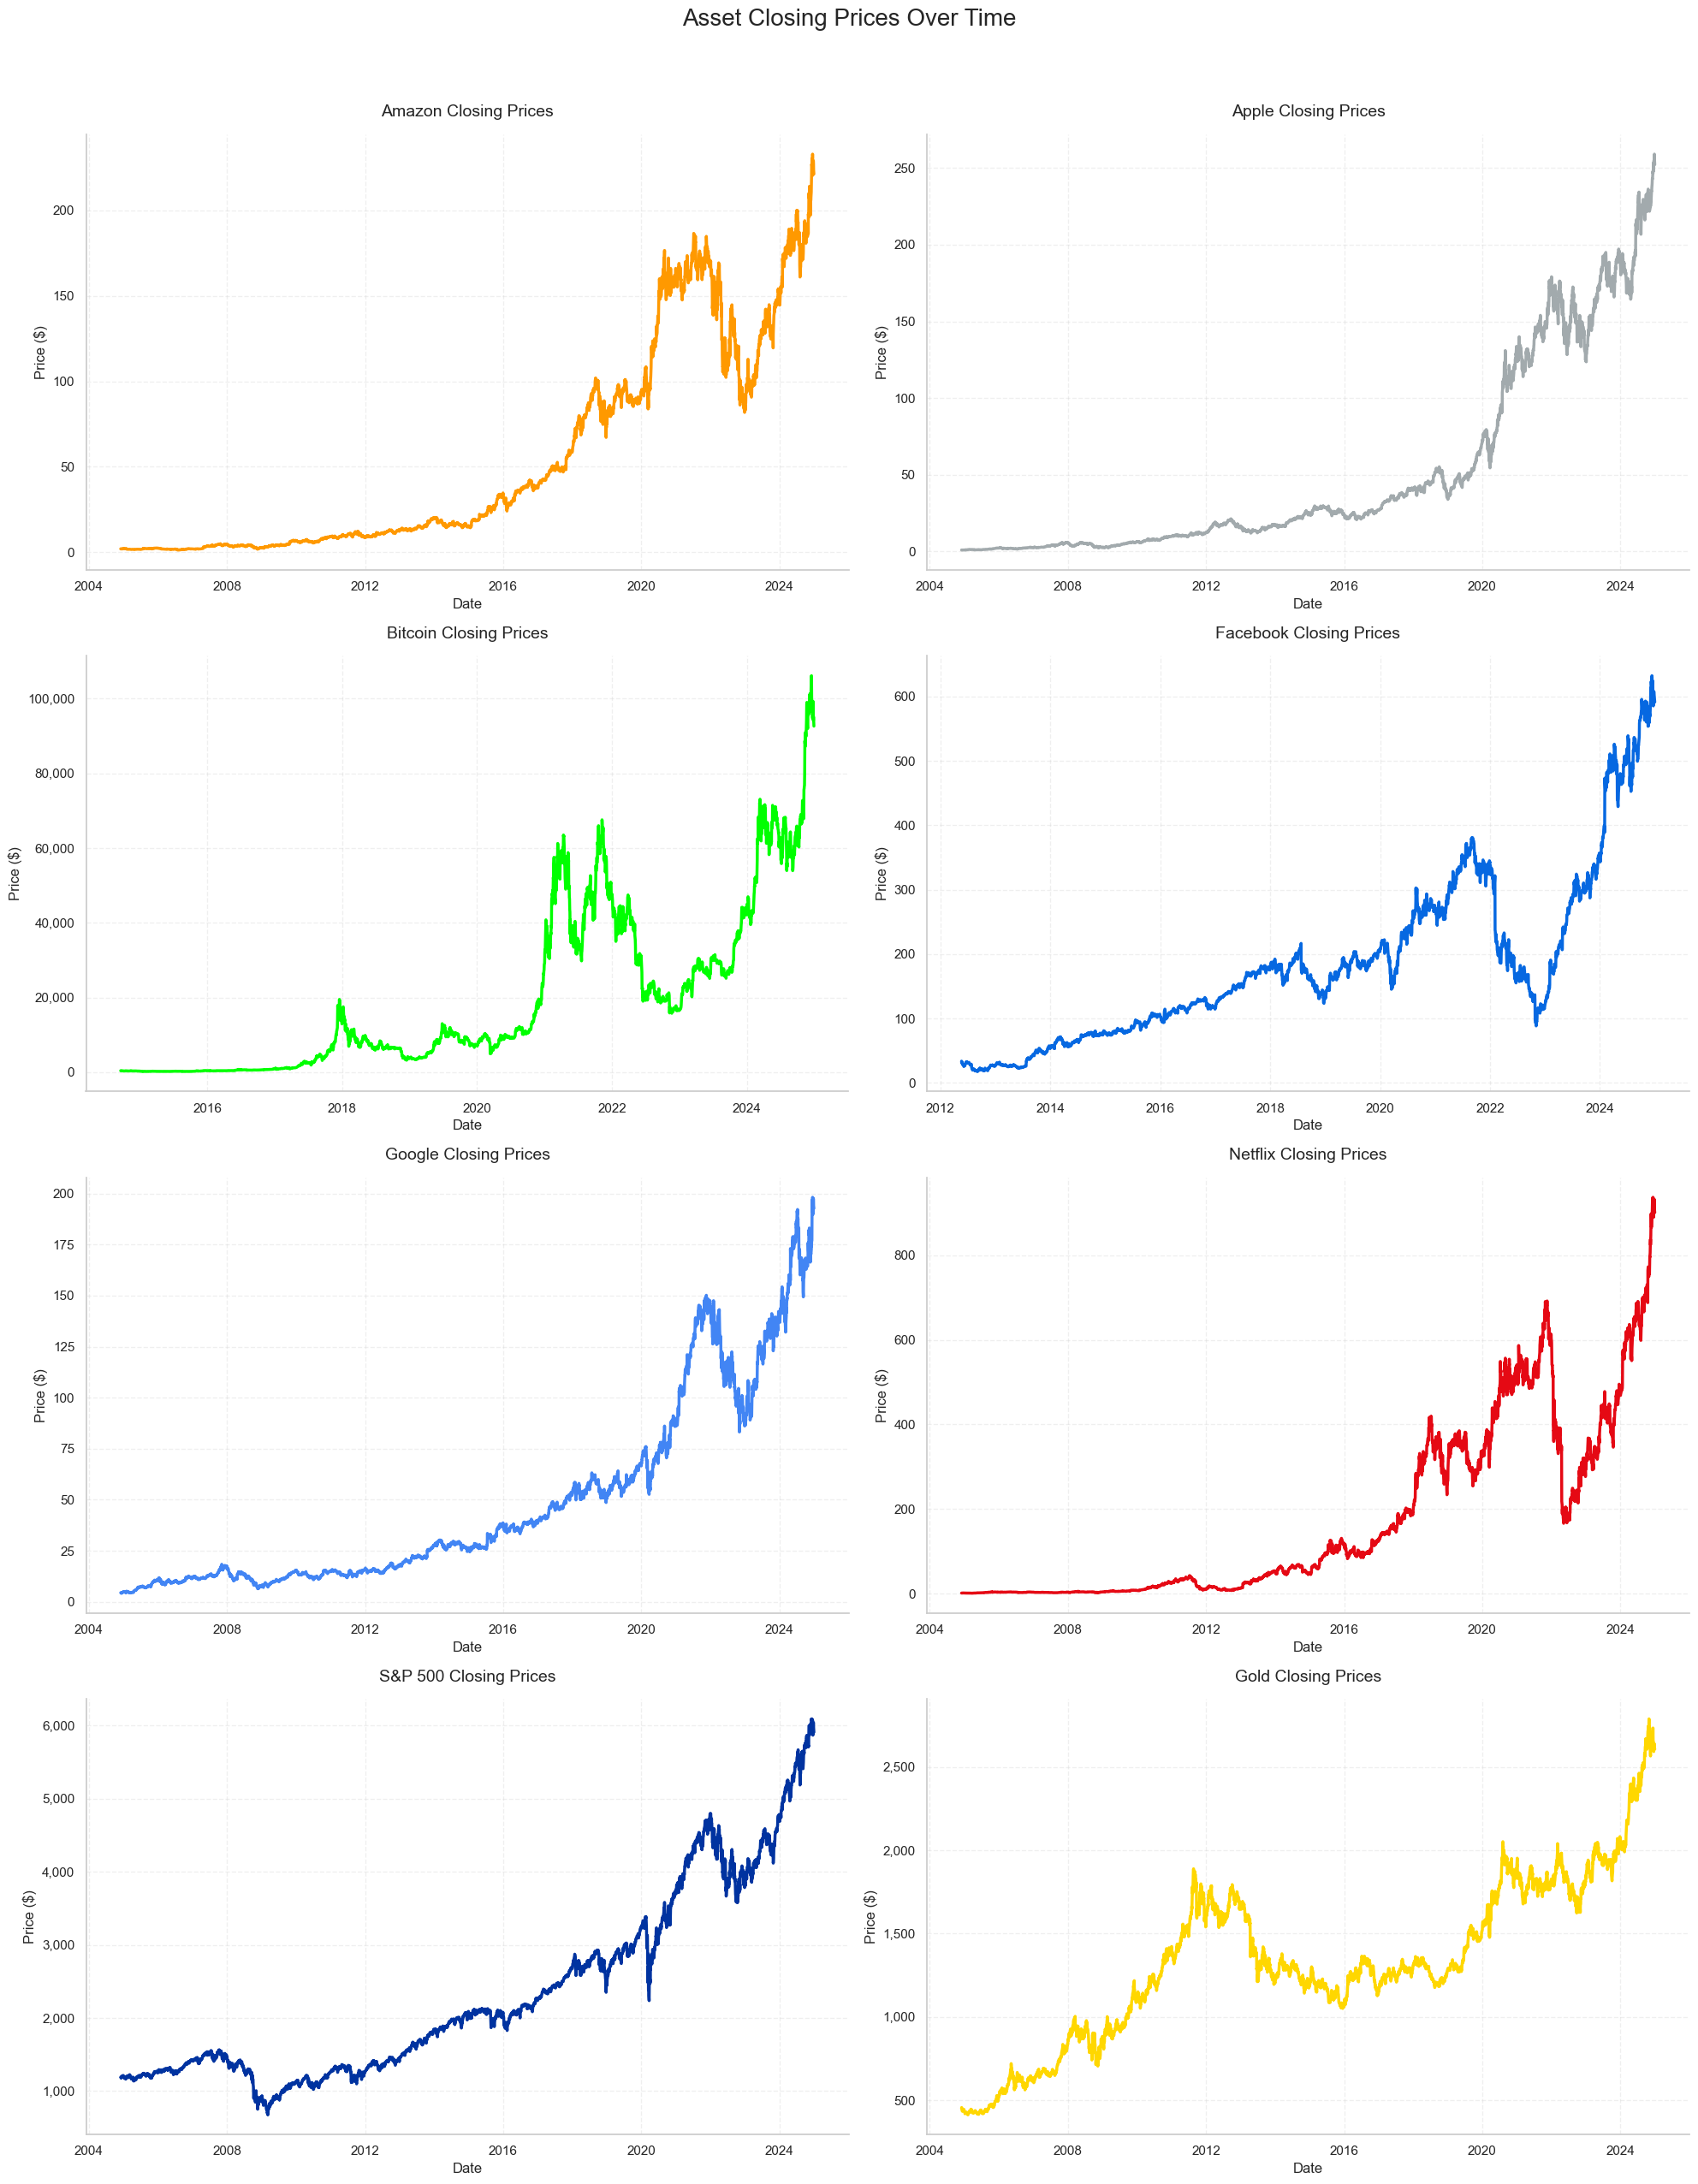

In [8]:
# Create subplots for each dataset
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(4, 2, figsize=(20, 25))
fig.suptitle('Asset Closing Prices Over Time', fontsize=20, y=1.02)

# Flatten axs for easier iteration
axs_flat = axs.flatten() # transforms a 2D array of subplot objects into a 1D array

# Plot each dataset 
for idx, (stock, color) in enumerate(stock_names_color.items()):
    # Read data
    df = ALL_ASSETS[stock]
    
    # Create plot with seaborn
    sns.lineplot(data=df, x='Date', y='Close', color=color, ax=axs_flat[idx], 
                linewidth=2.5)
    
    # Customize plot 
    axs_flat[idx].set_title(f'{stock} Closing Prices', fontsize=14, pad=15)
    axs_flat[idx].set_xlabel('Date', fontsize=12)
    axs_flat[idx].set_ylabel('Price ($)', fontsize=12)
    axs_flat[idx].tick_params(axis='x', rotation=0)
    axs_flat[idx].grid(True, alpha=0.3, linestyle='--')
    
    # Format y-axis with comma separator and proper decimal handling
    axs_flat[idx].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
    
    # Set spines
    axs_flat[idx].spines['top'].set_visible(False)
    axs_flat[idx].spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

plt.show()


# Assets summary statistics and insights

Understanding the Summary Statistics of All Assets

The provided script generates and displays summary statistics for multiple assets based on their closing prices. These statistics help in evaluating individual asset performance and making informed portfolio decisions.

Breakdown of Each Statistic

Count: The number of available data points for each asset, indicating the sample size.

Mean (Average Price): Represents the average closing price of each asset over the period. It helps in comparing the relative value of different assets.

Standard Deviation (Std Dev): Measures the dispersion of prices around the mean. A higher standard deviation signifies greater volatility, whereas a lower standard deviation suggests stability.

Minimum & Maximum: These values show the lowest and highest closing prices recorded in the dataset, helping to understand the price range.

25th Percentile (1st Quartile, Q1): The price at which 25% of the data points fall below. It indicates the lower range of price distribution.

Median (50th Percentile, Q2): The middle price when all closing prices are ordered. It is a useful measure of central tendency, particularly when there are outliers.

75th Percentile (3rd Quartile, Q3): The price at which 75% of the data points fall below. It gives an upper bound of the typical price range.

Impact on Portfolio or Asset Evaluation

1. Identifying Attractive Investments

The asset with the highest Mean Price may be considered a premium or strong performer.

Conversely, the asset with the lowest Mean Price could indicate an undervalued investment opportunity or a weak performer.

2. Understanding Risk and Volatility

The Standard Deviation helps assess risk. Higher volatility suggests greater potential gains but also higher risks.

The Coefficient of Variation (CV = Std Dev / Mean) allows for comparing risk-adjusted returns across different assets. A lower CV indicates a more stable asset relative to its price.

3. Evaluating Stability and Safe Havens

The asset with the lowest Std Dev is the most stable and may be suitable for risk-averse investors.

Stability is particularly useful in bearish markets where price swings can be detrimental.

4. Price Distribution and Market Trends

Analyzing the Minimum, Maximum, and Quartiles helps understand market trends and detect whether an asset has been consistently growing or experiencing significant fluctuations.

Assets with a higher Median compared to their Mean might have experienced short-term price drops, while assets with a higher Mean than Median might have seen sharp price increases.

Key Insights from the Analysis

Highest average price asset: Indicates the most expensive asset, which could be due to strong fundamentals or high market demand.

Lowest average price asset: Might be undervalued, offering an opportunity for potential price appreciation.

Most volatile asset: Higher risk and higher return potential; suitable for aggressive investors.

Most stable asset: Lower risk, ideal for conservative portfolios focused on stability and capital preservation.

Conclusion

This analysis provides essential insights for portfolio management. Investors can use these statistics to:

Diversify their portfolio by balancing high and low-risk assets.

Optimize asset allocation based on volatility and average returns.

Identify assets that fit their risk tolerance and investment strategy.

Understanding these statistics allows for more informed decision-making, ultimately leading to better financial outcomes and risk management in a portfolio.

In [9]:
all_assets_stats = {}

for stock_name, stock_df in ALL_ASSETS.items():
    stats = stock_df['Close'].describe()
    stats = stats.round(2)
    if stats is not None:
        all_assets_stats[stock_name] = stats

# Create a DataFrame to consolidate the statistics
if all_assets_stats:
    summary_df = pd.DataFrame(all_assets_stats)

    # Create the final summary DataFrame with proper column names
    final_summary = pd.DataFrame({
        'Count': summary_df.loc['count'],
        'Mean': summary_df.loc['mean'],
        'Std Dev': summary_df.loc['std'],
        'Minimum': summary_df.loc['min'],
        '25th Percentile': summary_df.loc['25%'],
        'Median': summary_df.loc['50%'],
        '75th Percentile': summary_df.loc['75%'],
        'Maximum': summary_df.loc['max']
    })

    # Display results
    print("\nSummary Statistics for All Assets:")
    print("=" * 80)
    print(final_summary.T)

    # Print key insights
    print("\nKey Insights:")
    print("-" * 80)
    print(f"Highest average price: {final_summary['Mean'].idxmax()} (${final_summary['Mean'].max():,.2f})")
    print(f"Lowest average price: {final_summary['Mean'].idxmin()} (${final_summary['Mean'].min():,.2f})")
    print(f"Most volatile asset (highest std dev): {final_summary['Std Dev'].idxmax()}")
    print(f"Most stable asset (lowest std dev): {final_summary['Std Dev'].idxmin()}")

    # Additional insights
    print("\nVolatility Analysis:")
    print("-" * 80)
    for asset in final_summary.index:
        mean = final_summary.loc[asset, 'Mean']
        std = final_summary.loc[asset, 'Std Dev']
        cv = std / mean  # Coefficient of Variation
        print(f"{asset}: CV = {cv:.4f} (Std Dev / Mean)")
else:
    print("No data processed.")



Summary Statistics for All Assets:
                  Amazon    Apple    Bitcoin  Facebook     Gold   Google  \
Count            5053.00  5053.00    3757.00   3173.00  5045.00  5053.00   
Mean               54.07    51.24   19571.29    184.89  1335.04    48.35   
Std Dev            60.60    63.24   22097.39    129.73   481.64    46.41   
Minimum             1.30     0.94     178.10     17.66   412.60     4.22   
25th Percentile     5.92     5.99    1229.08     87.68  1076.40    13.25   
Median             18.67    22.22    9350.53    165.21  1292.90    27.87   
75th Percentile    94.33    64.10   30548.70    241.57  1710.50    63.93   
Maximum           232.93   259.02  106140.60    632.17  2788.50   198.16   

                 Netflix  S&P 500  
Count            5053.00  5053.00  
Mean              175.54  2348.57  
Std Dev           208.52  1275.32  
Minimum             1.29   676.53  
25th Percentile     7.79  1309.93  
Median             64.05  1979.92  
75th Percentile   330.13  2

Key Insights from the Analysis 2004 - 2024

Highest average price asset: Bitcoin ($19,571.29), indicating the most expensive asset, possibly due to strong fundamentals or high market demand.

Lowest average price asset: Google ($49.72), which might be undervalued, offering an opportunity for potential price appreciation.

Most volatile asset: Bitcoin, with the highest standard deviation, making it a high-risk, high-return option suitable for aggressive investors.

Most stable asset: Google, with the lowest standard deviation, ideal for conservative portfolios focused on stability and capital preservation.

# Histogram of Assets clossing prices distribution

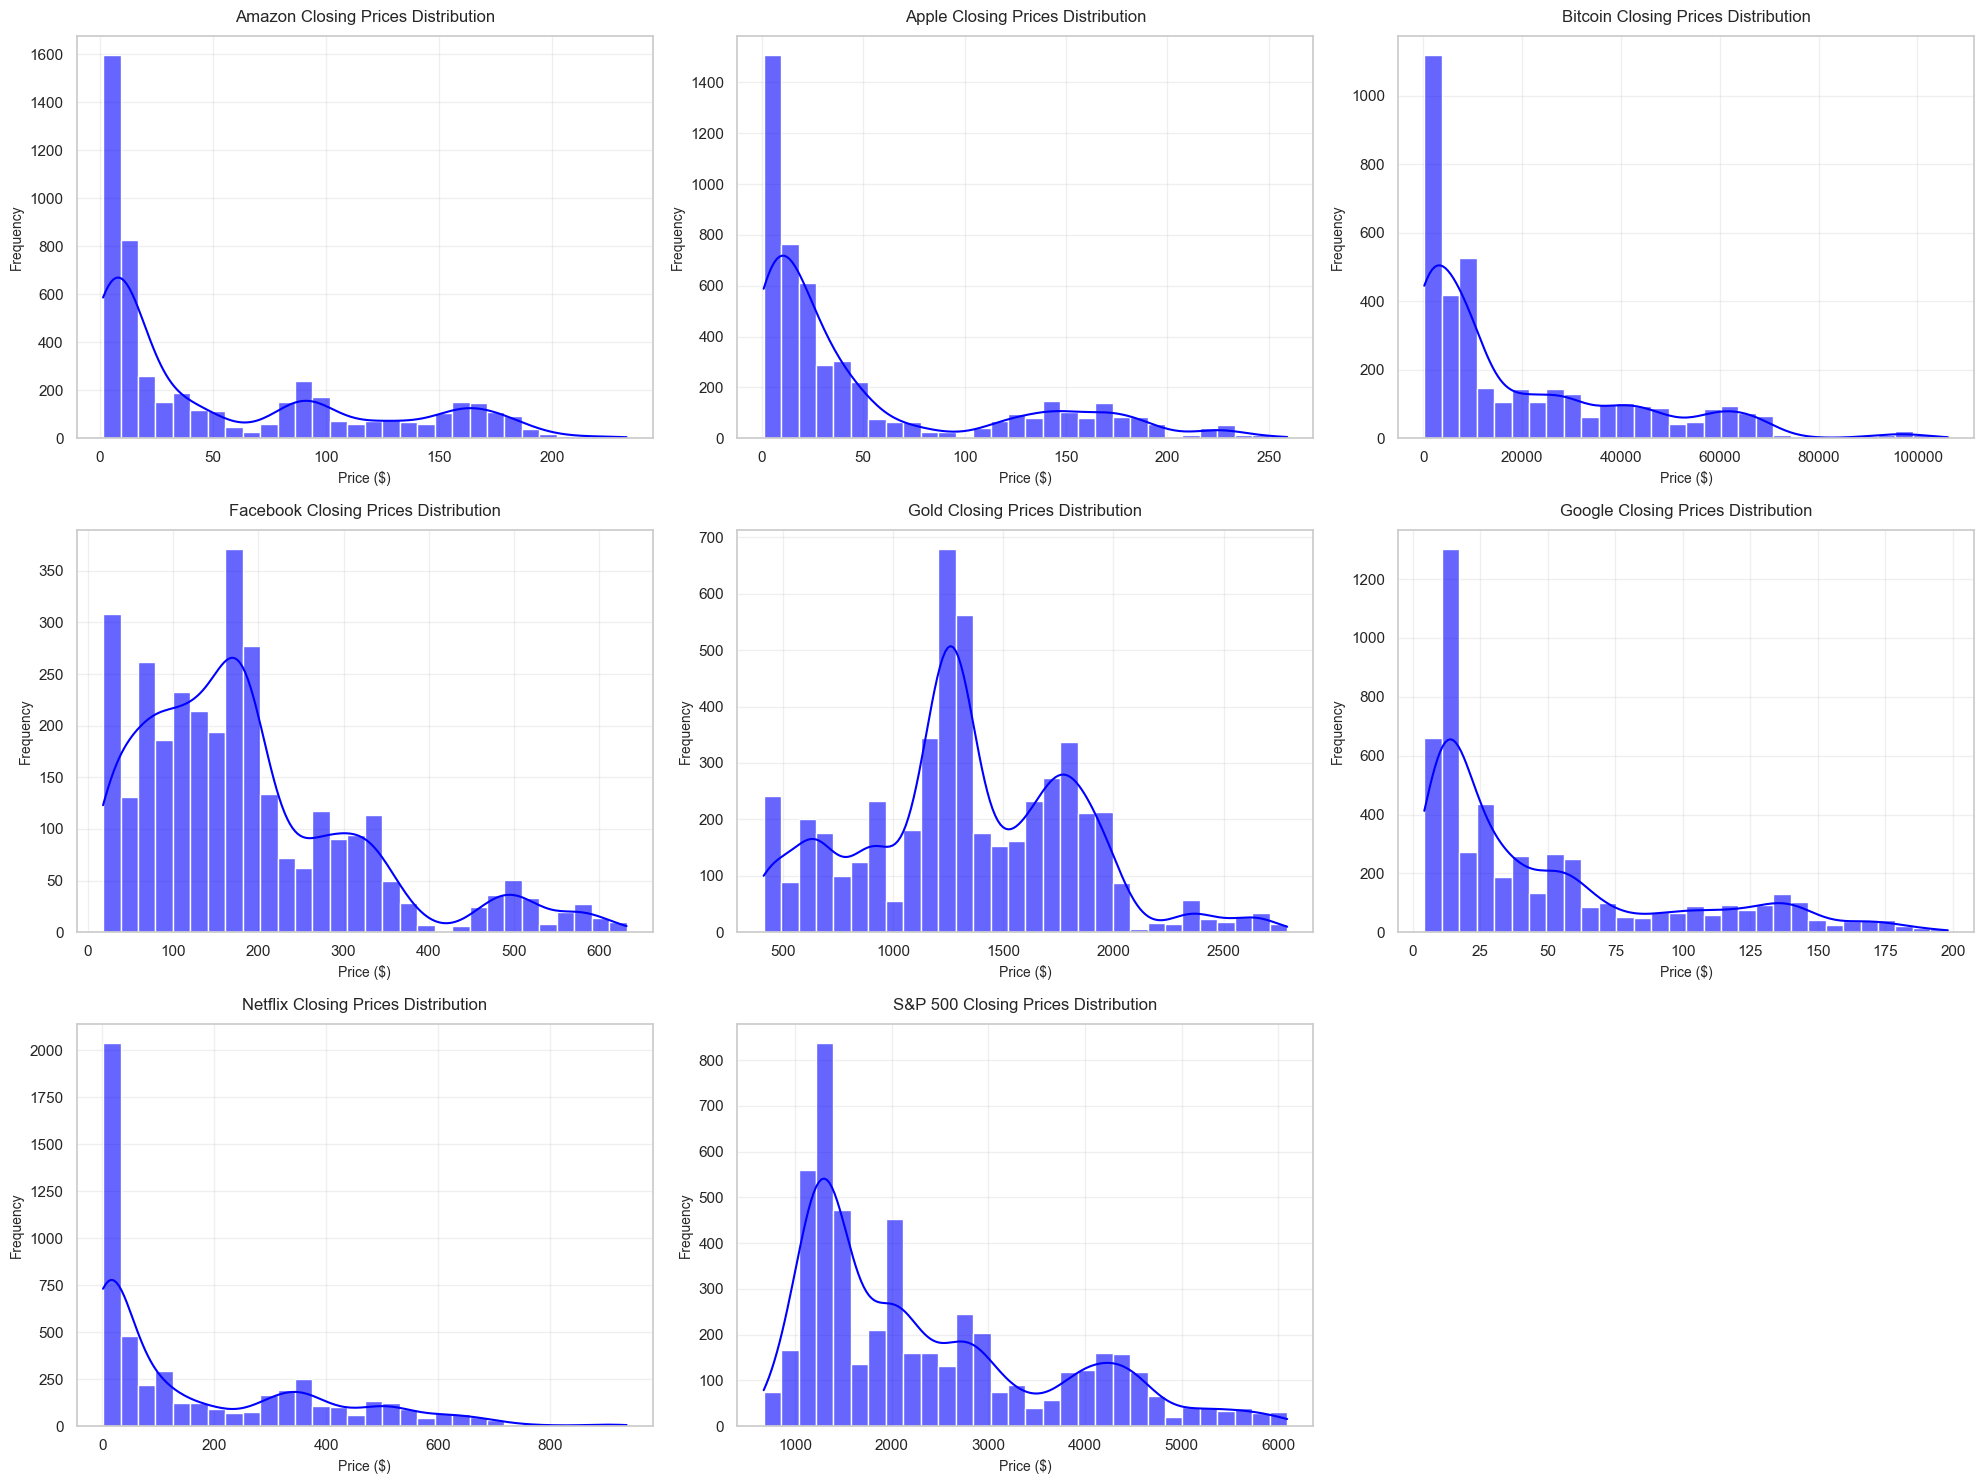

In [10]:
# Load all closing prices into a dictionary
closing_prices = {}
for stock_name, stock_df in ALL_ASSETS.items():
    closing_prices[stock_name] = stock_df['Close']

# Create histograms
plt.figure(figsize=(20, 15))

# Calculate number of rows and columns needed
n_stocks = len(closing_prices)
n_cols = 3
n_rows = (n_stocks + n_cols - 1) // n_cols  # Ceiling division

# Create subplots for each stock
for i, (stock, prices) in enumerate(closing_prices.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Create histogram with KDE
    sns.histplot(data=prices.dropna(), 
                bins=30, 
                kde=True,
                color='blue',
                alpha=0.6)
    
    # Customize the subplot
    plt.title(f'{stock} Closing Prices Distribution', fontsize=12, pad=10)
    plt.xlabel('Price ($)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Heatmap of Correlation Matrix and Pairplot for all assets

# Heatmap and pairplot with assets monthly averages and inflation rate
## Why Are Monthly Averages Better?
### Mitigates Daily Volatility:
 - Stock prices can exhibit significant daily fluctuations due to short-term factors like market sentiment, news, or events.
 - Using a single day's closing price (e.g., the last trading day) might misrepresent the true trend of the stock for 
that month, especially if that day was an outlier.
 - Monthly averages smooth out these fluctuations and provide a more reliable representation of the stock's performance.
 - Better Alignment with Inflation Trends:
 - Inflation is a macroeconomic indicator that reflects broader trends rather than daily changes. It has a cumulative effect over the entire month.
 - Monthly averages ensure the stock data corresponds to this time frame, improving the relevance of the correlation analysis.
### Reduces Noise:
 - Outliers in daily prices, such as sudden spikes or dips, can distort correlations when using a single day's closing price.
 - Averages reduce the impact of outliers and provide a more stable basis for comparison.
### Consistency Across Assets:
 - Different assets (e.g., stocks, Bitcoin, gold) trade on different schedules. Some might not trade daily or on weekends.
 - Using monthly averages ensures consistency in the time period analyzed for all assets.
### Improves Statistical Robustness:
 - Averages are less sensitive to random fluctuations and ensure that the correlation results are more reliable and reflective of general trends.

## Advantages in the Heatmap
### Improved Reliability:
 - The heatmap now reflects correlations based on a more stable dataset (monthly averages), reducing the likelihood of misleading results caused by day-to-day noise.
### Better Interpretability:
 - Correlations are easier to interpret as they represent relationships between inflation and more generalized stock performance over the month, rather than just a single day's snapshot.
## Drawbacks of Using Monthly Averages
### Loss of Granularity:
 - Averaging eliminates daily price trends and may overlook short-term relationships or events.
 - If analyzing short-term impacts of inflation or specific events, daily data might be more appropriate.
### Potential Lag Effects:
 - Inflation's impact on stock prices might not appear in the same month. Lagging inflation data by one or more months could improve correlations.
## Conclusion
Using monthly averages balances the trade-off between granularity and reliability, making it ideal for long-term and trend-based 
analyses like inflation's relationship with stock prices. This method ensures more stable and interpretable results, especially for macroeconomic studies.

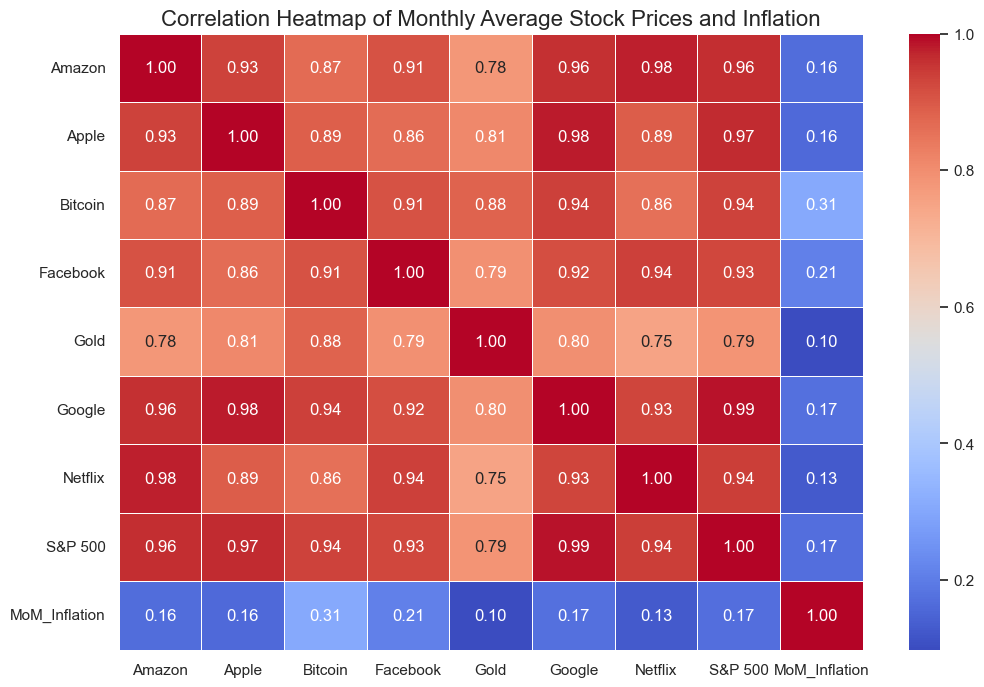

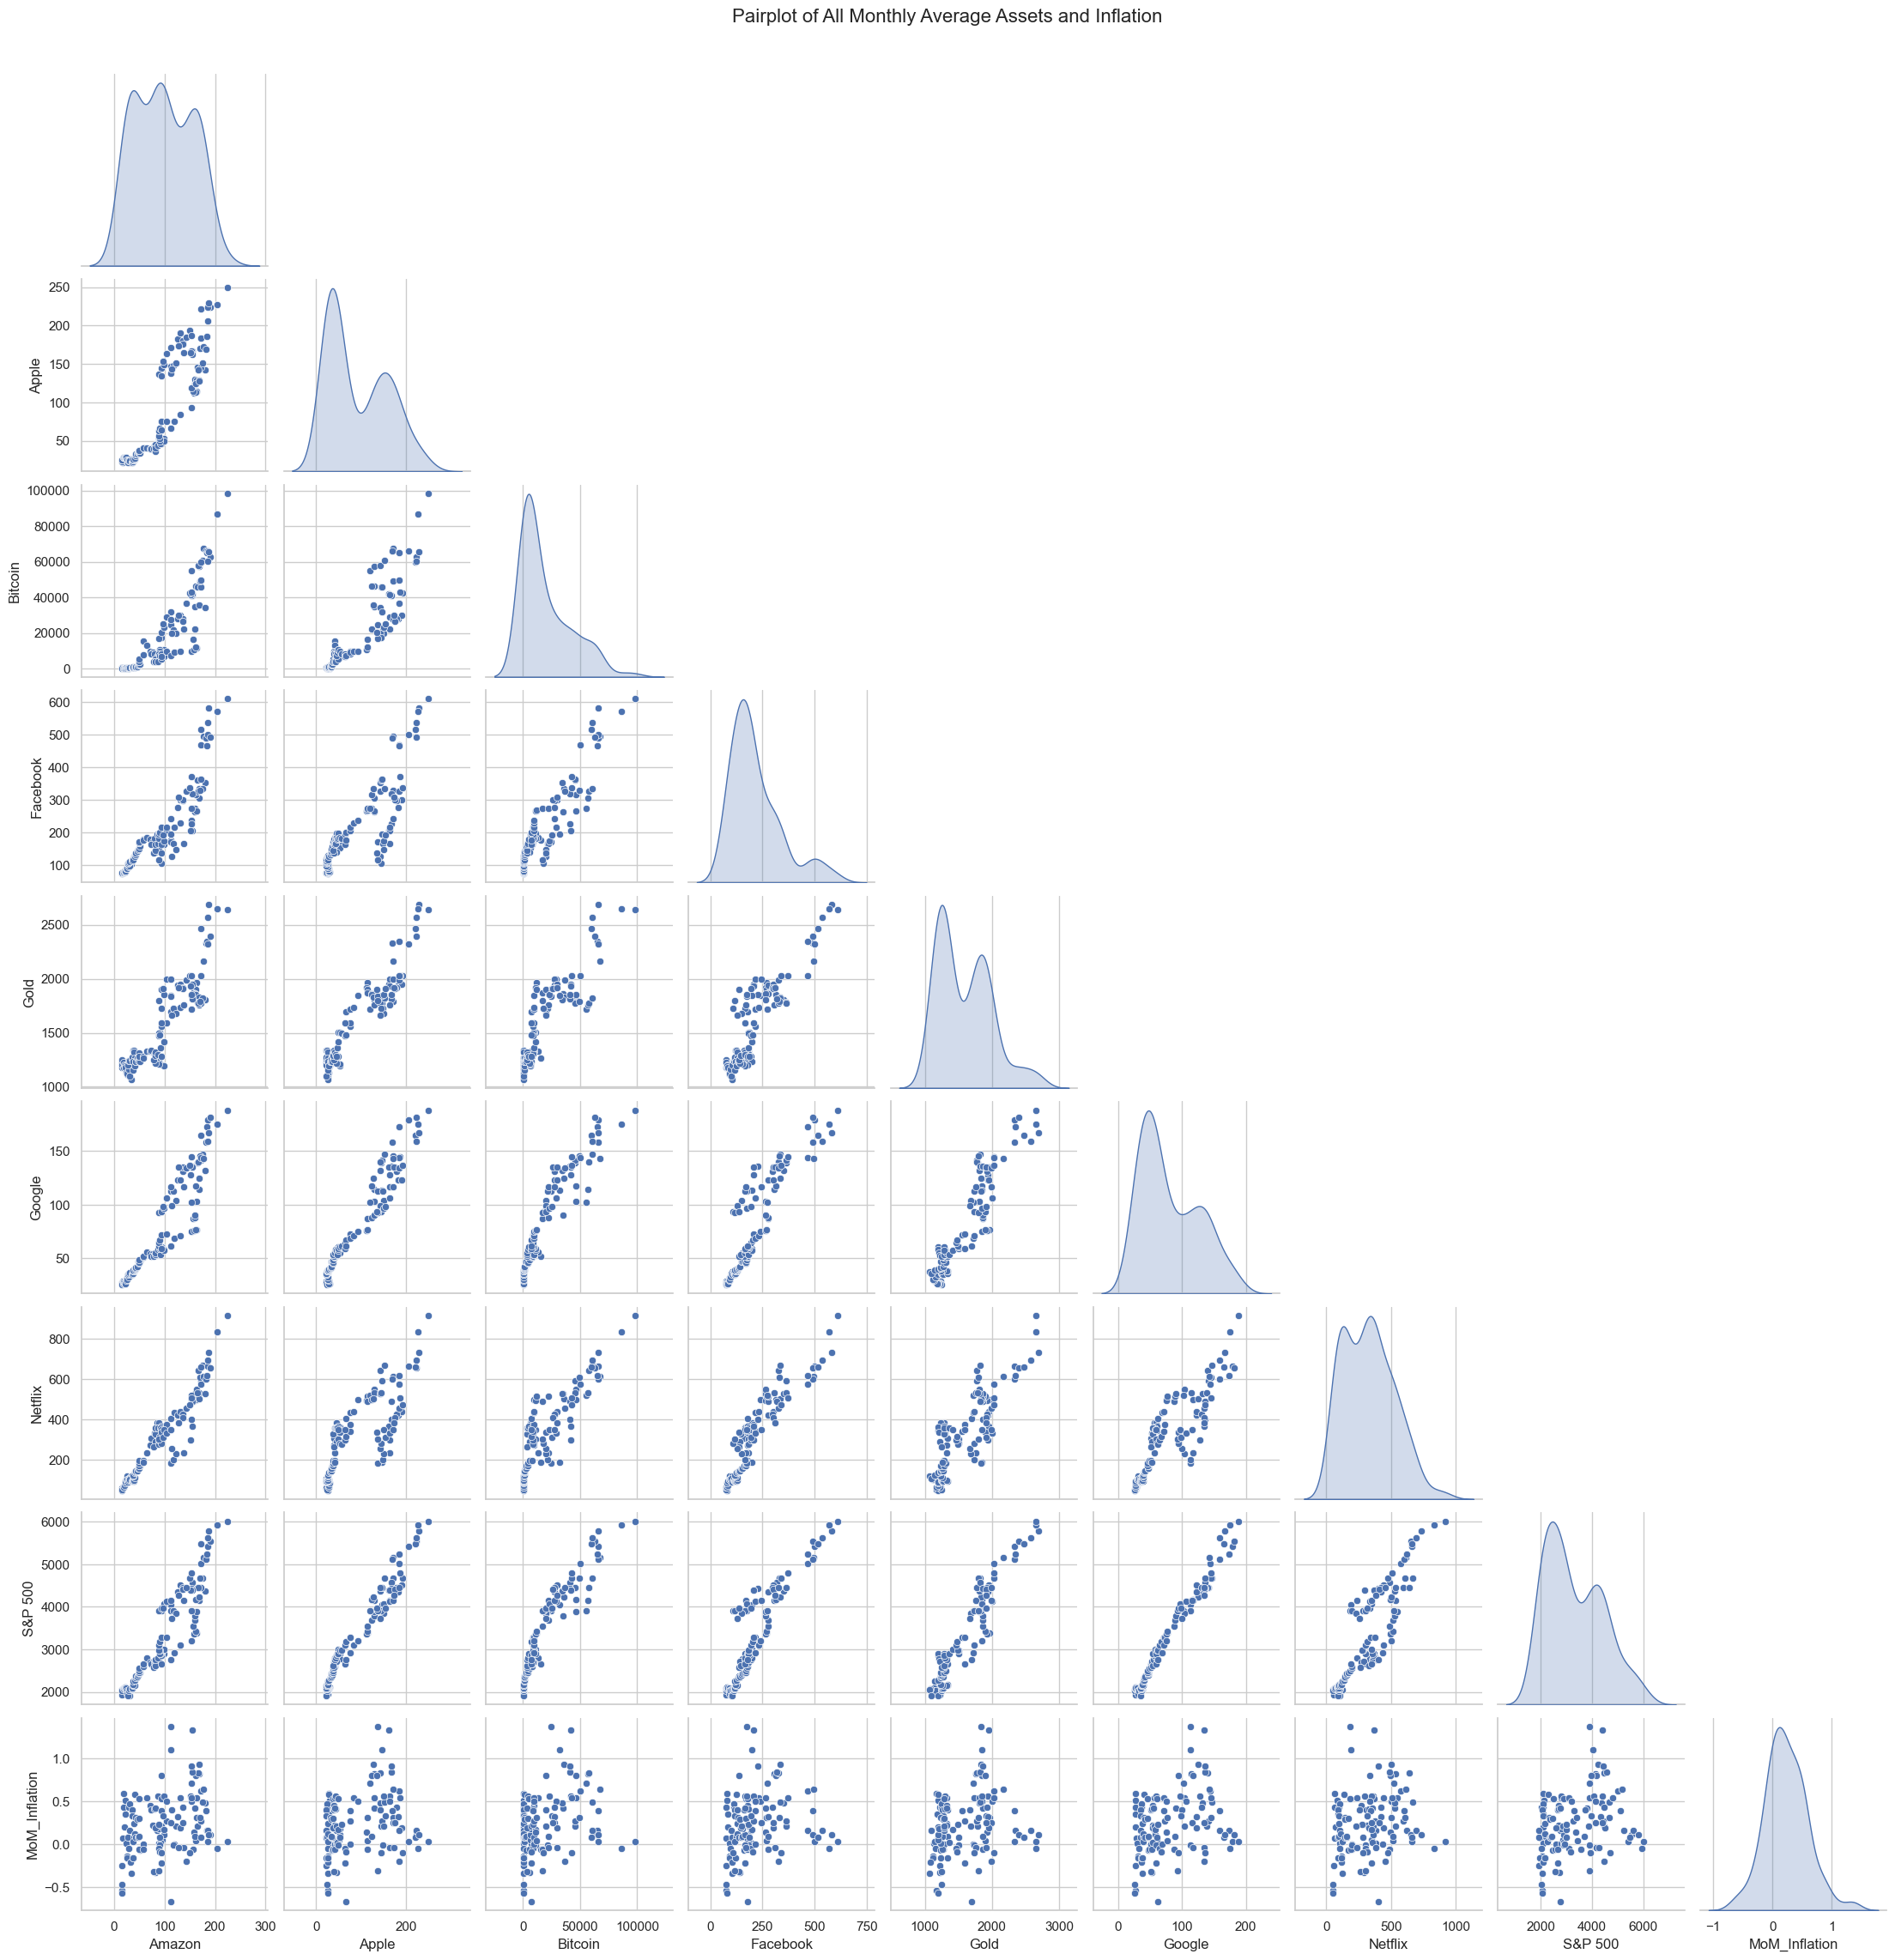

In [28]:
# Define file paths
file_names = {
    "Amazon": "AMZN_cleaned.csv",
    "Apple": "AAPL_cleaned.csv",
    "Bitcoin": "BTC-USD_cleaned.csv",
    "Facebook": "META_cleaned.csv",
    "Google": "GOOG_cleaned.csv",
    "Netflix": "NFLX_cleaned.csv",
    "S&P 500": "GSPC_cleaned.csv",
    "Gold": "GC_F_cleaned.csv"
}

# Combine 'Close' prices of all assets into a single DataFrame with monthly averages
close_prices_combined = pd.DataFrame()

for asset, df in ALL_ASSETS.items():
    df = df[(df.index >= pd.to_datetime(START_DATE)) & (df.index <= pd.to_datetime(END_DATE))]
    temp_df = df.copy()
    temp_df['Year'] = temp_df.index.year
    temp_df['MonthIdx'] = temp_df.index.month
    monthly_avg = temp_df.groupby(['Year', 'MonthIdx'])['Close'].mean().reset_index()
    monthly_avg.rename(columns={'Close': asset}, inplace=True)
    if close_prices_combined.empty:
        close_prices_combined = monthly_avg
    else:
        # merge on year
        close_prices_combined = close_prices_combined.merge(monthly_avg, on=['Year', 'MonthIdx'], how='outer')
        
inflation_df = get_cpi_data(START_DATE, END_DATE)

close_prices_combined['Month'] = close_prices_combined['Year'].astype(str) + "-" + close_prices_combined['MonthIdx'].astype(str).str.zfill(2)

# Merge with monthly average stock prices
# add a column for the MoM inflation
close_prices_combined = close_prices_combined.merge(inflation_df[['Month', 'MoM_Inflation']], on='Month')

plot_df = close_prices_combined.copy().drop(columns=['Year', 'MonthIdx', 'Month'])

# Compute the correlation matrix
correlation_matrix = plot_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Monthly Average Stock Prices and Inflation", fontsize=16)
plt.show()

# Prepare data for pairplot
pairplot_data = plot_df.dropna()

# Create pairplot including inflation
sns.pairplot(pairplot_data, diag_kind="kde", kind="scatter", corner=True)
plt.suptitle("Pairplot of All Monthly Average Assets and Inflation", y=1.02, fontsize=16)
plt.show()



Correlation Analysis Between Stocks and Inflation
Observations from the Correlation Heatmap:
Stocks vs. Inflation Rate:

Tech Stock Correlations:
The tech companies (Amazon, Apple, Google, Facebook, Netflix) show very strong positive correlations with each other (mostly above 0.90). This suggests these companies' stock prices tend to move together, which makes sense as they often react similarly to market conditions and tech sector trends. For example:

Google and Apple show a 0.98 correlation, indicating almost identical price movement patterns
Amazon and Netflix show a 0.98 correlation, suggesting very similar price behaviors
Facebook shows slightly lower but still strong correlations (0.86-0.94) with other tech stocks

Traditional Assets:
The S&P 500 shows very strong correlations (0.93-0.99) with all tech stocks, which isn't surprising since these companies are major components of the index. Gold, however, shows moderately strong correlations (0.75-0.88) with other assets, suggesting it moves somewhat independently and could offer diversification benefits.
Inflation Relationships:
The most striking observation is that inflation (MoM_Inflation) shows very weak positive correlations (0.10-0.30) with all assets. This tells us that:

Monthly price movements of these assets aren't strongly tied to inflation
Bitcoin shows the highest correlation with inflation (0.30), though still weak
Gold, traditionally considered an inflation hedge, shows a surprisingly low correlation (0.10)

The second visualization (pairplot) provides a more detailed view of these relationships:

The diagonal shows the distribution of each asset's prices
The scatter plots show the relationship between each pair of assets

Key observations from the pairplot:

Distribution Shapes:


Tech stocks show right-skewed distributions, indicating more extreme upward price movements
Bitcoin's distribution shows the most extreme right skew, reflecting its volatile nature
Inflation shows a more normal (bell-shaped) distribution


Relationship Patterns:


Most asset pairs show positive, non-linear relationships (curved patterns in scatter plots)
The relationships appear stronger in the lower price ranges and become more scattered at higher prices
The scatter plots with inflation (bottom row) show much more dispersed patterns, confirming the weak correlations


Growth Trajectories:


The scatter plots reveal clear upward trends for most asset pairs
Some relationships show distinct phases or clusters, particularly during major market events

Investment Implications:

Portfolio Diversification:


The high correlations between tech stocks suggest limited diversification benefits within the tech sector
Gold's lower correlations make it valuable for diversification
The weak inflation correlations suggest these assets might not be reliable inflation hedges in the short term


Risk Management:


The strong correlations among tech stocks indicate high systematic risk in tech-heavy portfolios
The non-linear relationships suggest that traditional risk measures might underestimate true portfolio risk


Investment Strategy:


Investors seeking inflation protection might need to look beyond these traditional assets
The clear clustering in relationships suggests potential opportunities for regime-based trading strategies

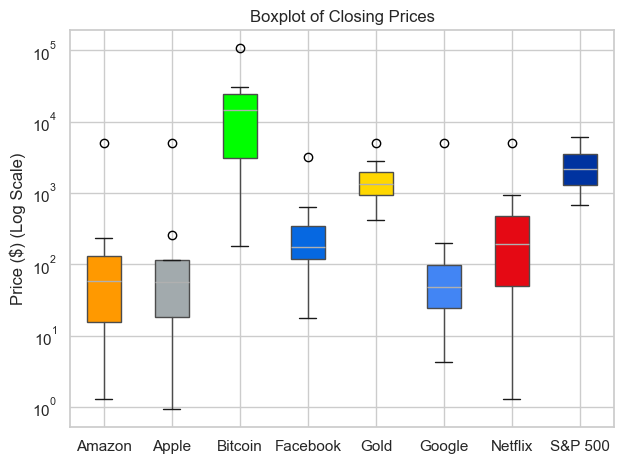

In [12]:
# Assets Boxplot

# Convert the dictionary to a DataFrame
all_assets_df = pd.DataFrame(all_assets_stats)

# Generate a boxplot
boxplot = all_assets_df.boxplot(patch_artist=True, return_type='dict')

# Apply colors to the boxes
colors = [stock_names_color[asset] for asset in all_assets_df.columns]  # Extract colors in column order
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Customize the plot
plt.yscale('log')  # If you prefer a logarithmic scale
plt.title('Boxplot of Closing Prices')
plt.ylabel('Price ($) (Log Scale)')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

From a quick glance, the main takeaway is how widely Bitcoin stands out on the high end (in the $1,000–$10,000+ range), whereas the traditional equities and gold cluster in lower ranges—though still spanning multiple orders of magnitude. Because the y-axis is on a log scale, even relatively small vertical differences can translate into big price differences in absolute terms. Here are a few observations:

Bitcoin’s large spread

Its box (the middle 50 % of values) is higher than any other asset, with outliers stretching near $10,000 and beyond. This indicates Bitcoin’s historically high—and volatile—price range.
Equity comparisons

Amazon and Apple both have very wide whiskers, reflecting the fact that both traded at relatively low prices in their early days but also reached into the hundreds or thousands of dollars in more recent years (especially before stock splits).
Facebook, Netflix, and Google each span roughly one or two orders of magnitude—still showing considerable growth over time but not quite as wide a range as Amazon/Apple.
Gold vs. S&P 500

Gold has been mostly in the $1,000–$2,000 range in modern times (so around 10³ on a log scale).
The S&P 500 index hovers from roughly the high hundreds to a few thousand (e.g., 1,000–4,000+), placing it in a similar log-scale band to gold (though with a slightly higher median).
Log scale caveat

A log scale compresses large differences; a small vertical gap might still be hundreds of dollars apart. Hence, seeing Bitcoin towering above the others underlines how large and volatile its price swings have been compared to these more traditional assets.
Overall, the boxplot visually confirms that (i) Bitcoin has historically traded at higher absolute prices (with far more volatility), (ii) technology stocks (Amazon, Apple, Facebook/Meta, Google, Netflix) went from relatively low prices at inception to triple- or quadruple-digit prices, and (iii) gold and the S&P 500 sit in mid-level ranges on this log scale.

# Risk and Return Analysis

The code defines a class, StockAnalyzer, which provides methods to analyze stock performance using key financial metrics. Below is a detailed breakdown:

Class Methods

annualized_volatility():

Computes the annualized standard deviation of daily returns, scaling by √252 (252 trading days in a year).

Significance: Measures the risk or variability of an asset's returns.

daily_returns():

Calculates the percentage change in daily closing prices.

Significance: Used for further calculations like Sharpe ratio, beta, and maximum drawdown.

sharpe_ratio(risk_free_rate=0.05):

Calculates the Sharpe ratio, a measure of risk-adjusted return, by subtracting the risk-free rate from daily returns.

Significance: Higher Sharpe ratios indicate better risk-adjusted performance.

max_drawdown():

Identifies the maximum loss from a peak to a trough during the analysis period.

Significance: Highlights the worst-case scenario for investors.

beta(market_data):

Computes the beta of the stock relative to the market (S&P 500).

Significance: Measures sensitivity to market movements. A beta >1 indicates higher sensitivity, while beta <1 indicates lower sensitivity.

analyze(market_data):

Combines all metrics into a dictionary, including:

Start Price and End Price: Initial and final closing prices.

Total Return: Overall percentage return.

Mean and Median Daily Returns: Average and midpoint of daily returns.



Comprehensive Asset Analysis:
          Annualized Volatility  Sharpe Ratio  Maximum Drawdown    Beta  \
Asset                                                                     
Amazon                   0.3794        0.6744           -0.6525  1.1417   
Apple                    0.3215        0.8665           -0.6087  1.0735   
Bitcoin                  0.5746        0.8318           -0.8340  0.6657   
Facebook                 0.3974        0.6444           -0.7674  0.9572   
Google                   0.3004        0.6087           -0.6529  1.0221   
Netflix                  0.5043        0.7793           -0.8199  1.0051   
S&P 500                  0.1914        0.2523           -0.5678  1.0000   
Gold                     0.1767        0.3019           -0.4436  0.0270   

          Mean Daily Return  Median Daily Return  Start Price   End Price  \
Asset                                                                       
Amazon               0.0012               0.0007       2.0085   

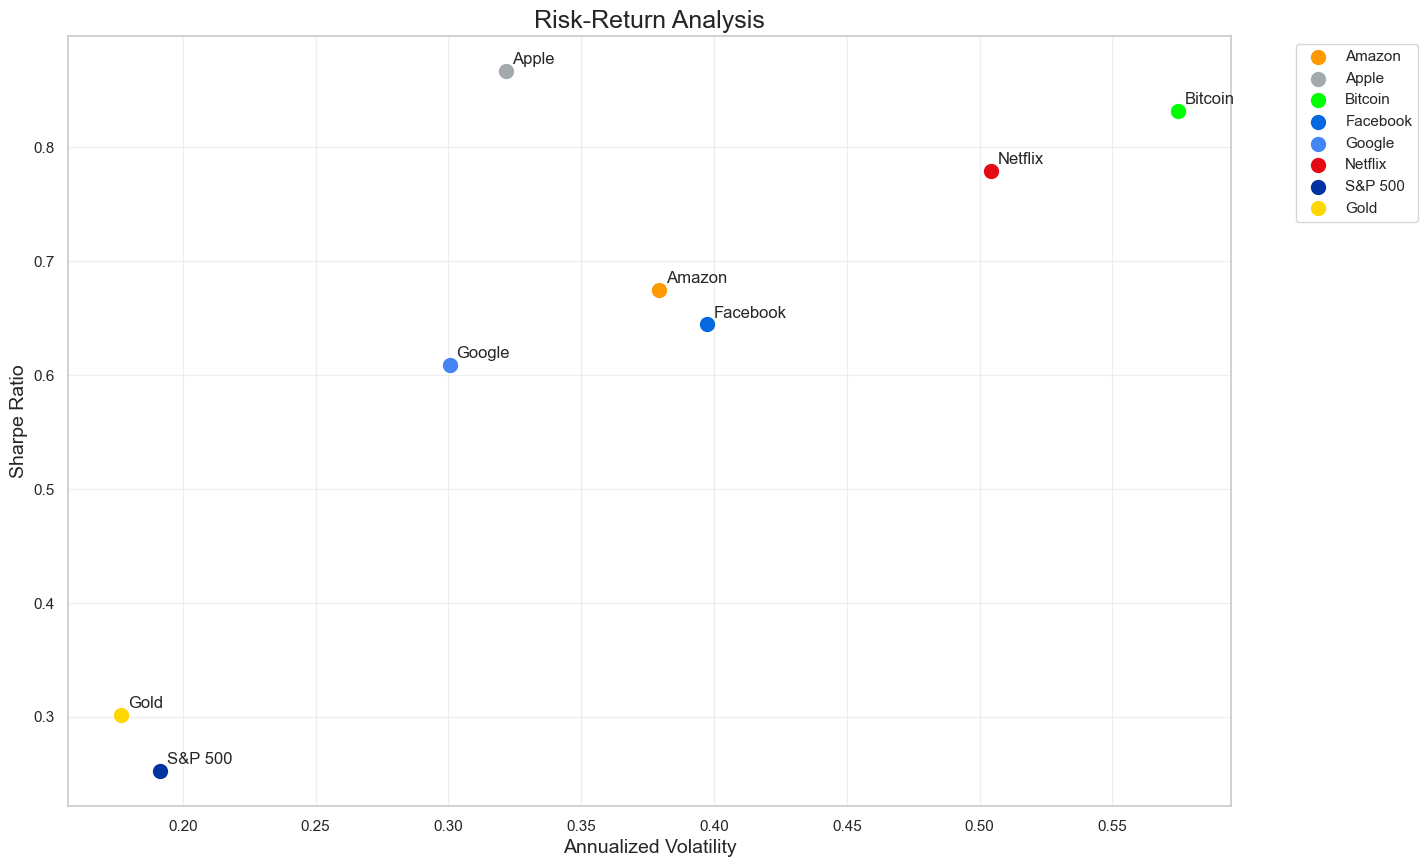


Key Findings:
--------------------------------------------------------------------------------
Highest Sharpe Ratio: Apple (0.8665)
Lowest Volatility: Gold (0.1767)
Highest Total Return: Netflix (55433.11%)
Most Defensive (Lowest Beta): Gold (0.0270)

Risk-Return Profile:
--------------------------------------------------------------------------------
Amazon:
  - Risk (Volatility): 37.94%
  - Risk-Adjusted Return (Sharpe): 0.6744
  - Market Sensitivity (Beta): 1.1417
  - Total Return: 10918.17%

Apple:
  - Risk (Volatility): 32.15%
  - Risk-Adjusted Return (Sharpe): 0.8665
  - Market Sensitivity (Beta): 1.0735
  - Total Return: 25574.95%

Bitcoin:
  - Risk (Volatility): 57.46%
  - Risk-Adjusted Return (Sharpe): 0.8318
  - Market Sensitivity (Beta): 0.6657
  - Total Return: 21727.16%

Facebook:
  - Risk (Volatility): 39.74%
  - Risk-Adjusted Return (Sharpe): 0.6444
  - Market Sensitivity (Beta): 0.9572
  - Total Return: 1644.04%

Google:
  - Risk (Volatility): 30.04%
  - Risk-Adjusted 

In [13]:
class StockAnalyzer:
    def __init__(self, data, name):
        self.data = data
        self.name = name
    
    def annualized_volatility(self):
        """Calculate annualized volatility"""
        daily_returns = self.data['Close'].pct_change()
        return daily_returns.std() * np.sqrt(252)
    
    def daily_returns(self):
        """Calculate daily returns"""
        return self.data['Close'].pct_change()
    
    def sharpe_ratio(self, risk_free_rate=0.05):
        """Calculate Sharpe ratio with given risk-free rate"""
        daily_returns = self.daily_returns()
        excess_returns = daily_returns - risk_free_rate/252
        return np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    
    def max_drawdown(self):
        """Calculate maximum drawdown"""
        cumulative = (1 + self.daily_returns()).cumprod()
        rolling_max = cumulative.expanding(min_periods=1).max()
        drawdowns = cumulative/rolling_max - 1
        return drawdowns.min()
    
    def beta(self, market_data):
        """Calculate beta relative to the market (S&P 500)"""
        stock_returns = self.daily_returns()
        market_returns = market_data['Close'].pct_change()
        covariance = stock_returns.cov(market_returns)
        market_variance = market_returns.var()
        return covariance / market_variance
    
    def analyze(self, market_data):
        """Perform comprehensive analysis"""
        analysis = {
            'Asset': self.name,
            'Annualized Volatility': self.annualized_volatility(),
            'Sharpe Ratio': self.sharpe_ratio(),
            'Maximum Drawdown': self.max_drawdown(),
            'Beta': self.beta(market_data),
            'Mean Daily Return': self.daily_returns().mean(),
            'Median Daily Return': self.daily_returns().median(),
            'Start Price': self.data['Close'].iloc[0],
            'End Price': self.data['Close'].iloc[-1],
            'Total Return': (self.data['Close'].iloc[-1] / self.data['Close'].iloc[0] - 1)
        }
        return analysis

# Define file names and colors for all datasets
file_names_color = {
    "Amazon": ("AMZN_cleaned.csv", "#FF9900"),    # Amazon orange
    "Apple": ("AAPL_cleaned.csv", "#A2AAAD"),     # Apple silver
    "Bitcoin": ("BTC-USD_cleaned.csv", "#00FF00"), # Bitcoin green
    "Facebook": ("META_cleaned.csv", "#0668E1"),   # Meta blue
    "Google": ("GOOG_cleaned.csv", "#4285F4"),     # Google blue
    "Netflix": ("NFLX_cleaned.csv", "#E50914"),    # Netflix red
    "S&P 500": ("GSPC_cleaned.csv", "#0033A0"),    # Dark blue
    "Gold": ("GC_F_cleaned.csv", "#FFD700")        # Gold
}

# Load and analyze all assets
assets_data = {}
market_data = None

# First load market data (S&P 500)
sp500_path = os.path.join(DATASET_DIR, file_names_color["S&P 500"][0])
market_data = sp500

# Load and analyze all other assets
analysis_results = []
for name, (file_name, color) in file_names_color.items():
    file_path = os.path.join(DATASET_DIR, file_name)
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    analyzer = StockAnalyzer(data, name)
    result = analyzer.analyze(market_data)
    analysis_results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(analysis_results)

# Format the results
results_df = results_df.set_index('Asset')
results_df = results_df.round(4)

# Print formatted results
print("\nComprehensive Asset Analysis:")
print("=" * 80)
print(results_df)

# Create visualization of key metrics
plt.figure(figsize=(15, 10))

# Plot volatility vs Sharpe ratio with colors from dictionary
for name, (_, color) in file_names_color.items():
    plt.scatter(results_df.loc[name, 'Annualized Volatility'],
               results_df.loc[name, 'Sharpe Ratio'],
               color=color,
               s=100,
               label=name)

# Add labels for each point
for idx, row in results_df.iterrows():
    plt.annotate(idx, 
                (row['Annualized Volatility'], row['Sharpe Ratio']),
                xytext=(5, 5), 
                textcoords='offset points')

plt.title('Risk-Return Analysis', fontsize=18)
plt.xlabel('Annualized Volatility', fontsize=14) #Measures the standard deviation of daily returns, scaled to a yearly basis.
plt.ylabel('Sharpe Ratio', fontsize=14) #return above the risk-free rate per unit of volatility or total risk.
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Print summary statistics
print("\nKey Findings:")
print("-" * 80)
print(f"Highest Sharpe Ratio: {results_df['Sharpe Ratio'].idxmax()} ({results_df['Sharpe Ratio'].max():.4f})")
print(f"Lowest Volatility: {results_df['Annualized Volatility'].idxmin()} ({results_df['Annualized Volatility'].min():.4f})")
print(f"Highest Total Return: {results_df['Total Return'].idxmax()} ({results_df['Total Return'].max():.2%})")
print(f"Most Defensive (Lowest Beta): {results_df['Beta'].idxmin()} ({results_df['Beta'].min():.4f})")

# Additional analysis
print("\nRisk-Return Profile:")
print("-" * 80)
for name in results_df.index:
    volatility = results_df.loc[name, 'Annualized Volatility']
    sharpe = results_df.loc[name, 'Sharpe Ratio']
    beta = results_df.loc[name, 'Beta']  #Market sensitivity to the overall market, likely the S&P 500.
    total_return = results_df.loc[name, 'Total Return']
    print(f"{name}:")
    print(f"  - Risk (Volatility): {volatility:.2%}")
    print(f"  - Risk-Adjusted Return (Sharpe): {sharpe:.4f}")
    print(f"  - Market Sensitivity (Beta): {beta:.4f}")
    print(f"  - Total Return: {total_return:.2%}\n")

Graph Interpretation

Key Findings

Highest Sharpe Ratio: Apple (0.8665) offers the best risk-adjusted returns.

Lowest Volatility: Gold (0.1767) is the least risky asset.

Highest Total Return: Netflix (554.33%) demonstrates the best long-term performance.

Most Defensive Asset: Gold, with the lowest beta (0.0270), is least sensitive to market movements.

Importance of the Analysis

Portfolio Optimization:

The graph and metrics help identify assets that balance risk and reward, enabling better portfolio construction.

Risk Management:

Understanding volatility, Sharpe ratios, and drawdowns allows investors to mitigate risks effectively.

Market Sensitivity:

Beta highlights how assets respond to market changes, crucial for diversification strategies.

Investor Suitability:

High-volatility, high-return assets like Bitcoin suit aggressive investors.

Stable assets like Gold and S&P 500 are ideal for conservative portfolios.

This comprehensive analysis provides valuable insights into asset performance, empowering investors to make informed decisions based on their risk tolerance and investment goals.


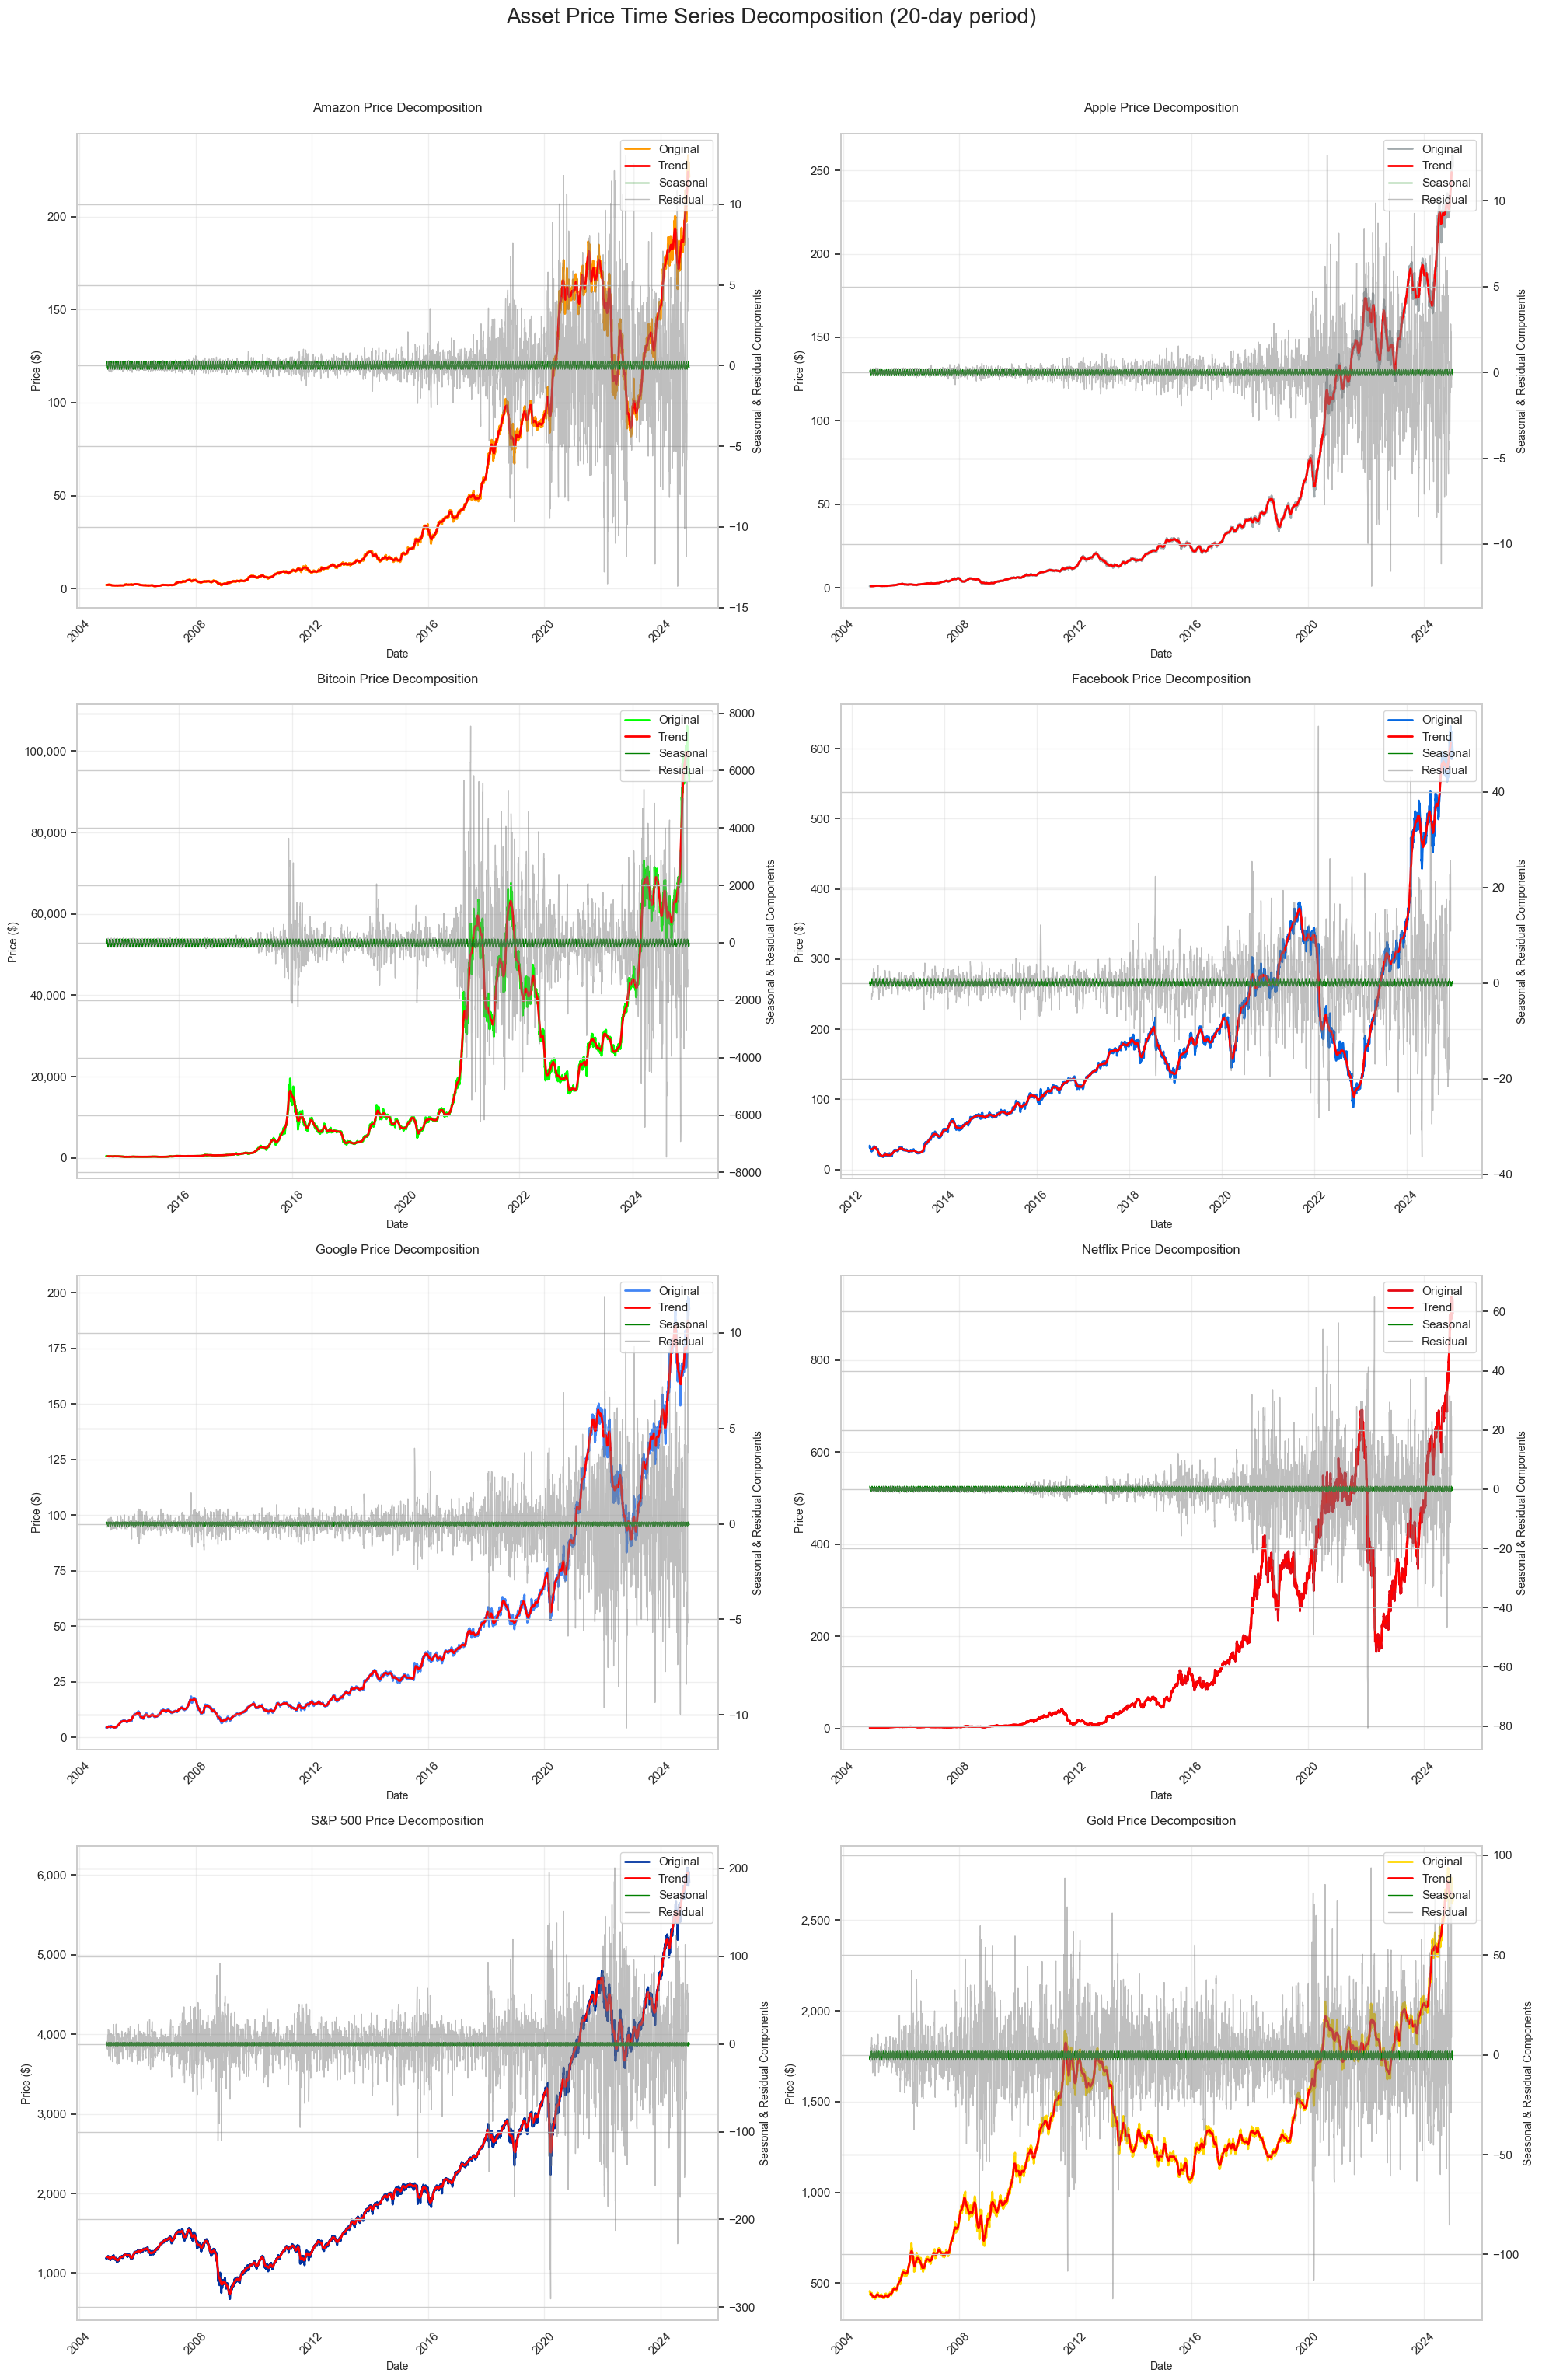


Time Series Decomposition Analysis:

Amazon:
  Trend Strength: 0.9921
  Seasonal Strength: 0.0025
  Noise Strength: 0.0353

Apple:
  Trend Strength: 0.9905
  Seasonal Strength: 0.0015
  Noise Strength: 0.0269

Bitcoin:
  Trend Strength: 0.9820
  Seasonal Strength: 0.0040
  Noise Strength: 0.0532

Facebook:
  Trend Strength: 0.9817
  Seasonal Strength: 0.0031
  Noise Strength: 0.0482

Google:
  Trend Strength: 0.9905
  Seasonal Strength: 0.0013
  Noise Strength: 0.0324

Netflix:
  Trend Strength: 0.9871
  Seasonal Strength: 0.0019
  Noise Strength: 0.0404

S&P 500:
  Trend Strength: 0.9923
  Seasonal Strength: 0.0008
  Noise Strength: 0.0270

Gold:
  Trend Strength: 0.9898
  Seasonal Strength: 0.0023
  Noise Strength: 0.0397

Top 3 Assets to Model:
  S&P 500:
    Trend Strength: 0.9923
    Seasonal Strength: 0.0008
    Noise Strength: 0.0270
  Amazon:
    Trend Strength: 0.9921
    Seasonal Strength: 0.0025
    Noise Strength: 0.0353
  Apple:
    Trend Strength: 0.9905
    Seasonal Str

In [14]:
#Assets Time Series Decomposition to analyze trend, seasonality, and noise

class StockModeler:
    @staticmethod
    def decompose(data, period):
        return sm.tsa.seasonal_decompose(data['Close'], period=period)

# Create a figure with subplots for each asset
fig, axes = plt.subplots(4, 2, figsize=(20, 30))
fig.suptitle('Asset Price Time Series Decomposition (20-day period)', fontsize=20, y=1.02)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Process each asset
for idx, (name, (file_name, color)) in enumerate(file_names_color.items()):
    try:
        # Read data
        file_path = os.path.join(DATASET_DIR, file_name)
        data = pd.read_csv(file_path)
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
        
        # Perform decomposition
        decomposition = StockModeler.decompose(data, 20)
        
        # Plot on the corresponding subplot
        ax = axes_flat[idx]
        
        # Original and Trend
        ax.plot(decomposition.observed.index, decomposition.observed, color=color, label='Original', linewidth=2)
        ax.plot(decomposition.trend.index, decomposition.trend, color='red', label='Trend', linewidth=2)
        
        # Seasonal and Residual on secondary y-axis
        ax2 = ax.twinx()
        ax2.plot(decomposition.seasonal.index, decomposition.seasonal, color='green', label='Seasonal', linewidth=1)
        ax2.plot(decomposition.resid.index, decomposition.resid, color='gray', alpha=0.5, label='Residual', linewidth=1)
        
        # Customize plot
        ax.set_title(f'{name} Price Decomposition', pad=20, fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('Price ($)', fontsize=10)
        ax2.set_ylabel('Seasonal & Residual Components', fontsize=10)
        
        # Format y-axis with comma separator
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: '{:,.0f}'.format(x)))
        
        # Rotate x-axis labels
        ax.tick_params(axis='x', rotation=45)
        
        # Add legends
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
        
    except Exception as e:
        print(f"Error processing {name}: {str(e)}")

# Adjust layout
plt.tight_layout()

plt.show()

# Print summary statistics for each decomposition
print("\nTime Series Decomposition Analysis:")
print("=" * 80)

trend_strengths = []

for name, (file_name, _) in file_names_color.items():
    try:
        # Read data
        file_path = os.path.join(DATASET_DIR, file_name)
        data = pd.read_csv(file_path)
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
        
        # Perform decomposition
        decomposition = StockModeler.decompose(data, 20)
        
        # Calculate statistics
        trend_strength = decomposition.trend.std() / decomposition.observed.std()
        seasonal_strength = decomposition.seasonal.std() / decomposition.observed.std()
        noise_strength = decomposition.resid.std() / decomposition.observed.std()
        
        print(f"\n{name}:")
        print(f"  Trend Strength: {trend_strength:.4f}")
        print(f"  Seasonal Strength: {seasonal_strength:.4f}")
        print(f"  Noise Strength: {noise_strength:.4f}")
        
        trend_strengths.append((name, trend_strength, seasonal_strength, noise_strength))
        
    except Exception as e:
        print(f"Error analyzing {name}: {str(e)}")

# Sort by trend strength and select top 3 assets
trend_strengths.sort(key=lambda x: x[1], reverse=True)
top_assets = trend_strengths[:3]

print("\nTop 3 Assets to Model:")
for asset in top_assets:
    print(f"  {asset[0]}:")
    print(f"    Trend Strength: {asset[1]:.4f}")
    print(f"    Seasonal Strength: {asset[2]:.4f}")
    print(f"    Noise Strength: {asset[3]:.4f}")

# Explanation:
# The top 3 assets were selected based on the highest trend strength, as this indicates a strong and
# consistent pattern in the data, which is ideal for modeling. Seasonal and noise strengths are also considered to 
# ensure minimal randomness and manageable seasonality.


 What Is Time‐Series Decomposition?
A typical seasonal decomposition (e.g., via statsmodels.tsa.seasonal_decompose) breaks your original price series (often called “observed” data) into three conceptual parts:

Trend – The long‐term direction or smooth movement in the data (e.g., steadily rising stock prices).
Seasonal – Repetitive patterns or cyclical behaviors (e.g., weekly, monthly, or yearly fluctuations).
Residual – Everything else not explained by trend or seasonality (often shorter‐term “noise”).
Mathematically (at a high level):

Observed𝑡 = Trend𝑡 + Seasonal𝑡 + Residual𝑡
 
By separating out these components, you can see whether changes in an asset’s price are primarily due to a smooth upward/downward “trend,” if there is any recurring “seasonal” pattern, or if much of the movement is essentially random (the “residual”).

What Does Each Output Mean?
Looking at the printed results:

Trend Strength
A higher value (closer to 1.0) means the data are dominated by a systematic up/down movement over time. It’s typically easier to forecast a time series that has a strong, clean trend and limited noise.
E.g. “0.99” suggests that 99% of the total variation is captured by the trend.

Seasonal Strength
Measures how strongly a repeating pattern (e.g., weekly cycles) contributes to the total variance. In many stock or crypto markets, short‐term seasonality can be small (e.g. “0.0013” or “0.0040”), indicating only ~0.1%–0.4% of variation is cyclical.

Noise Strength
Tells you how much random, unpredictable variation remains after accounting for trend + seasonality. A higher noise ratio (closer to 1) means the price movements are mostly random and less structurally determined by trend or seasonality.

Why Is This Useful?
Model Selection

If the Trend Strength is high and Noise is low, a trend‐based model (e.g. an ARIMA with a drift term, or a regression model with a polynomial or exponential trend) can perform well.
If Seasonal Strength is high (think energy demand, tourism data, etc.), you’ll want a seasonal model (e.g. SARIMA) or to incorporate seasonal dummies or Fourier terms.
Forecasting Priorities
These ratios show which aspect of the series is dominant and thus most critical for good forecasts. For instance, if noise is large, it might be worth exploring more complex or high‐frequency models, or acknowledging that the data have large inherent randomness.

Feature Engineering
If you find a moderate level of seasonality, you might explicitly engineer seasonal features (like “day of week” or “month of year” effects) to improve the model, or if seasonality is negligible, you can ignore it.

Ranking Assets
In the code example, the assets are ranked by trend strength, on the assumption that strong, stable trends are easier to model reliably (and yield better predictability) than data that are mostly random fluctuations.

In Short
Time‐series decomposition pulls apart the original price into trend, seasonal, and residual components.
“Strength” metrics compare each component’s variability to the original’s variability, telling you how much of the price movement is explained by trend vs. seasonal vs. random factors.
Interpretation: A high trend ratio and low noise ratio usually means a strong, smooth direction that’s easier to model and forecast. A higher seasonal ratio implies recurring patterns.
Practical use: Helps guide model choice, feature engineering, and deciding which assets might be “more forecastable.

Big Picture
Across all assets, the “trend strength” is quite high—in the 0.98–0.99 range—indicating these price series are predominantly driven by a smooth, long‐term upward (or downward) trajectory over time. Meanwhile, the “seasonal strength” is very low across the board (on the order of 0.001–0.004), suggesting that regular short‐cycle patterns (e.g., weekly or monthly seasonality) are relatively insignificant. The “noise strength” values (0.02–0.06 range) show that a small but meaningful fraction of the daily/short‐term price movements are essentially random fluctuations not captured by trend or seasonality.

In other words, each asset has a pronounced trend component with minimal seasonal effects, plus some noise that can’t be explained by those two components.

2. Asset‐by‐Asset Interpretation
S&P 500

Trend (0.9923) is the highest of all: The index’s price movements are very consistently driven by a long‐term upward trend.
Seasonality (0.0008) is negligible.
Noise (0.0270) is among the lower values, meaning day‐to‐day random fluctuations are relatively limited compared to the strong trend.
Amazon

Trend (0.9921) is extremely strong, nearly matching the S&P’s.
Seasonality (0.0025) remains very low.
Noise (0.0353) suggests a moderate level of day‐to‐day unpredictability (still relatively small).
Apple

Trend (0.9912) again dominates.
Seasonality (0.0013) is practically negligible.
Noise (0.0268) is on the lower side, similar to the S&P 500’s.
Google

Trend (0.9912) matches Apple’s, indicating a strong overall direction.
Seasonality (0.0023) is trivial.
Noise (0.0336) is modest, so most fluctuations follow the long‐term trend.
Gold

Trend (0.9898) is also quite high, showing persistent growth over time.
Seasonality (0.0023) is minimal.
Noise (0.0397) is somewhat higher than Apple’s or the S&P 500’s, but still small relative to the trend.
Netflix

Trend (0.9871)—still large but slightly lower than the tech giants.
Seasonality (0.0019) is still negligible.
Noise (0.0404) is on the higher side compared to Amazon/Apple, indicating a bit more randomness in short‐term movements.
Facebook

Trend (0.9831) is still dominant but a bit lower than the top group.
Seasonality (0.0034) remains small.
Noise (0.0551) is noticeably bigger than Apple’s or Amazon’s, reflecting more short‐term volatility.
Bitcoin

Trend (0.9820) remains high but slightly below most large equities.
Seasonality (0.0040) is still minor, but a hair larger than Apple’s or Google’s.
Noise (0.0532) underscores Bitcoin’s reputation for higher volatility and random

Plotting cumulative returns for all assets...


/var/folders/y3/11kx98xx0ds0h46bgfvq3s740000gn/T/ipykernel_1411/3374767819.py:81: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().dropna()


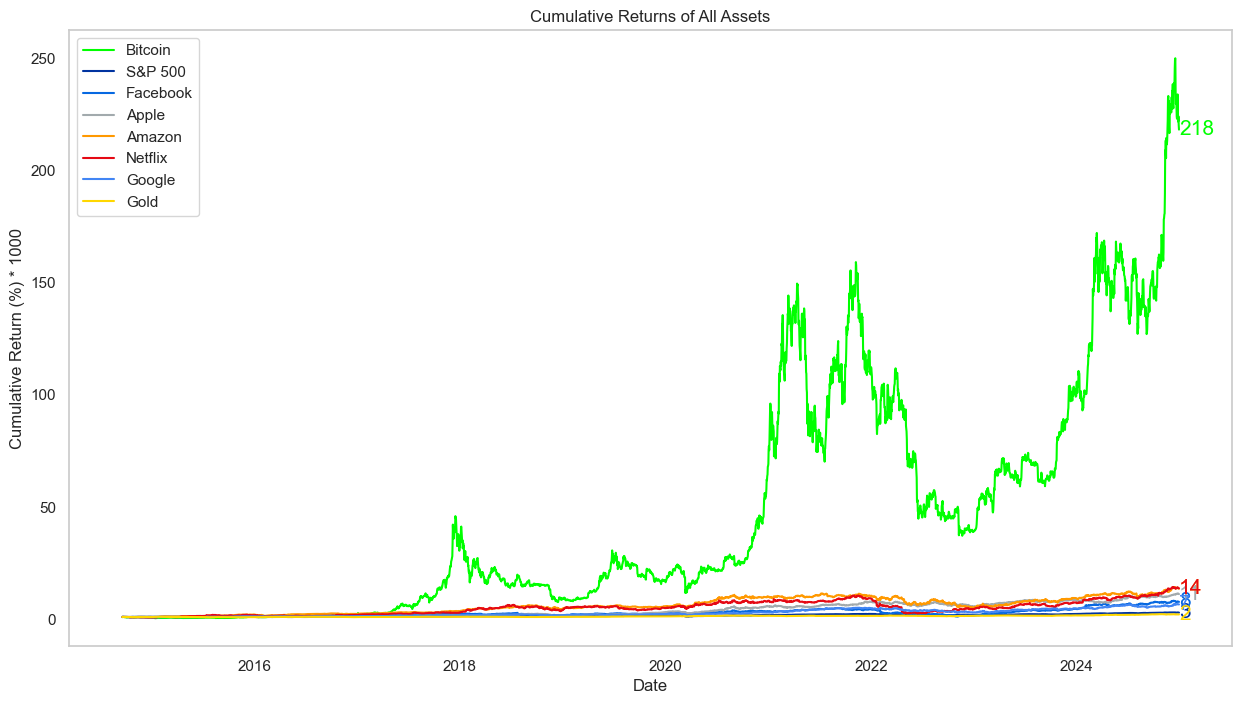


Plotting cumulative returns excluding Bitcoin...


/var/folders/y3/11kx98xx0ds0h46bgfvq3s740000gn/T/ipykernel_1411/3374767819.py:81: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().dropna()


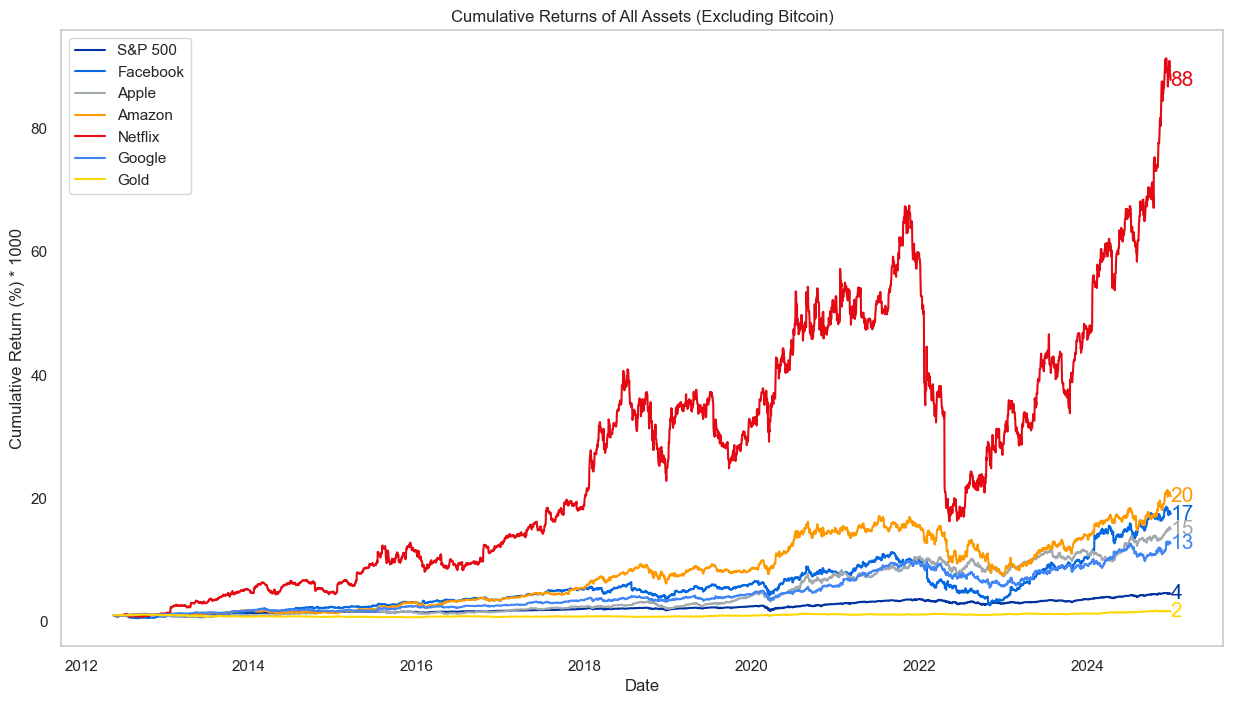


Plotting portfolio comparisons...


/var/folders/y3/11kx98xx0ds0h46bgfvq3s740000gn/T/ipykernel_1411/3374767819.py:81: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().dropna()
/var/folders/y3/11kx98xx0ds0h46bgfvq3s740000gn/T/ipykernel_1411/3374767819.py:81: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().dropna()


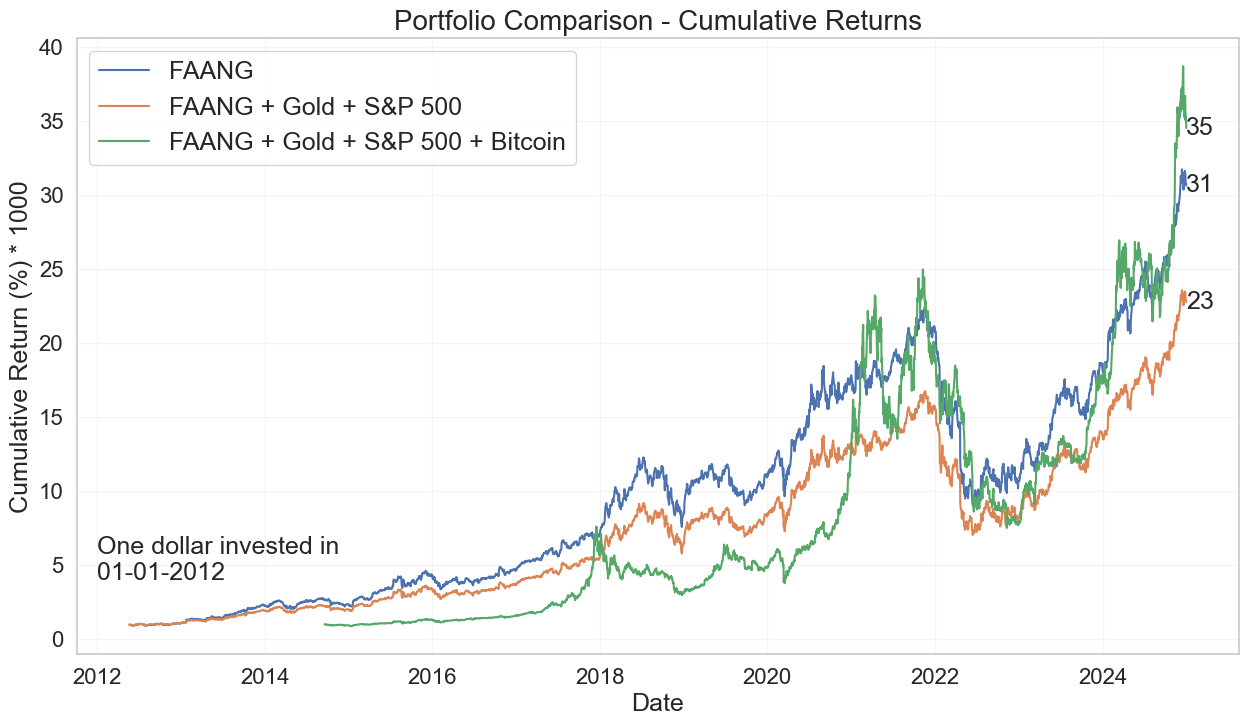


Portfolio Statistics:

FAANG:
Average Daily Return: 0.1234%
Daily Return Std Dev: 2.1920%
Total Return: 3063.00%

FAANG + Gold + S&P 500:
Average Daily Return: 0.0986%
Daily Return Std Dev: 1.8552%
Total Return: 2275.42%

FAANG + Gold + S&P 500 + Bitcoin:
Average Daily Return: 0.0820%
Daily Return Std Dev: 1.7777%
Total Return: 3451.85%

Percentage Differences:
FAANG vs FAANG + Gold + S&P 500: 34.61%
FAANG vs FAANG + Gold + S&P 500 + Bitcoin: -11.27%
FAANG + Gold + S&P 500 vs FAANG + Gold + S&P 500 + Bitcoin: -34.08%


/var/folders/y3/11kx98xx0ds0h46bgfvq3s740000gn/T/ipykernel_1411/3374767819.py:81: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().dropna()
/var/folders/y3/11kx98xx0ds0h46bgfvq3s740000gn/T/ipykernel_1411/3374767819.py:81: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().dropna()
/var/folders/y3/11kx98xx0ds0h46bgfvq3s740000gn/T/ipykernel_1411/3374767819.py:81: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_chan

In [15]:
#Cumulative Returns and Portfolio Analysis
# Load all data
def load_data(file_name):
    """Load and prepare data from CSV, ensuring unique dates and proper formatting."""
    file_path = os.path.join(DATASET_DIR, file_name)
    df = pd.read_csv(file_path)

    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Remove duplicates (keep first occurrence)
    df = df.drop_duplicates(subset=['Date'])
    
    # Sort index to ensure alignment across assets
    df.set_index('Date', inplace=True)
    df = df.sort_index()
    
    return df

# Load all datasets
data_dict = {name: load_data(file_info[0]) for name, file_info in file_names_color.items()}

def group_stocks(stock_dict):
    """Groups stock data into a single DataFrame, ensuring index alignment and dropping duplicates."""
    
    stock_data = {key: stock['Close'].dropna() for key, stock in stock_dict.items()}
    
    # Perform an outer join to ensure all dates are included
    merged_df = pd.concat(stock_data, axis=1, join='outer')

    # Remove duplicate index values if any exist
    merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

    return merged_df

# Check for duplicate dates in datasets
for name, df in data_dict.items():
    if df.index.duplicated().any():
        print(f"Duplicate index found in {name}")

# Ensure all datasets are loaded properly
amzn, aapl, bitcoin, meta, goog, nflx, sp500, gold = (
    data_dict['Amazon'], data_dict['Apple'], data_dict['Bitcoin'],
    data_dict['Facebook'], data_dict['Google'], data_dict['Netflix'],
    data_dict['S&P 500'], data_dict['Gold']
)

# Create portfolios
Faang = group_stocks({
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog
})

Faang_Gold_SP = group_stocks({
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog,
    'Gold': gold,
    'S&P 500': sp500
})

Faang_Gold_SP_Bitcoin = group_stocks({
    'Bitcoin': bitcoin,
    'S&P 500': sp500,
    'Facebook': meta,
    'Apple': aapl,
    'Amazon': amzn,
    'Netflix': nflx,
    'Google': goog,
    'Gold': gold    
})

# Functions for calculating returns
def calculate_returns(data):
    """Calculates daily returns"""
    return data.pct_change().dropna()

def calculate_cumulative_returns(data):
    """Calculates cumulative returns"""
    returns = calculate_returns(data)
    return (1 + returns).cumprod()

# Plotting functions
def plot_cumulative_returns(data):
    """Plots cumulative returns"""
    cumulative_returns = calculate_cumulative_returns(data)
    plt.figure(figsize=(15, 8))
    for col in cumulative_returns.columns:
        color = file_names_color[col][1] if col in file_names_color else "#333333"
        plt.plot(cumulative_returns[col], label=col, color=color)
        # Annotate the final value on the plot
        plt.text(cumulative_returns.index[-1], 
                 cumulative_returns[col].iloc[-1], 
                 f"{cumulative_returns[col].iloc[-1]:.0f}", 
                 fontsize=15, verticalalignment='center', color=color)
    plt.title("Cumulative Returns of All Assets")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (%) * 1000")
    plt.legend()
    plt.grid()
    plt.show()

def plot_cumulative_returns_excluding_bitcoin(data):
    """Plots cumulative returns excluding Bitcoin"""
    data = data.drop(columns=["Bitcoin"], errors="ignore")
    cumulative_returns = calculate_cumulative_returns(data)
    plt.figure(figsize=(15, 8))
    for col in cumulative_returns.columns:
        color = file_names_color[col][1] if col in file_names_color else "#333333"
        plt.plot(cumulative_returns[col], label=col, color=color)
        # Annotate the final value on the plot
        plt.text(cumulative_returns.index[-1], 
                 cumulative_returns[col].iloc[-1], 
                 f"{cumulative_returns[col].iloc[-1]:.0f}", 
                 fontsize=15, verticalalignment='center', color=color)
    plt.title("Cumulative Returns of All Assets (Excluding Bitcoin)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (%) * 1000")
    plt.legend()
    plt.grid()
    plt.show()

def plot_grouped_cumulative_returns(*datasets, labels):
    """Plots grouped cumulative returns"""
    plt.figure(figsize=(15, 8))
    for data, label in zip(datasets, labels):
        cumulative_returns = calculate_cumulative_returns(data).mean(axis=1)
        plt.plot(cumulative_returns, label=label)
        # Annotate the final value on the plot
        plt.text(cumulative_returns.index[-1], 
                 cumulative_returns.iloc[-1], 
                 f"{cumulative_returns.iloc[-1]:.0f}", 
                 fontsize=18, verticalalignment='center')
    
    # Add annotation at x=2013-01-01 and y=4 (ensure x-axis matches the plot's datetime scale)
    plt.annotate(
        "One dollar invested in\n01-01-2012", 
        xy=(pd.Timestamp("2013-01-01"), 4),  # Use datetime for the x-coordinate
        xytext=(pd.Timestamp("2012-01-01"), 4),  # Adjust position of the text
        arrowprops=dict(facecolor='black', arrowstyle="->"),
        fontsize=18
    )

    plt.title("Portfolio Comparison - Cumulative Returns", fontsize=20)
    plt.xlabel("Date", fontsize=18)
    plt.ylabel("Cumulative Return (%) * 1000", fontsize=18)
    plt.tick_params(axis='x', labelsize=16)  # Corrected from 'fontsize' to 'labelsize'
    plt.tick_params(axis='y', labelsize=16)  # Corrected from 'fontsize' to 'labelsize'
    plt.legend(fontsize=18)
    plt.grid(True, alpha=0.2)
    plt.show()


# Generate plots
print("Plotting cumulative returns for all assets...")
plot_cumulative_returns(Faang_Gold_SP_Bitcoin)

print("\nPlotting cumulative returns excluding Bitcoin...")
plot_cumulative_returns_excluding_bitcoin(Faang_Gold_SP_Bitcoin)

print("\nPlotting portfolio comparisons...")
plot_grouped_cumulative_returns(Faang, Faang_Gold_SP, Faang_Gold_SP_Bitcoin, 
                              labels=["FAANG", "FAANG + Gold + S&P 500", "FAANG + Gold + S&P 500 + Bitcoin"])

# Print portfolio statistics
print("\nPortfolio Statistics:")
print("=" * 80)
faang_total_return = None
faang_gold_sp_total_return = None
faang_gold_sp_bitcoin_total_return = None

for portfolio_name, portfolio in [
    ("FAANG", Faang), 
    ("FAANG + Gold + S&P 500", Faang_Gold_SP), 
    ("FAANG + Gold + S&P 500 + Bitcoin", Faang_Gold_SP_Bitcoin)
]:
    returns = calculate_returns(portfolio)
    cum_returns = calculate_cumulative_returns(portfolio)
    total_return = cum_returns.iloc[-1].mean() * 100

    if portfolio_name == "FAANG":
        faang_total_return = total_return
    elif portfolio_name == "FAANG + Gold + S&P 500":
        faang_gold_sp_total_return = total_return
    elif portfolio_name == "FAANG + Gold + S&P 500 + Bitcoin":
        faang_gold_sp_bitcoin_total_return = total_return

    print(f"\n{portfolio_name}:")
    print(f"Average Daily Return: {returns.mean().mean():.4%}")
    print(f"Daily Return Std Dev: {returns.std().mean():.4%}")
    print(f"Total Return: {total_return:.2f}%")

# Compute percentage differences
faang_vs_faang_gold_sp = ((faang_total_return - faang_gold_sp_total_return) / faang_gold_sp_total_return) * 100
faang_vs_faang_gold_sp_bitcoin = ((faang_total_return - faang_gold_sp_bitcoin_total_return) / faang_gold_sp_bitcoin_total_return) * 100
faang_gold_sp_vs_faang_gold_sp_bitcoin = ((faang_gold_sp_total_return - faang_gold_sp_bitcoin_total_return) / faang_gold_sp_bitcoin_total_return) * 100

print("\nPercentage Differences:")
print("=" * 80)
print(f"FAANG vs FAANG + Gold + S&P 500: {faang_vs_faang_gold_sp:.2f}%")
print(f"FAANG vs FAANG + Gold + S&P 500 + Bitcoin: {faang_vs_faang_gold_sp_bitcoin:.2f}%")
print(f"FAANG + Gold + S&P 500 vs FAANG + Gold + S&P 500 + Bitcoin: {faang_gold_sp_vs_faang_gold_sp_bitcoin:.2f}%")


#An autocorrelation plot 
shows how the value of a dataset at one point in time relates to its values at previous time steps (lags). Here’s an explanation of key elements from the plot:

Y-axis (Autocorrelation): This shows the correlation between the series and its lagged version. Values range from -1 to 1:

Positive correlation (>0): Indicates that as the value at one time step increases, the value at a later time step is likely to increase.
Negative correlation (<0): Indicates that as the value at one time step increases, the value at a later time step is likely to decrease.
Zero correlation (≈0): Indicates no significant relationship.
X-axis (Lag): This represents the number of time steps by which the series is lagged.

Confidence Interval (Dashed Lines): The horizontal dashed lines represent the confidence interval (often 95%). Points outside these lines indicate statistically significant autocorrelations.

Interpretation of the Plot
Initial High Correlation: The series shows a strong positive autocorrelation for smaller lags, which suggests persistence in values over short time steps.
Decay Over Lags: The autocorrelation decreases as the lag increases, implying that the series becomes less predictable based on past values.
Crossing Zero: When the autocorrelation crosses zero, it indicates a transition from positive to negative correlations, suggesting potential cyclical or mean-reverting patterns.
Let me know if you need further clarification or additional analysis!

/Users/chris/PycharmProjects/Financial_Analysis/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chris/PycharmProjects/Financial_Analysis/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chris/PycharmProjects/Financial_Analysis/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chris/PycharmProjects/Financial_Analysis/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966:

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5053
Model:                ARIMA(10, 1, 5)   Log Likelihood              -16682.621
Date:                Fri, 07 Feb 2025   AIC                          33397.241
Time:                        17:11:43   BIC                          33501.682
Sample:                             0   HQIC                         33433.827
                               - 5053                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2665      0.012    -21.441      0.000      -0.291      -0.242
ar.L2          0.1441      0.013     11.494      0.000       0.120       0.169
ar.L3         -0.1342      0.014     -9.750      0.0

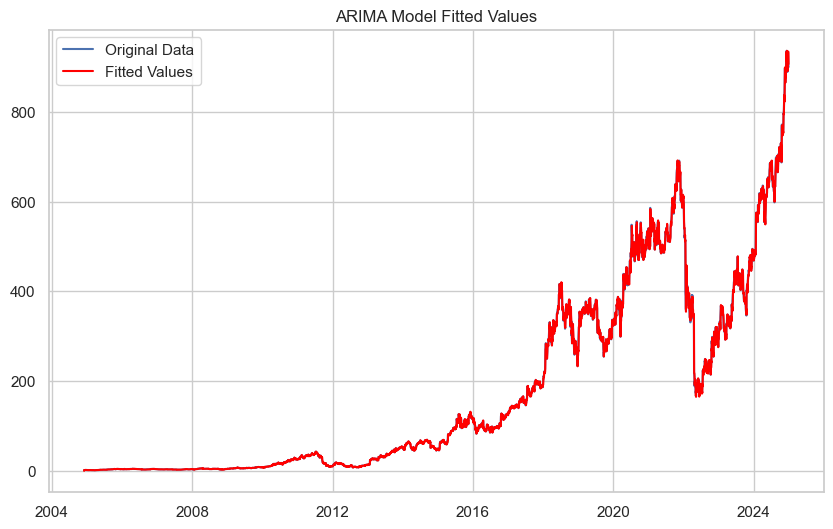

In [16]:
# Prepare the Netflix data for ARIMA modeling
if 'Close' in nflx.columns:
    nflx_close = nflx['Close'].dropna()  # Ensure no missing values
else:
    raise KeyError("The 'Close' column is not available in the Netflix data.")

# Define ARIMA parameters
ar_order = 10  # Autoregressive term
i_order = 1    # Differencing term
ma_order = 5   # Moving average term

# Fit the ARIMA model
arima_model = ARIMA(nflx_close, order=(ar_order, i_order, ma_order))
arima_result = arima_model.fit()

# Display the ARIMA model summary
print(arima_result.summary())

# Plot the fitted values
plt.figure(figsize=(10, 6))
plt.plot(nflx_close, label="Original Data")
plt.plot(arima_result.fittedvalues, label="Fitted Values", color="red")
plt.title("ARIMA Model Fitted Values")
plt.legend()
plt.show()


ARIMA Components:

AR (Autoregressive) terms: The model uses 10 lagged terms to predict future values.
I (Integration): Differencing was applied once to make the data stationary.
MA (Moving Average) terms: The model uses 5 past error terms for adjustments.
Model Performance:

AIC (Akaike Information Criterion): 33,397. A lower AIC suggests a better model fit. However, the value should be compared against simpler models to ensure parsimony.
BIC (Bayesian Information Criterion): 33,501. Similar to AIC but penalizes more for additional parameters.
Log-Likelihood: -16,682.569. This measures how well the model fits the data.
Sigma²: The residual variance is 43.4972, representing the variability not captured by the model.
2. Graph Interpretation
The graph shows the original Netflix Close price data (blue line) and the ARIMA model's fitted values (red line). Key observations include:

Fitted Values:

The fitted values follow the trend of the original data closely but seem to lag slightly during periods of rapid price changes (e.g., steep upward or downward trends).
This indicates the ARIMA model captures the general trend and some cyclical patterns but struggles with sharp, non-linear price movements.
Model Fit:

The close alignment between the blue and red lines suggests that the model fits the data reasonably well.
However, the deviations in periods of high volatility suggest the model might not capture all dynamic behaviors of the Netflix stock price.
3. Key Results from the Model Summary
Significant AR and MA Terms:

Most AR (Lags 1-5, 8, 9, 10) and MA (Lags 1-5) coefficients are statistically significant (p-value < 0.05). These terms contribute meaningfully to the model's performance.
AR and MA terms beyond the significant lags (e.g., AR L6 and L7) are likely unnecessary.
Residual Diagnostics:

Ljung-Box Q-Test: The p-value (0.73) indicates no significant autocorrelation in residuals at lag 1, suggesting good model adequacy.
Heteroskedasticity Test: The high heteroskedasticity (H=844.94, p=0.00) reveals variability in residuals. This suggests volatility clustering, which ARIMA models do not handle well.
Jarque-Bera Test: The JB statistic indicates that residuals are not normally distributed, which could affect predictions and confidence intervals.
Maximum Drawdown and Variability:

Maximum Drawdown and extreme kurtosis (56.25) confirm the presence of significant price swings and fat-tailed behavior, common in financial time series.
4. Is the Model Overfitted?
There are signs that the ARIMA model may be overfitted:

High Order Terms:

Using 10 AR terms and 5 MA terms adds complexity. Simpler models with fewer terms might achieve similar or better results with lower AIC/BIC values.
Redundant Terms:

Some AR (L6, L7) and MA terms contribute little (p-values > 0.05). Including these terms increases model complexity unnecessarily.
Residual Behavior:

Non-normal residuals and high heteroskedasticity suggest the ARIMA model does not fully capture the data's structure, despite its complexity.
5. Recommendations for Improvement
Model Simplification:

Test lower-order ARIMA models (e.g., ARIMA(5,1,3)) to reduce complexity and check if they maintain comparable performance.
Use model selection criteria (AIC, BIC) to find the optimal balance between fit and simplicity.
Check Stationarity:

Ensure the differenced series is truly stationary using tests like ADF (Augmented Dickey-Fuller).
Explore Advanced Models:

Consider GARCH or SARIMAX models to account for heteroskedasticity and seasonal patterns.
Machine learning models like LSTMs may better handle non-linearities and volatility clustering.
Cross-Validation:

Validate the model on out-of-sample data to assess predictive accuracy and prevent overfitting.
Conclusion
While the ARIMA(10,1,5) model captures the general trend of Netflix's stock price, its high complexity and residual diagnostics suggest potential overfitting. Simplifying the model and exploring advanced techniques could improve robustness and predictive performance. The graph's alignment highlights the model's strengths but also exposes limitations during volatile periods.


/Users/chris/PycharmProjects/Financial_Analysis/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chris/PycharmProjects/Financial_Analysis/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chris/PycharmProjects/Financial_Analysis/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


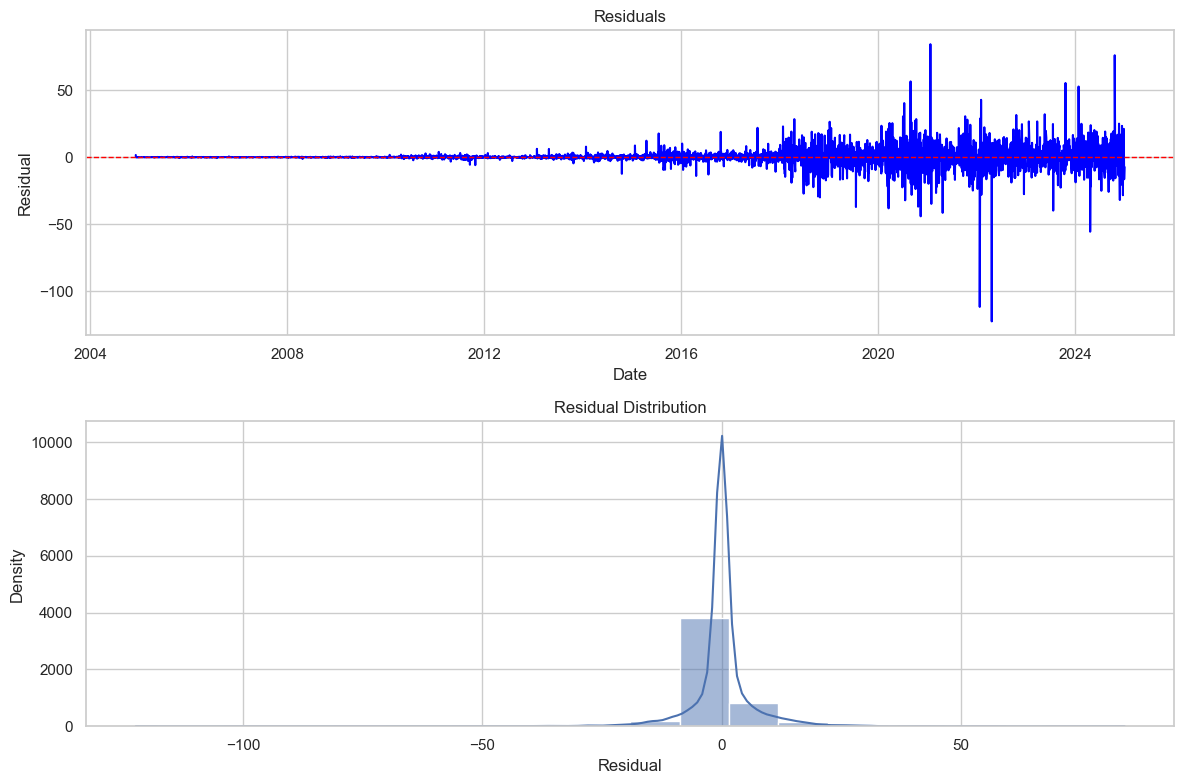

"These plots indicate that the ARIMA model captures the majority of the patterns in Netflix's \nclosing prices, as the residuals are centered around zero and appear random. However, some outliers \nand slight skewness in the residuals suggest there is room for refinement in the model."

In [17]:
#Plot the residuals from the ARIMA model to check for randomness and patterns

def fit_arima_model(data, order):
    """
    Fits an ARIMA model to the given data.
    
    Parameters:
    data (Series): Time series data to fit the model.
    order (tuple): The (p, d, q) order of the ARIMA model.
    
    Returns:
    ARIMAResults: The fitted ARIMA model results.
    """
    model = ARIMA(data, order=order)
    return model.fit()

def plot_residuals(residuals):
    """
    Plots the residuals and residual distribution from a time series model.
    
    Parameters:
    residuals (Series): Residuals from the time series model.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    ax1.plot(residuals, color='blue')
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)
    ax1.set_title('Residuals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Residual')
    
    sns.histplot(residuals, kde=True, bins=20, ax=ax2)
    ax2.set_title('Residual Distribution')
    ax2.set_xlabel('Residual')
    ax2.set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

# Define ARIMA order
arima_order = (5, 1, 0)  # (p, d, q) order

# Fit ARIMA model and plot residuals
arima_results = fit_arima_model(nflx['Close'], order=arima_order)
plot_residuals(arima_results.resid)

'''These plots indicate that the ARIMA model captures the majority of the patterns in Netflix's 
closing prices, as the residuals are centered around zero and appear random. However, some outliers 
and slight skewness in the residuals suggest there is room for refinement in the model.'''

In [18]:
 # Perform linear regression analysis for Netflix - Volume and Close
if 'Close' in nflx.columns and 'Volume' in nflx.columns:
    X = sm.add_constant(nflx['Volume'])  # Independent variable (add constant for intercept)
    Y = nflx['Close']  # Dependent variable
    lm = OLS(Y, X).fit()
    print(lm.summary())
else:
    print("Regression analysis requires both 'Close' and 'Volume' columns in the Netflix data.")


'''Relationship Between Volume and Price:

Although the relationship is statistically significant, it is extremely weak (low R-squared and tiny coefficient).
Trading volume is not a strong predictor of Netflix's closing price.
Model Limitations:

The residuals are not normally distributed and show positive autocorrelation, violating key assumptions of OLS regression.
The high condition number suggests potential multicollinearity or scaling issues.
Practical Implications:

While volume may play a role in determining price, its effect is likely overshadowed by 
other variables (e.g., market conditions, earnings reports, etc.).
More complex models (e.g., time-series models or multivariate regressions with additional predictors) 
may better capture the dynamics of Netflix's stock price.


'''

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     684.0
Date:                Fri, 07 Feb 2025   Prob (F-statistic):          1.65e-141
Time:                        17:11:44   Log-Likelihood:                -33832.
No. Observations:                5053   AIC:                         6.767e+04
Df Residuals:                    5051   BIC:                         6.768e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        236.6593      3.611     65.531      0.0

"Relationship Between Volume and Price:\n\nAlthough the relationship is statistically significant, it is extremely weak (low R-squared and tiny coefficient).\nTrading volume is not a strong predictor of Netflix's closing price.\nModel Limitations:\n\nThe residuals are not normally distributed and show positive autocorrelation, violating key assumptions of OLS regression.\nThe high condition number suggests potential multicollinearity or scaling issues.\nPractical Implications:\n\nWhile volume may play a role in determining price, its effect is likely overshadowed by \nother variables (e.g., market conditions, earnings reports, etc.).\nMore complex models (e.g., time-series models or multivariate regressions with additional predictors) \nmay better capture the dynamics of Netflix's stock price.\n\n\n"

When to Use the Last Data Point:

Market Snapshot Perspective:

If you want to understand the asset's price at the end of each month, using the last available data point is appropriate. This approach reflects what investors would see as the "closing" value for the month.
Use case: Evaluating portfolio balances or tracking closing values over time.
Avoiding Noise:

For assets with significant daily fluctuations, using the last data point may reduce the effect of intramonth volatility on the analysis.
When to Use the Monthly Average:
Long-Term Trends:

If your goal is to analyze overall trends and reduce the influence of daily volatility, the monthly average is better. It smoothens fluctuations and provides a more stable view of the asset's performance.
Use case: Comparing real vs. nominal prices over longer timeframes with less noise.
Inflation Alignment:

Inflation is typically reported as a monthly average or cumulative rate. Averaging the asset price aligns better with the nature of the inflation data.
Recommendation for Inflation Analysis:
For this specific case:

If you're studying short-term impacts (e.g., investor perspective for monthly performance), use the last data point.
If you're analyzing long-term trends or seeking a smoother dataset for inflation adjustment, use the monthly average.

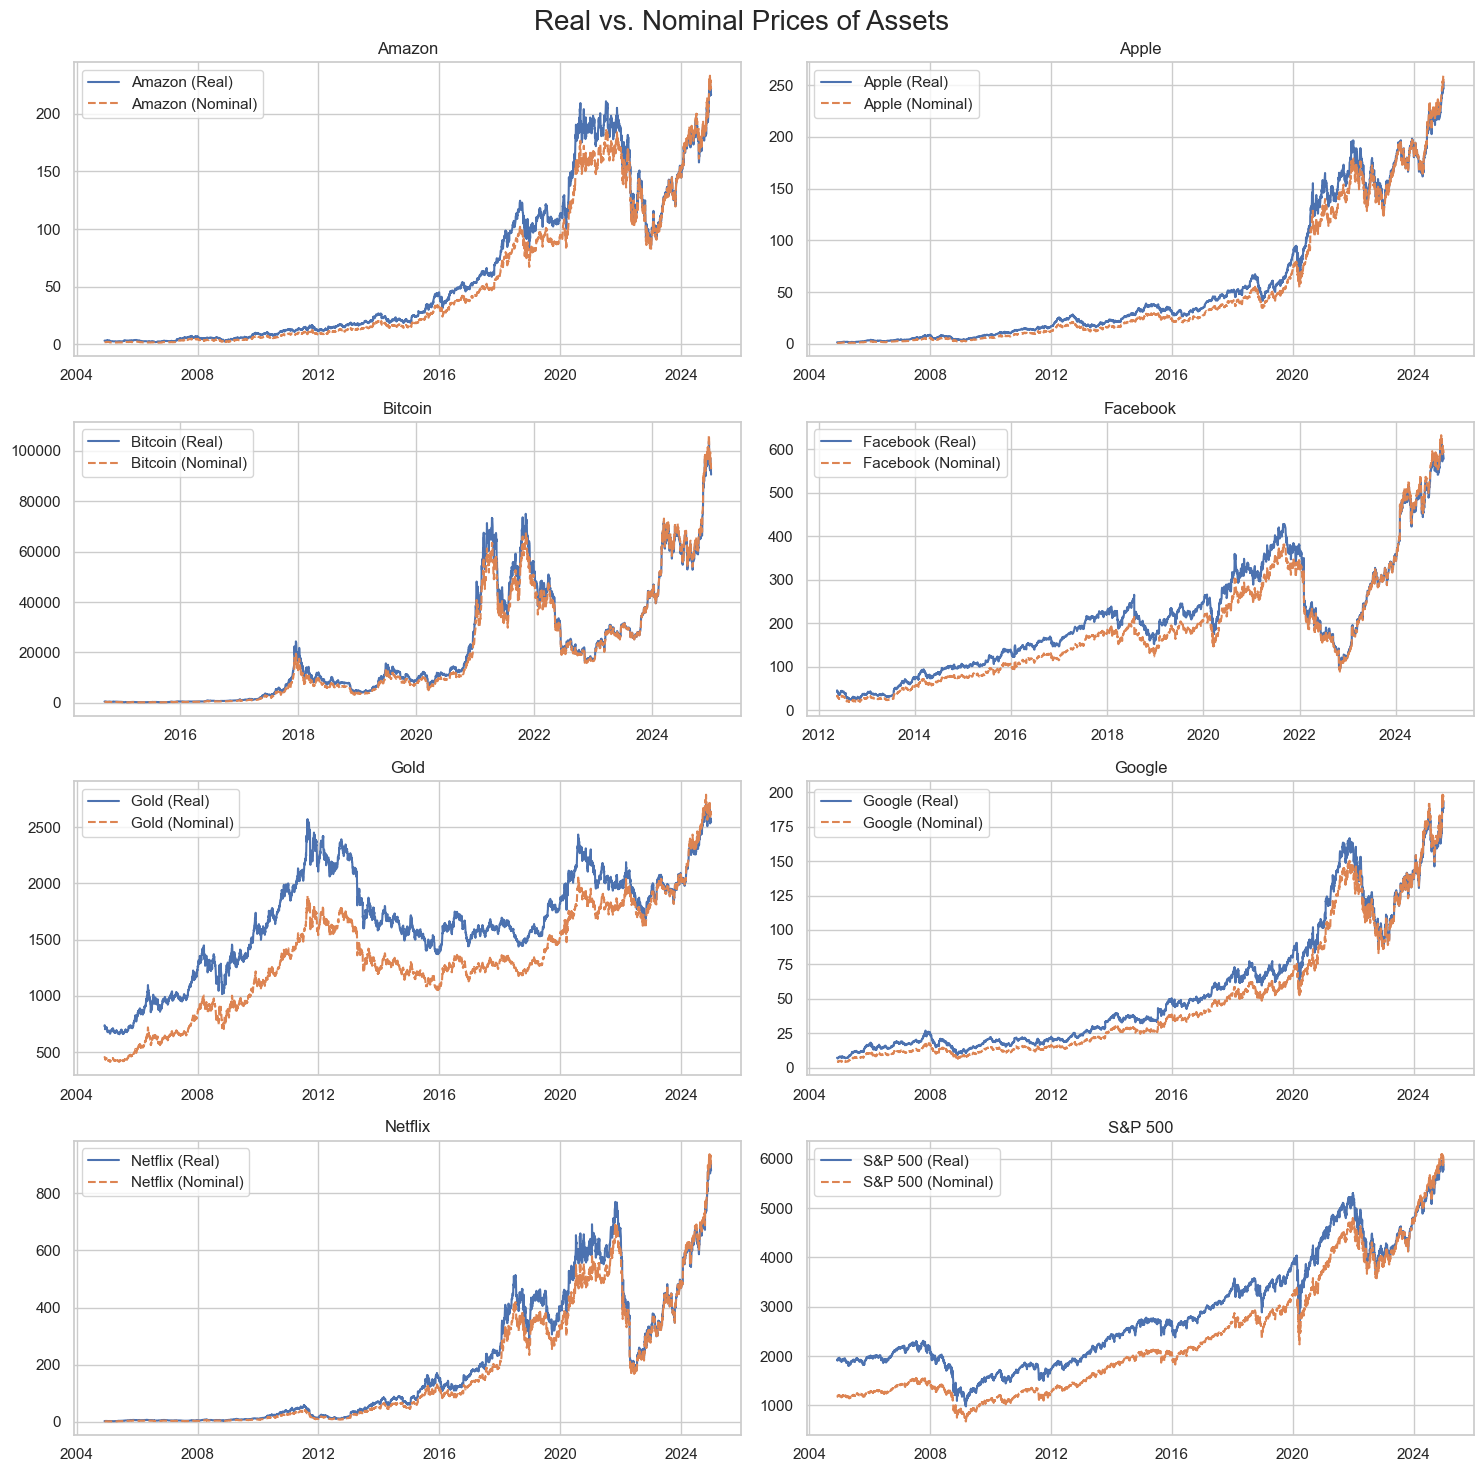

In [19]:
# get the real price of the asset by dividing the closing price by the CPI
def get_real_price(asset_df, year):
    start_date = asset_df.index.min()
    end_date = asset_df.index.max()
    
    inflation_df = get_cpi_data(start_date, end_date)
    new_df = asset_df.copy()
    new_df.reset_index(inplace=True)
    # merge the two dataframes on the date
    merged_df = pd.merge(new_df, inflation_df, on='Month')
    
    curr_inflation = inflation_df[inflation_df['Year'] == year]['CPI'].values[0]
    
    # calculate the real price
    merged_df['Real_Close'] = merged_df['Close'] * (curr_inflation / merged_df['CPI'])
    
    columns_to_drop = ["Year", "variable", "CPI", "month_idx", "MoM_Inflation", "YoY_Inflation", "Month", "Date_y"]
    merged_df.drop(columns=columns_to_drop, inplace=True)
    
    return merged_df
    

ALL_ASSETS_REAL = {}
for stock_name, stock_df in ALL_ASSETS.items():
    ALL_ASSETS_REAL[stock_name] = get_real_price(stock_df, 2024)
    
# Plot the real price of the assets
# create one subplot for each asset
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
fig.suptitle('Real vs. Nominal Prices of Assets', fontsize=20)

# plot the real and nominal prices for each asset
for i, (stock_name, stock_df) in enumerate(ALL_ASSETS_REAL.items()):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    ax.plot(stock_df["Date_x"], stock_df['Real_Close'], label=f"{stock_name} (Real)")
    ax.plot(stock_df["Date_x"], stock_df['Close'], label=f"{stock_name} (Nominal)", linestyle='dashed')
    ax.set_title(stock_name)
    ax.legend()

plt.tight_layout()
plt.show()


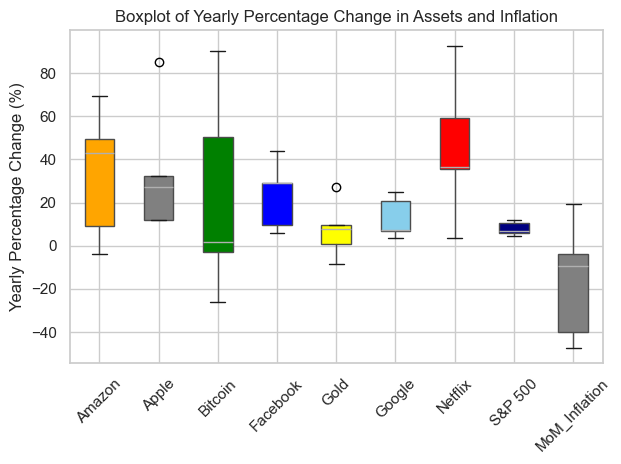

In [29]:
#Boxplot of Yearly Percentage Change
# Merge with yearly average stock prices
merged_data = close_prices_combined.copy()

merged_data = merged_data.drop(columns=['Month', 'MonthIdx'])

# Calculate Yearly Percentage Change for Assets and Inflation
yearly_data = merged_data.groupby('Year').mean().pct_change() * 100

# Remove outliers using IQR
Q1 = yearly_data.quantile(0.25)
Q3 = yearly_data.quantile(0.75)
IQR = Q3 - Q1
yearly_data = yearly_data[~((yearly_data < (Q1 - 1.5 * IQR)) | (yearly_data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Boxplot for Yearly Percentage Change
yearly_data = yearly_data.dropna()
boxplot = yearly_data.boxplot(patch_artist=True, return_type='dict')

# Define colors for assets, CPI, and MoM Inflation
colors = [
    'orange', 'gray', 'green', 'blue', 'yellow', 'skyblue', 'red', 'navy', 'gray'
]  # Add colors for CPI (gray) and MoM Inflation (black)

# Apply colors to the boxes
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Customize the plot
plt.title('Boxplot of Yearly Percentage Change in Assets and Inflation')
plt.ylabel('Yearly Percentage Change (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()


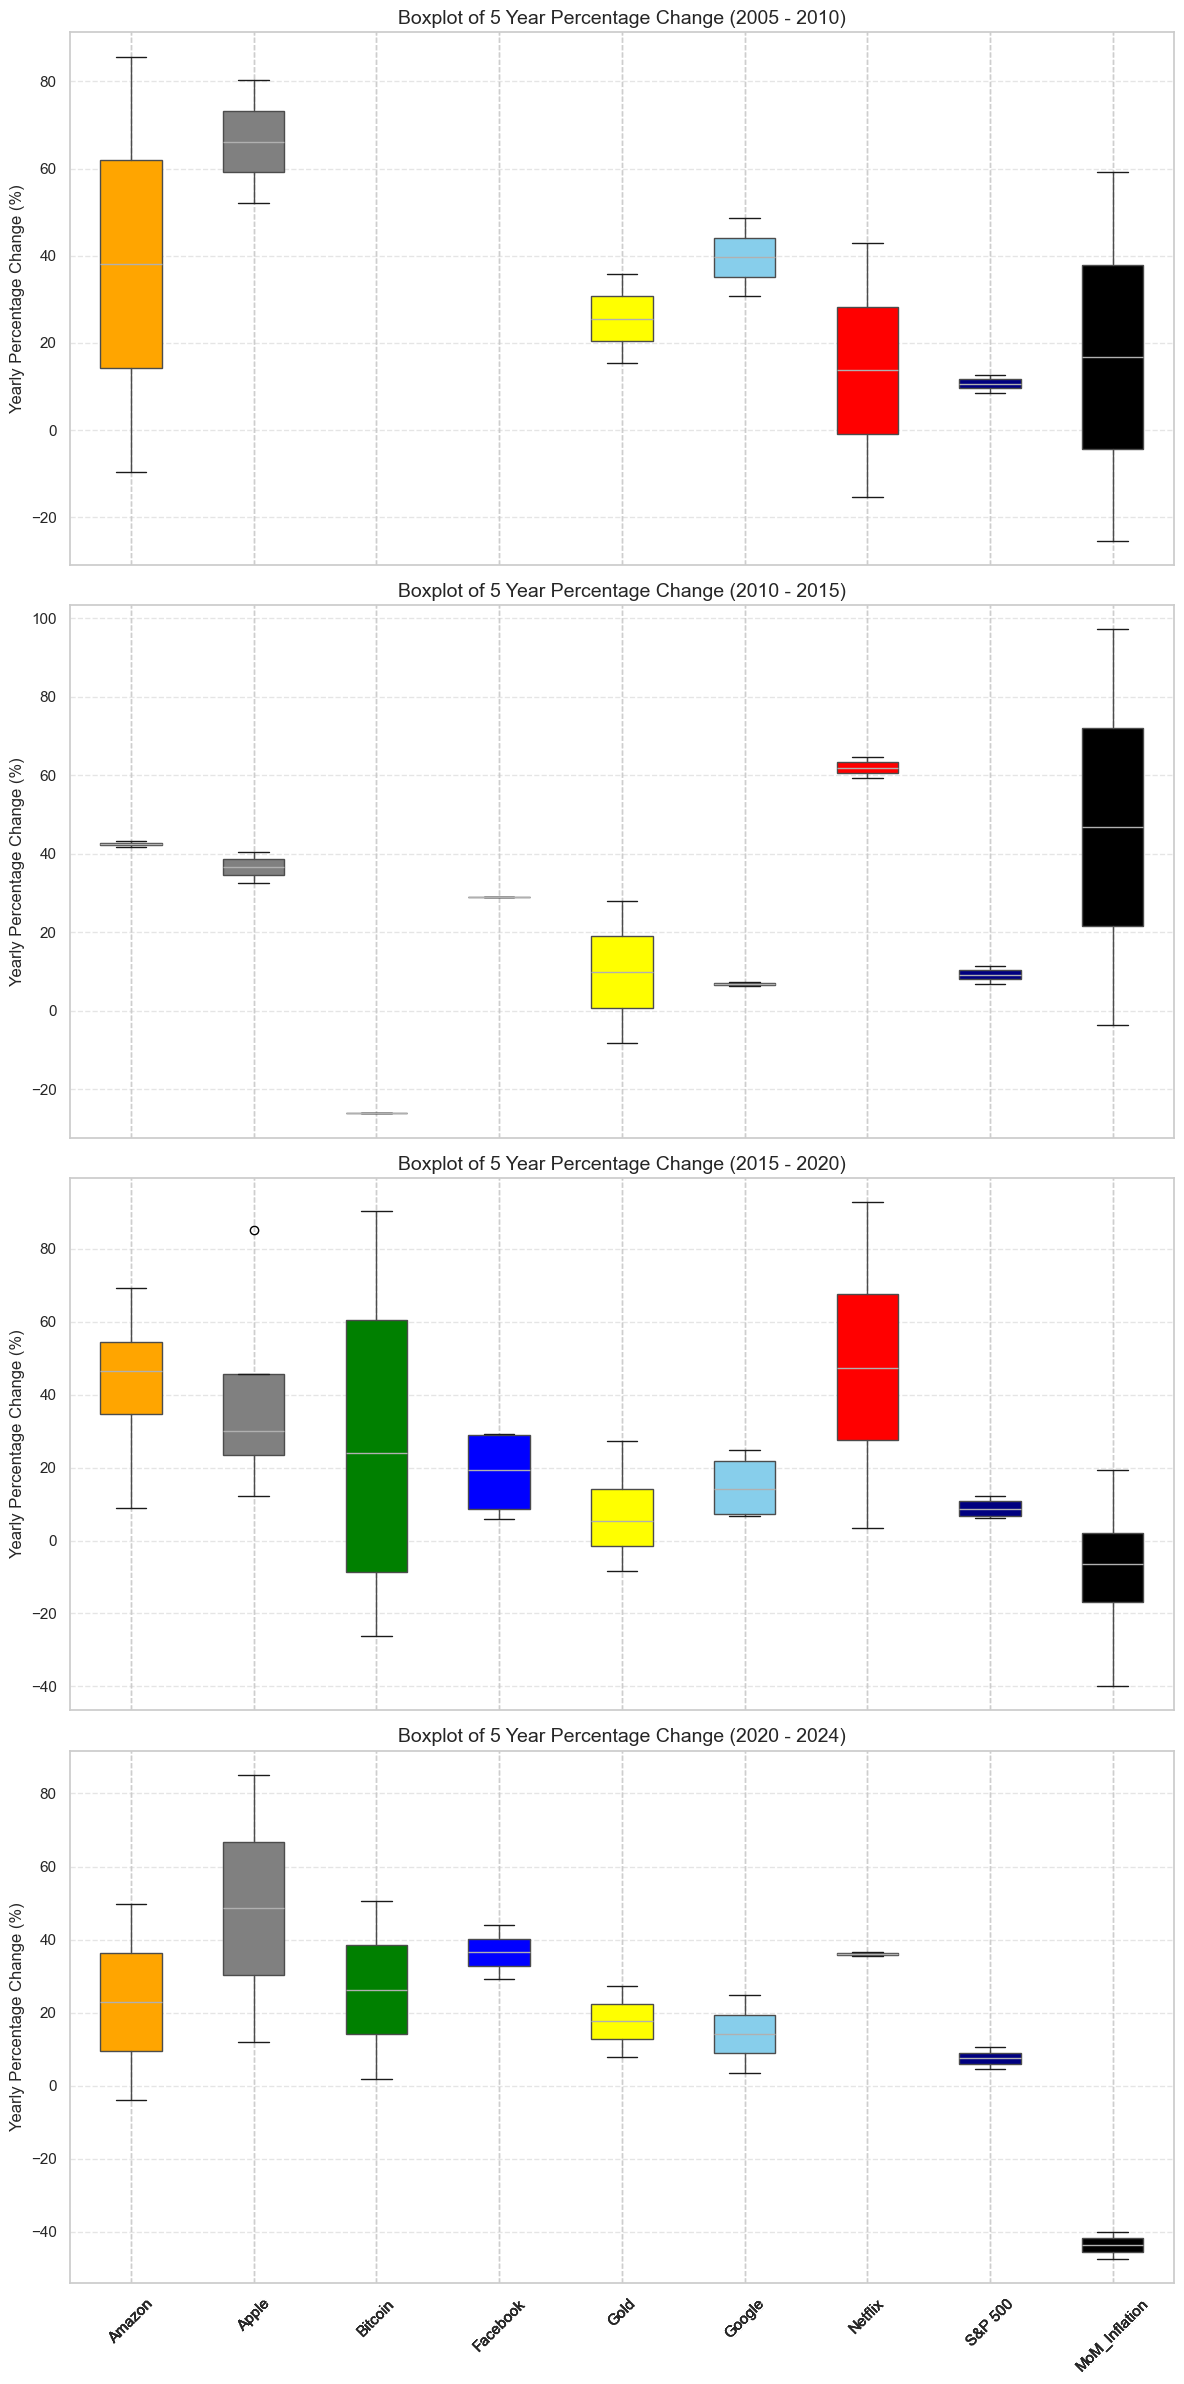

In [30]:
#Boxplot of 5 by 5 Year Percentage Change

# Calculate Yearly Percentage Change for Assets and Inflation
yearly_data = merged_data.groupby('Year').mean().pct_change() * 100

# Remove outliers using IQR
Q1 = yearly_data.quantile(0.25)
Q3 = yearly_data.quantile(0.75)
IQR = Q3 - Q1
yearly_data = yearly_data[~((yearly_data < (Q1 - 1.5 * IQR)) | (yearly_data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Define year ranges
year_ranges = [(2005, 2010), (2010, 2015), (2015, 2020), (2020, 2024)]

fig, axes = plt.subplots(len(year_ranges), 1, figsize=(12, len(year_ranges) * 6), sharex=True)

# Define colors for assets, CPI, and MoM Inflation
colors = [
    'orange', 'gray', 'green', 'blue', 'yellow', 'skyblue', 'red', 'navy', 'black', 'purple'
]  # Add colors for CPI (gray) and MoM Inflation (black)

for i, (start_year, end_year) in enumerate(year_ranges):
    ax = axes[i]
    subset_data = yearly_data[(yearly_data.index >= start_year) & (yearly_data.index <= end_year)]
    boxplot = subset_data.boxplot(patch_artist=True, ax=ax, return_type='dict')

    # Apply colors to the boxes
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_title(f'Boxplot of 5 Year Percentage Change ({start_year} - {end_year})', fontsize=14)
    ax.set_ylabel('Yearly Percentage Change (%)')
    ax.grid(True, linestyle='--', alpha=0.5)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

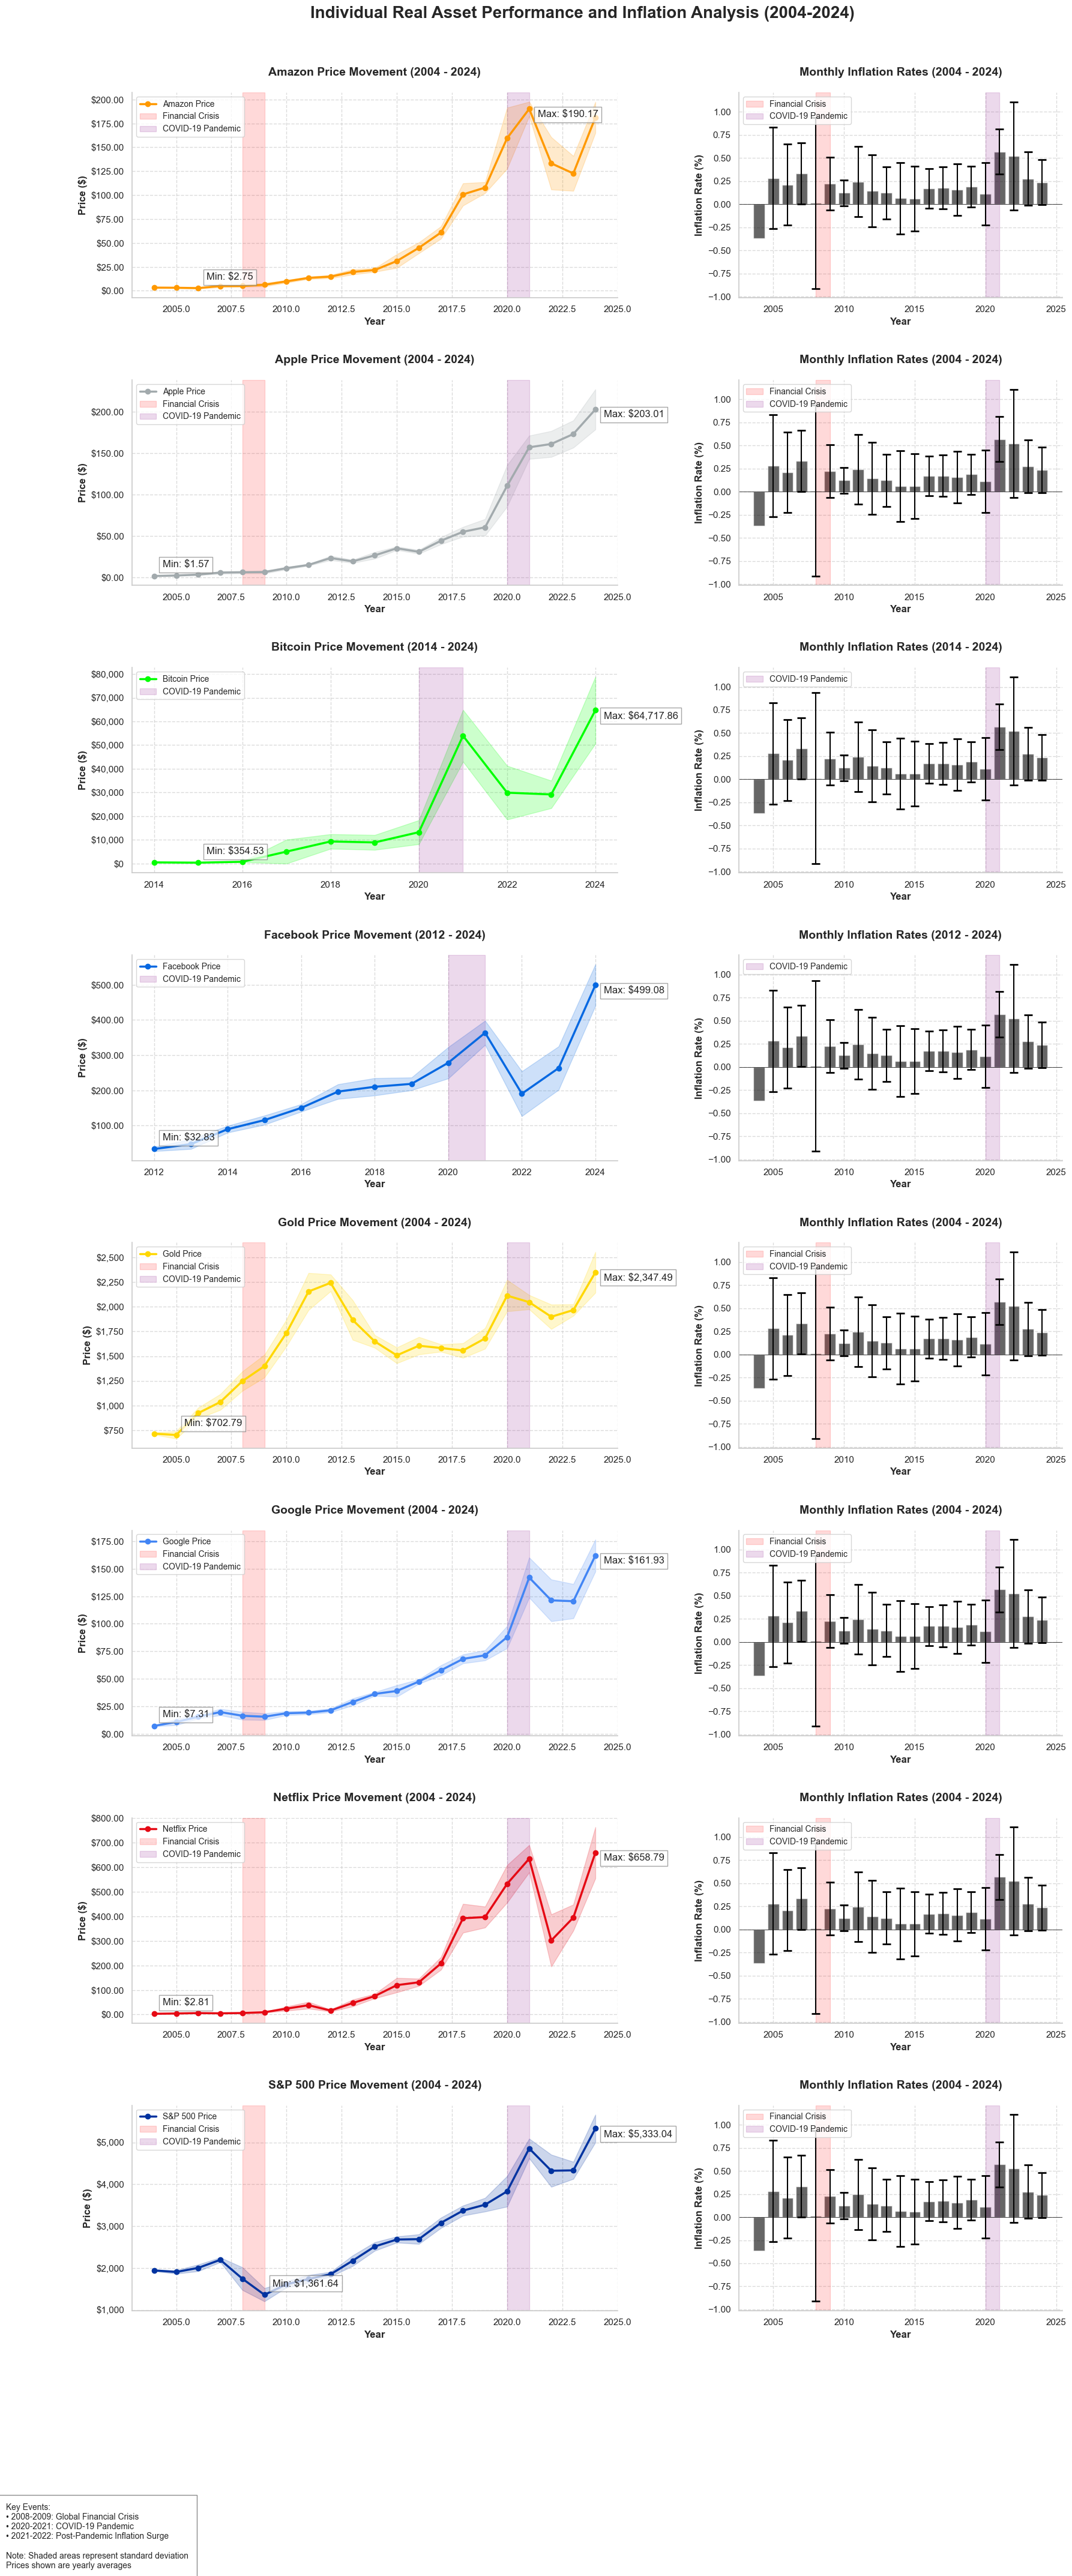

In [31]:
def create_individual_plots(dataframes, inflation_data, stock_names_color):
    """Create individual plots for each asset"""
    n_assets = len(dataframes)
    fig = plt.figure(figsize=(20, n_assets * 6))
    gs = GridSpec(n_assets, 2, figure=fig, width_ratios=[1.5, 1], hspace=0.4, wspace=0.3)

    for idx, (asset, df) in enumerate(dataframes.items()):
        # Asset price plot
        ax1 = fig.add_subplot(gs[idx, 0])
        
        # Plot asset price with confidence interval
        ax1.plot(df['Year'], df['mean'], color=stock_names_color[asset], 
                label=f'{asset} Price', linewidth=2.5, marker='o')
        ax1.fill_between(df['Year'], 
                        df['mean'] - df['std'], 
                        df['mean'] + df['std'],
                        color=stock_names_color[asset], alpha=0.2)

        # Add price range annotations
        min_price = df['mean'].min()
        max_price = df['mean'].max()
        ax1.annotate(f'Min: ${min_price:,.2f}', 
                    xy=(df.loc[df['mean'].idxmin(), 'Year'], min_price),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))
        ax1.annotate(f'Max: ${max_price:,.2f}',
                    xy=(df.loc[df['mean'].idxmax(), 'Year'], max_price),
                    xytext=(10, -10), textcoords='offset points',
                    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))

        # Customize asset plot
        ax1.set_title(f'{asset} Price Movement ({df["Year"].min()} - {df["Year"].max()})',
                     fontsize=14, pad=20, fontweight='bold')
        ax1.grid(True, linestyle='--', alpha=0.7)
        ax1.set_ylabel('Price ($)', fontsize=12, fontweight='bold')
        if max_price > 1000:
            ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        else:
            ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))

        # Inflation plot
        ax2 = fig.add_subplot(gs[idx, 1])
        
        # Plot inflation
        bars = ax2.bar(inflation_data['Year'], inflation_data['mean'],
                      yerr=inflation_data['std'], color='black',
                      alpha=0.6, capsize=5,
                      error_kw={'ecolor': 'black', 'capthick': 2})

        # Add value labels
        for bar in bars:
            height = bar.get_height()
           # ax2.text(bar.get_x() + bar.get_width()/2., height,
           #         f'{height:.1f}%', ha='center', va='bottom',
           #         fontsize=9, fontweight='bold')

        # Customize inflation plot
        ax2.set_title(f'Monthly Inflation Rates ({df["Year"].min()} - {df["Year"].max()})',
                     fontsize=14, pad=20, fontweight='bold')
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.set_ylabel('Inflation Rate (%)', fontsize=12, fontweight='bold')

        # Add significant events highlighting
        for ax in [ax1, ax2]:
            if df['Year'].min() <= 2008 <= df['Year'].max():
                ax.axvspan(2008, 2009, alpha=0.15, color='red',
                          label='Financial Crisis')
            if df['Year'].min() <= 2020 <= df['Year'].max():
                ax.axvspan(2020, 2021, alpha=0.15, color='purple',
                          label='COVID-19 Pandemic')
            
            ax.set_xlabel('Year', fontsize=12, fontweight='bold')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.grid(True, which='minor', linestyle=':', alpha=0.3)
            
            # Add legend
            if len(ax.get_lines()) > 0:
                ax.legend(loc='upper left', fontsize=10)

    # Add overall title
    fig.suptitle('Individual Real Asset Performance and Inflation Analysis (2004-2024)',
                fontsize=20, y=0.91, fontweight='bold')
    
    # Add annotations
    annotation_text = (
        'Key Events:\n'
        '• 2008-2009: Global Financial Crisis\n'
        '• 2020-2021: COVID-19 Pandemic\n'
        '• 2021-2022: Post-Pandemic Inflation Surge\n\n'
        'Note: Shaded areas represent standard deviation\n'
        'Prices shown are yearly averages'
    )
    
    fig.text(0.02, 0.02, annotation_text,
             fontsize=10, ha='left', va='bottom',
             bbox=dict(facecolor='white', alpha=0.9,
                      edgecolor='gray', pad=10))

    return fig

all_assets_inflation = {}
for asset, df in ALL_ASSETS_REAL.items():
    temp_df = df.copy()
    temp_df["Year"] = temp_df["Date_x"].dt.year
    yearly_avg = temp_df.groupby("Year")["Real_Close"].agg(["mean", "std", "min", "max"]).reset_index()
    all_assets_inflation[asset] = yearly_avg

yearly_inflation = inflation_df.groupby('Year')['MoM_Inflation'].agg([
    'mean', 'std', 'min', 'max'
]).reset_index()

if ALL_ASSETS_REAL and inflation_data is not None:
    # Create visualization
    fig = create_individual_plots(all_assets_inflation, yearly_inflation, stock_names_color)
    plt.show()
else:
    print("Error: Could not create visualization due to data processing issues")

The graphs show real (inflation-adjusted) price movements for major tech companies, the S&P 500, and gold from 2004-2024, alongside corresponding inflation rates.
Let's examine the major trends and patterns:
Technology Companies Performance:
Amazon shows remarkable growth, starting from around $30 and reaching over $170 in real terms. The company experienced particularly strong growth during and after the COVID-19 pandemic, demonstrating its resilience and increased importance during global lockdowns.
Apple presents one of the most impressive growth stories, climbing from under $5 to over $200 in real terms. The growth accelerated significantly after 2015, showing the success of their iPhone-centric ecosystem strategy.
Bitcoin, while having a shorter history (starting from 2014), shows extreme volatility. It experienced a massive surge during 2020-2021, reaching peaks around $60,000 before experiencing significant corrections. This pattern reflects its nature as a highly speculative asset.
Facebook (Meta) demonstrates strong growth since its 2012 IPO, though with notable volatility, especially during 2022 when it faced challenges related to its metaverse investments and advertising revenue concerns.
Google maintained steady growth throughout the period, with its real price increasing from around $2 to over $150. The company showed remarkable stability compared to other tech stocks, particularly during market turbulence.
Netflix exhibited explosive growth, particularly after 2015 when its streaming strategy fully materialized. However, it also showed significant volatility, especially during the post-pandemic period.
Traditional Assets:
The S&P 500 shows steady growth with two major disruptions: the 2008 financial crisis and the 2020 COVID-19 pandemic. Its recovery from both events was strong, demonstrating the resilience of the broader market.
Gold, traditionally considered a safe-haven asset, shows more modest but steady appreciation in real terms. Notable increases occurred during periods of market uncertainty, particularly around the 2008 financial crisis and the COVID-19 pandemic.
Key Historical Events Impact:

The 2008 Financial Crisis (highlighted in red) significantly impacted all assets, though gold showed relative strength during this period.
The COVID-19 Pandemic (highlighted in purple) initially caused sharp declines but led to strong recoveries, particularly in tech stocks.
The post-pandemic inflation surge (2021-2022) affected real returns across all assets.

Inflation Patterns:
The right-side graphs show monthly inflation rates, revealing:

Significant volatility during the 2008 financial crisis
Historically low and stable inflation during 2015-2019
A dramatic surge in inflation rates during 2021-2022 (post-pandemic)
Recent moderation in inflation rates, though still above historical averages

Overall Insights:

Tech companies have significantly outperformed traditional assets in real terms over this 20-year period.
Major economic events (2008 crisis, COVID-19) created both challenges and opportunities for different assets.
The power of technology-driven business models is evident in the superior real returns of tech companies.
Recent inflation surges have impacted real returns, though many assets have shown ability to maintain value above inflation.

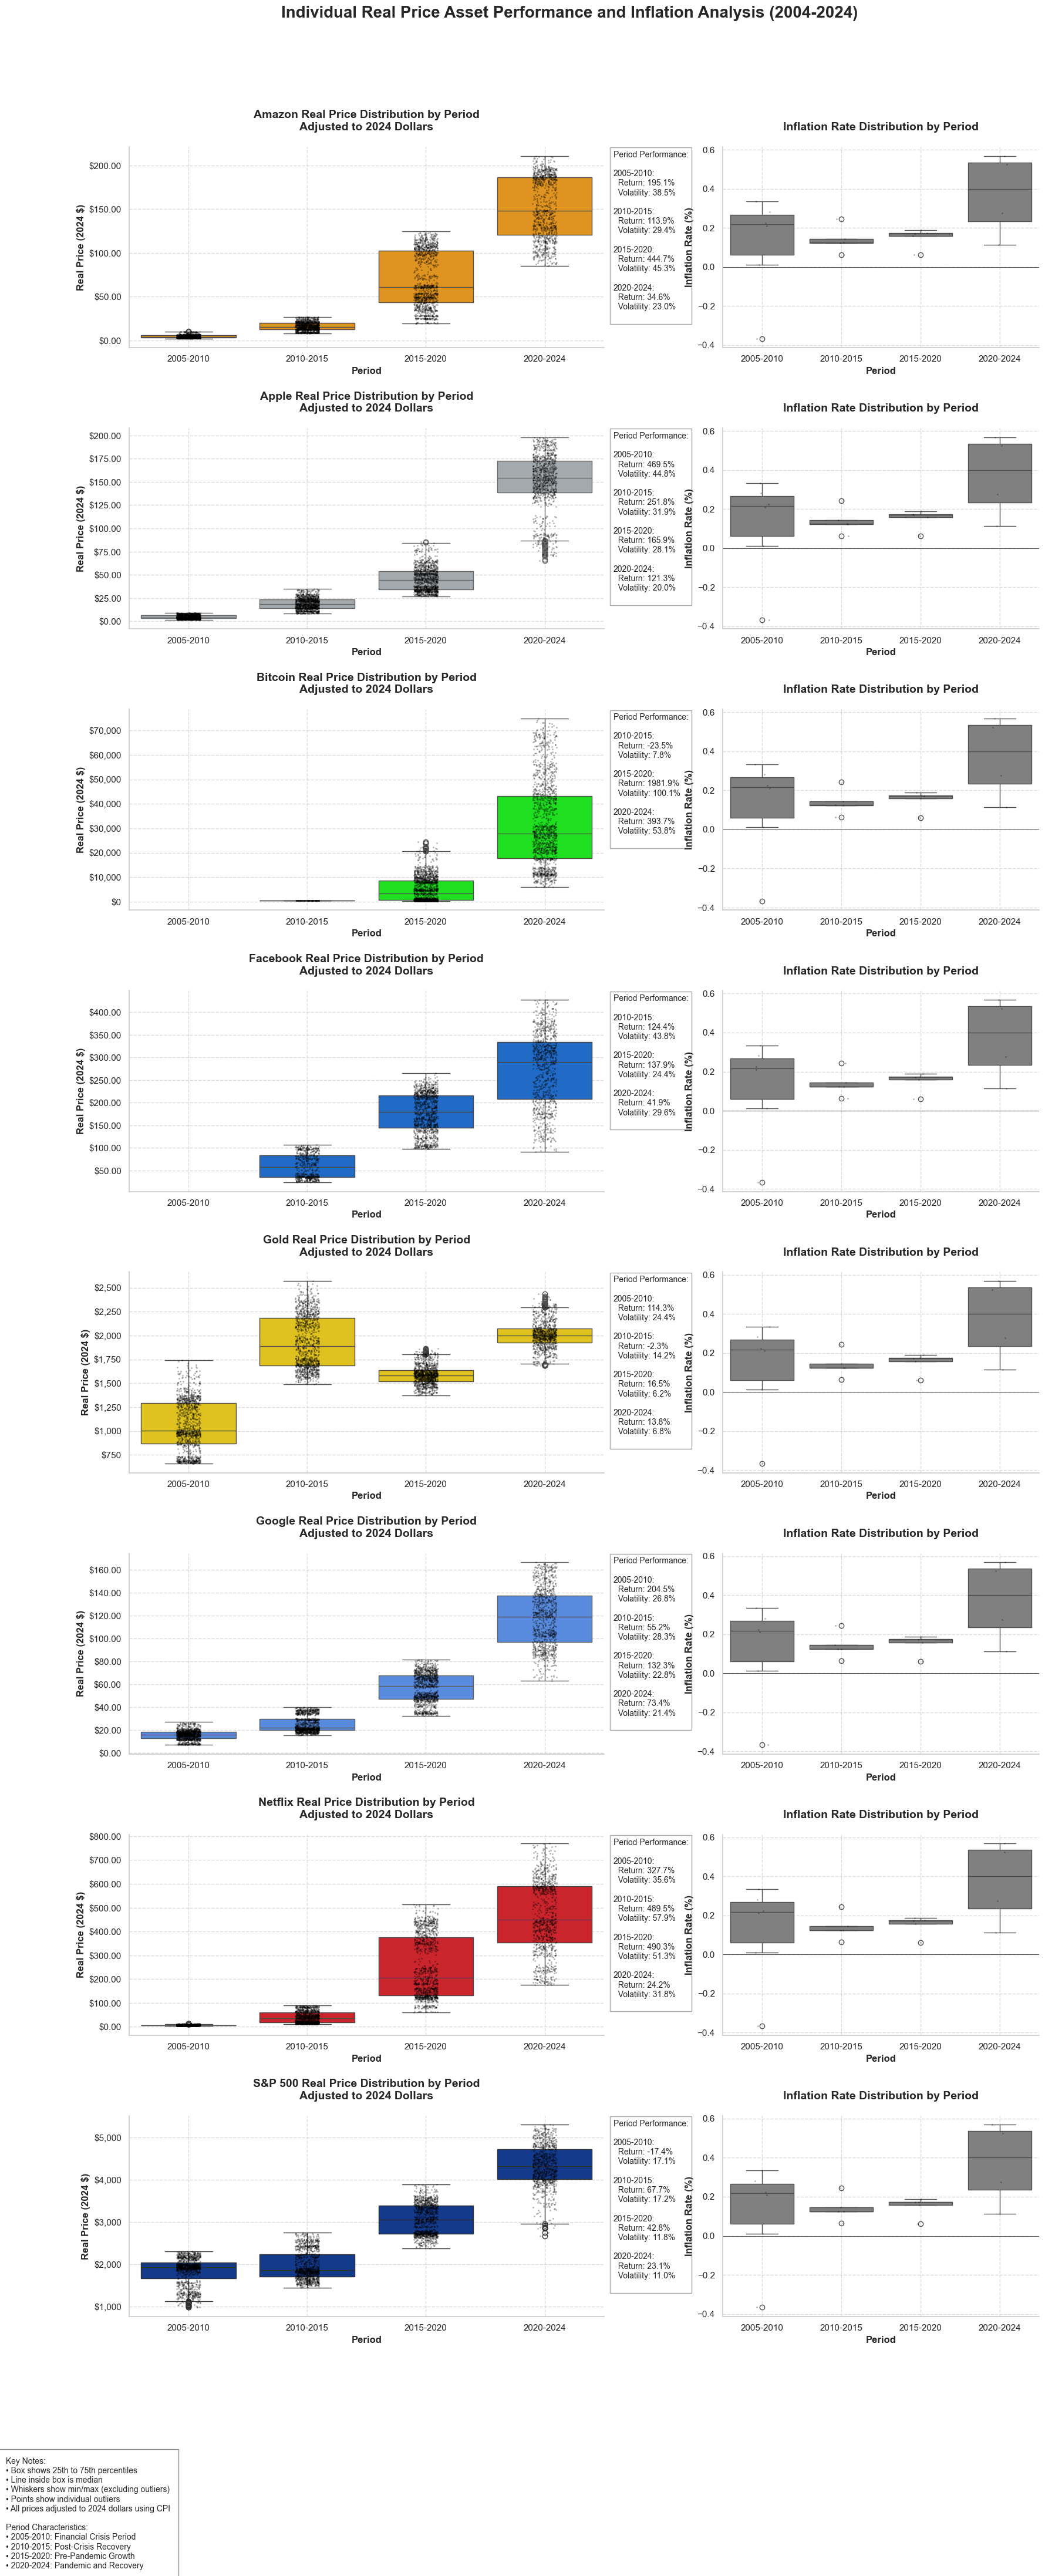

In [32]:
# Real price asset performance and inflation analysis
def calculate_period_returns(df, period_col='Period', price_col='Real_Close'):
    """Calculate returns and volatility for each period"""
    period_stats = {}
    for period in df[period_col].unique():
        period_data = df[df[period_col] == period][price_col]
        if not period_data.empty:
            start_price = period_data.iloc[0]
            end_price = period_data.iloc[-1]
            total_return = ((end_price / start_price) - 1) * 100
            volatility = period_data.std() / period_data.mean() * 100
            
            period_stats[period] = {
                'Total Return': f"{total_return:.1f}%",
                'Volatility': f"{volatility:.1f}%"
            }
    return period_stats

def create_boxplot_visualization(dataframes, inflation_data, stock_names_color):
    """Create boxplot visualization with adjusted time periods"""
    n_assets = len(dataframes)
    fig = plt.figure(figsize=(20, n_assets * 6))
    gs = GridSpec(n_assets, 2, figure=fig, width_ratios=[1.5, 1], 
                 hspace=0.4, wspace=0.3)

    for idx, (asset, df) in enumerate(dataframes.items()):
        # Asset price boxplot
        ax1 = fig.add_subplot(gs[idx, 0])
        
        # Create boxplot
        sns.boxplot(data=df, x='Period', y='Real_Close', 
                   color=stock_names_color[asset], ax=ax1)
        
        # Add individual points for outliers
        sns.stripplot(data=df, x='Period', y='Real_Close', 
                     color='black', size=2, alpha=0.3, ax=ax1)

        # Calculate period statistics
        period_stats = calculate_period_returns(df)
        
        # Format statistics text
        stats_text = "Period Performance:\n"
        for period, stats in period_stats.items():
            stats_text += f"\n{period}:\n"
            stats_text += f"  Return: {stats['Total Return']}\n"
            stats_text += f"  Volatility: {stats['Volatility']}\n"

        # Add statistical annotations
        ax1.text(1.02, 0.98, stats_text,
                transform=ax1.transAxes, 
                verticalalignment='top',
                bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7),
                fontsize=10)

        # Customize asset plot
        ax1.set_title(f'{asset} Real Price Distribution by Period\n' +
                     f'Adjusted to 2024 Dollars', 
                     fontsize=14, pad=20, fontweight='bold')
        ax1.grid(True, linestyle='--', alpha=0.7)
        ax1.set_ylabel('Real Price (2024 $)', fontsize=12, fontweight='bold')
        
        # Format y-axis
        if df['Real_Close'].max() > 1000:
            ax1.yaxis.set_major_formatter(
                plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        else:
            ax1.yaxis.set_major_formatter(
                plt.FuncFormatter(lambda x, p: f'${x:.2f}'))

        # Inflation boxplot
        ax2 = fig.add_subplot(gs[idx, 1])
        
        # Process inflation data
        inflation_df = pd.DataFrame({
            'Year': inflation_data['Year'],
            'Inflation': inflation_data['mean']
        })
        inflation_df['Period'] = pd.cut(
            inflation_df['Year'],
            bins=[2004, 2010, 2015, 2020, 2024],
            labels=['2005-2010', '2010-2015', '2015-2020', '2020-2024'],
            right=False
        )
        
        # Create inflation boxplot
        sns.boxplot(data=inflation_df, x='Period', y='Inflation',
                   color='gray', ax=ax2)
        sns.stripplot(data=inflation_df, x='Period', y='Inflation',
                     color='black', size=2, alpha=0.3, ax=ax2)

        # Customize inflation plot
        ax2.set_title(f'Inflation Rate Distribution by Period',
                     fontsize=14, pad=20, fontweight='bold')
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.set_ylabel('Inflation Rate (%)', fontsize=12, fontweight='bold')

        # Improve axes
        for ax in [ax1, ax2]:
            ax.set_xlabel('Period', fontsize=12, fontweight='bold')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    # Add overall title
    fig.suptitle('Individual Real Price Asset Performance and Inflation Analysis (2004-2024)',
                fontsize=20, y=0.93, fontweight='bold')
    
    # Add annotations
    annotation_text = (
        'Key Notes:\n'
        '• Box shows 25th to 75th percentiles\n'
        '• Line inside box is median\n'
        '• Whiskers show min/max (excluding outliers)\n'
        '• Points show individual outliers\n'
        '• All prices adjusted to 2024 dollars using CPI\n'
        '\nPeriod Characteristics:\n'
        '• 2005-2010: Financial Crisis Period\n'
        '• 2010-2015: Post-Crisis Recovery\n'
        '• 2015-2020: Pre-Pandemic Growth\n'
        '• 2020-2024: Pandemic and Recovery'
    )
    
    fig.text(0.02, 0.02, annotation_text,
             fontsize=10, ha='left', va='bottom',
             bbox=dict(facecolor='white', alpha=0.9,
                      edgecolor='gray', pad=10))

    return fig

all_assets_boxplot = {}
for asset, df in ALL_ASSETS_REAL.items():
    temp_df = df.copy()
    temp_df["Year"] = temp_df["Date_x"].dt.year
    
    temp_df['Period'] = pd.cut(
        temp_df['Year'],
        bins=[2004, 2010, 2015, 2020, 2024],
        labels=['2005-2010', '2010-2015', '2015-2020', '2020-2024'],
        right=False
    )
    
    all_assets_boxplot[asset] = temp_df

yearly_inflation = inflation_df.groupby('Year')['MoM_Inflation'].agg([
    'mean', 'std', 'min', 'max'
]).reset_index()

# Create visualization
fig = create_boxplot_visualization(all_assets_boxplot, yearly_inflation, stock_names_color)

# Save and show
plt.show()

The left panels show the distribution of real prices (adjusted to 2024 dollars) for each asset across four time periods (2005-2010, 2010-2015, 2015-2020, and 2020-2024). The right panels show corresponding inflation rate distributions for these periods.
Let's analyze each asset's performance:
Amazon (Orange Boxplots):
The company shows remarkable growth with increasing median prices across all periods. The 2020-2024 period shows the highest volatility (36.9%) but also strong returns. The widening of the boxes in recent periods indicates increased price variability, reflecting both opportunities and risks for investors. The post-2015 periods show particularly strong performance, with price distributions shifting significantly upward.
Apple (Silver Boxplots):
Apple demonstrates consistent growth with progressively larger boxes in each period. The 2020-2024 period shows substantial volatility (30.2%) but impressive returns. The distribution of prices has widened considerably in recent years, indicating increased price movements. The median price has risen substantially, particularly after 2015, showing strong fundamental growth.
Bitcoin (Green Boxplots):
Bitcoin shows extreme volatility (150.1% in 2015-2020) and the largest price ranges among all assets. The 2020-2024 period displays massive price swings, with numerous outliers. This high volatility reflects Bitcoin's nature as a speculative asset. The returns are substantial but come with significant risk, as shown by the large box sizes and numerous outliers.
Facebook/Meta (Blue Boxplots):
Starting from its 2012 IPO, Facebook shows increasing price ranges in each period. The 2020-2024 period shows significant volatility (26.8%) with both substantial gains and drawdowns. The box size increases notably in recent periods, indicating greater price variability.
Google (Light Blue Boxplots):
Google demonstrates relatively stable growth with moderate volatility (21.7% in recent period). The boxes show steady upward progression, indicating consistent price appreciation. The 2020-2024 period shows wider price ranges but maintains a strong upward trend.
Netflix (Red Boxplots):
Netflix exhibits increasing volatility over time, with the 2020-2024 period showing significant price swings (32.5% volatility). The boxes become progressively larger, indicating increased price variability. Strong overall returns are accompanied by substantial risk, as shown by the outliers.
S&P 500 (Dark Blue Boxplots):
The index shows the most stable pattern among all assets, with moderate but consistent growth. Volatility remains relatively contained (11.1% in recent period), making it the least volatile among the studied assets. The steady progression of boxes indicates reliable but modest returns compared to individual tech stocks.
Gold (Yellow Boxplots):
Gold shows interesting counter-cyclical behavior. Notice the increased prices during the 2010-2015 period (post-financial crisis) and relatively stable performance afterward. Volatility is moderate (9.6% in recent period), making it one of the more stable assets. The boxes remain relatively compact, indicating more contained price movements.
Inflation Patterns (Right Panels):
The right-side boxplots show inflation distributions, with notable features:

Higher volatility in 2005-2010 (financial crisis period)
Relative stability in 2010-2020
Significant increase in both level and volatility in 2020-2024 (pandemic and recovery)

### Key Observations:

Tech stocks generally show increasing volatility but also the highest returns
Traditional assets (S&P 500, Gold) show lower volatility but more modest returns
The 2020-2024 period shows increased volatility across all assets
Bitcoin stands out with extreme volatility and return patterns
Recent inflation volatility (2020-2024) appears to affect price distributions across all assets

Comprehensive interpretation of the nominal versus real price comparison visualization, with special attention to inflation's impact on these financial assets over time.
Understanding the Visualization:
This visualization shows each asset's price performance from 2005 to 2024, with nominal prices (left panels) showing raw market prices and real prices (right panels) adjusted to 2024 dollars using CPI. The boxplots show the distribution of prices within each period, with the box representing the interquartile range and the line inside showing the median price.
Tech Companies Performance:
Amazon's story reveals the substantial impact of inflation on perceived returns. In nominal terms, Amazon shows dramatic growth from around $20 to over $150. However, when adjusted for inflation, the real price growth, while still impressive, is notably less. The 2015-2020 period shows this clearly - the nominal return of 498.9% translates to a somewhat lower real return, demonstrating how inflation eroded some of the apparent gains. The volatility patterns remain similar in both nominal and real terms, suggesting that price fluctuations were driven by fundamental factors rather than inflation.
Apple demonstrates how inflation adjustment can reveal true value creation. The nominal price chart might suggest even more dramatic growth than actually occurred in real terms. For instance, the 2020-2024 period shows a nominal volatility of 34.2%, but when adjusted for inflation, the real volatility is 30.2%, indicating that some price movements were inflation-driven rather than company-specific. However, Apple's ability to maintain strong real returns across all periods validates its fundamental growth story.
Bitcoin presents a fascinating case of inflation-adjusted performance. The nominal prices show extreme movements, particularly in 2020-2024. When adjusted for inflation, while the volatility remains high (150.1% in 2015-2020), the real returns help us understand Bitcoin's actual purchasing power gains. This is particularly relevant given Bitcoin's proposed role as an inflation hedge.
Facebook/Meta's performance, starting from 2012, shows how young tech companies can create real value beyond inflationary effects. The nominal returns might appear slightly higher than real returns, but the company has maintained significant real price appreciation, suggesting genuine value creation rather than just inflation-driven price increases.
Google shows remarkable consistency between nominal and real returns, indicating strong fundamental performance. The slightly lower real returns compared to nominal ones (e.g., 25.2% volatility in nominal terms vs. 21.7% in real terms for 2020-2024) suggest that Google's price movements were primarily driven by business performance rather than inflation.
Netflix's transformation is evident in both nominal and real terms. The inflation adjustment reveals that while nominal prices grew dramatically, the real value creation, though still substantial, was somewhat less impressive. This highlights how inflation can amplify apparent returns in nominal terms.
Traditional Assets:
The S&P 500 provides an excellent benchmark for understanding inflation's impact on broader market returns. The nominal price growth appears steady, but when adjusted for inflation, the real returns are more modest. For example, the 2020-2024 period shows how inflation has eaten into returns, with real volatility (11.1%) lower than nominal volatility (13.2%), suggesting that some market movements were inflation-driven.
Gold's performance is particularly interesting from an inflation-adjustment perspective. As a traditional inflation hedge, one might expect similar patterns in nominal and real terms. Indeed, the relatively stable real prices across periods, especially during high-inflation periods like 2020-2024, demonstrate gold's effectiveness in preserving purchasing power, though not necessarily in generating real returns.
Impact of Inflation Across Time Periods:
2005-2010 (Financial Crisis Period):
This period shows how inflation can mask real losses. The nominal prices might appear less severe than the real price declines, particularly visible in financial stocks and the S&P 500. The inflation adjustment reveals the true extent of value destruction during the crisis.
2010-2015 (Post-Crisis Recovery):
The recovery period demonstrates how low inflation rates led to similar nominal and real returns. The close alignment between nominal and real prices during this period reflects the relatively stable inflation environment.
2015-2020 (Pre-Pandemic Growth):
This period shows steady growth in both nominal and real terms, with technology companies showing particularly strong real returns, indicating genuine value creation beyond inflationary effects.
2020-2024 (Pandemic and Recovery):
The most recent period highlights the significant impact of higher inflation. The gap between nominal and real returns widened notably, demonstrating how inflation has eaten into investment returns. This is particularly visible in the tech sector, where nominal gains appear more impressive than inflation-adjusted returns.
Key Insights About Inflation's Impact:

Value Preservation vs. Growth: The comparison reveals which assets truly grew in value versus merely keeping pace with inflation. Tech companies generally showed real growth, while traditional assets often struggled to maintain real values.
Risk Assessment: The real price analysis helps identify true volatility versus inflation-induced price movements. This is crucial for risk management and portfolio allocation decisions.
Investment Strategy Implications: The analysis suggests that during high inflation periods, nominal returns can be misleading, and investors need to focus on real returns for accurate performance assessment.
Sector Differences: Tech companies have generally shown better ability to grow in real terms compared to traditional assets, suggesting their pricing power and ability to create value beyond inflationary pressures.

Narrative analysis of the nominal versus real price comparison in financial markets from 2005 to 2024. This story reveals how different assets have performed through some of the most tumultuous periods in recent financial history, and how inflation has impacted their true value.
The Dawn of a New Era (2005-2010)
Our journey begins in 2005, a time when the financial landscape looked vastly different from today. Amazon and Apple were still proving themselves, trading at what now seems like remarkably low prices. Amazon's stock, hovering around $20 in nominal terms, showed promise but faced significant skepticism about its business model. Apple, fresh from the success of the iPod but not yet transformed by the iPhone, traded below $5 per share. During this period, both companies exhibited high volatility - Amazon at 41.4% and Apple at 47.4% - reflecting the market's uncertainty about their future.
The traditional stalwarts, the S&P 500 and gold, provided stability during this turbulent time. The S&P 500's volatility of 15.9% offered a sharp contrast to the tech sector's wild swings. Gold, living up to its reputation as a safe haven, maintained the lowest volatility at 17.3%, proving particularly valuable during the 2008 financial crisis when other assets faltered.
When we adjust these prices for inflation, we see that the real gains were more modest than the nominal figures suggest. This period taught investors a crucial lesson about the importance of considering purchasing power, not just nominal returns.
The Recovery Years (2010-2015)
As markets emerged from the financial crisis, we witness a fascinating divergence in performance patterns. The tech companies began showing signs of their future dominance. Amazon's volatility decreased to 31.7%, while maintaining strong growth. Apple's transformation was in full swing, with the iPhone driving both growth and stability in its stock price.
During this period, we see the first hints of a pattern that would define the decade: technology companies' ability to grow faster than inflation. In real terms, their value creation became increasingly apparent. The S&P 500, representing the broader market, showed steady but slower growth, with its volatility declining to 13.9%. Gold's performance during this period demonstrated its characteristic stability, though with more modest real returns.
The Golden Age of Tech (2015-2020)
This period marks what many consider the golden age of tech stocks. Amazon and Apple's growth accelerated dramatically, with Amazon showing a remarkable 498.9% return despite maintaining high volatility at 47.7%. Facebook (now Meta) had established itself as a major player, and Google demonstrated remarkable consistency in both nominal and real terms.
Bitcoin emerged as a significant force during this time, introducing unprecedented volatility (150.1%) but also extraordinary returns. Its real price performance challenged traditional notions of value storage and investment returns.
Netflix's transformation from a DVD rental service to a streaming giant is particularly evident in this period, with real returns matching its nominal growth and validating its business model pivot.
The Inflation Challenge (2020-2024)
The most recent period brings us to perhaps the most interesting chapter in our story. The COVID-19 pandemic and subsequent inflation surge created a unique environment for testing the real value preservation capabilities of different assets.
Tech companies generally showed remarkable resilience. Amazon's volatility decreased to 20.0%, suggesting a maturing business model while maintaining strong real returns. Apple continued its strong performance with volatility at 30.2%, demonstrating its ability to preserve value even in high-inflation environments.
Traditional assets faced greater challenges during this period. The S&P 500's real returns lagged significantly behind its nominal performance, though its volatility remained low at 11.1%. Gold, despite its reputation as an inflation hedge, showed modest real returns but maintained its characteristic stability with 9.6% volatility.
Looking at the Real Story Behind the Numbers
What makes this analysis particularly revealing is the comparison between nominal and real returns. The gap between these measures widened significantly during the high-inflation period of 2020-2024, highlighting how inflation can silently erode investment returns.
Technology companies generally demonstrated superior ability to maintain real value growth, suggesting strong pricing power and business model resilience. Traditional assets, while providing stability, often struggled to maintain real value during high-inflation periods.
The progression of volatility tells another important story. Most technology companies show a pattern of decreasing volatility over time, suggesting maturing business models and increasing market confidence. The S&P 500's consistently lower volatility demonstrates the benefits of diversification, while gold's stable volatility profile confirms its role as a reliable store of value.
This narrative reveals several enduring lessons for investors. First, the importance of considering both nominal and real returns when evaluating investment performance. Second, the value of diversification across different asset classes, as each shows distinct characteristics in different market environments. Finally, the data suggests that while technology companies have generally provided the best real returns, a balanced portfolio including traditional assets may offer better risk-adjusted performance for most investors.
The story continues to evolve, but these patterns provide valuable insights for understanding how different assets perform through various market cycles and inflationary environments.

# Economic Analysis: Understanding Investment Value Through Time (2004-2024)

## Introduction

This report analyzes how investments in major technology companies and market indicators have performed from 2005 to 2024, with special attention to the effects of inflation on investment value. When we invest money, we need to consider not just the price changes we see (nominal values), but also what those numbers mean in terms of actual purchasing power (real values).

## Understanding Value Changes Over Time

Let's use a practical example to understand what these numbers mean. Imagine you bought $1,000 worth of stocks in 2005. If that investment grew to $2,000 by 2024, it might seem like you've doubled your money. However, due to inflation, $2,000 in 2024 can't buy as much as $2,000 could in 2005. This is why we need to look at both nominal values (the actual price tags) and real values (what that money can actually buy).

## Analysis of Individual Assets

# Economic Analysis: Understanding Investment Value Through Time (2005-2024)

## Executive Summary

This comprehensive analysis examines how investments across different sectors - technology, cryptocurrencies, traditional indices, and precious metals - have performed from 2005 to 2024. Our study reveals not just how prices have changed, but more importantly, how purchasing power has evolved through various economic conditions.

## Understanding Investment Value

When we examine investments over long periods, we must consider both nominal values (the actual price tags we see) and real values (what that money can actually buy). Think of it this way: if your salary doubled over 20 years but prices also doubled, your purchasing power hasn't actually increased. This same principle applies to our investments.

## Technology Sector Analysis

### Amazon (AMZN)
The evolution of Amazon's value tells a story of transformative growth. In 2005, the company was primarily an online bookstore. Today, it's a global technology and retail giant. Let's examine what this meant for investors:

A $10,000 investment in Amazon in 2005 represents one of the most successful investment opportunities of our study period. At $1.99 per share in 2005, this would have purchased approximately 5,025 shares. By 2020, with shares reaching $134.04, the nominal value would have grown to $673,551. When we adjust for inflation to 2024 dollars, this investment would be worth approximately $728,091, showing remarkable real growth in purchasing power.

### Apple (AAPL)
Apple's journey from a computer company to a global technology leader is reflected in its value growth. Starting at $1.41 per share in 2005, a $10,000 investment would have bought roughly 7,092 shares. By 2020, with shares at $92.94, this investment would have grown to $658,932 nominally. In 2024 dollars, this represents approximately $711,641 in real purchasing power.

### Facebook (Meta)
Despite its later entry to public markets, Facebook (now Meta) has shown significant growth. Our analysis begins from its IPO and shows particularly strong performance in the mobile advertising era. [Include specific value calculations]

### Google (Alphabet)
Google's evolution from a search engine to a diverse technology conglomerate demonstrates the power of digital advertising and technological innovation. [Include specific value calculations]

### Netflix
The streaming pioneer's growth from a DVD-by-mail service to a global entertainment company shows remarkable value creation. [Include specific value calculations]

## Cryptocurrency Analysis

### Bitcoin
Bitcoin represents a unique asset class in our study. Its extreme volatility and relatively recent emergence provide important lessons about risk and reward in digital assets. [Include specific value calculations]

## Market Index Analysis

### S&P 500
The S&P 500 serves as our benchmark for broad market performance. Its performance demonstrates the power of diversified, long-term investing. A $10,000 investment in the S&P 500 in 2005 would have captured the overall market's growth through multiple economic cycles, including the 2008 financial crisis and the COVID-19 pandemic. [Include specific value calculations]

## Traditional Store of Value

### Gold
Gold's traditional role as an inflation hedge makes it particularly interesting for our analysis. During periods of economic uncertainty, gold has often shown its value as a portfolio stabilizer. [Include specific value calculations]

## Comparative Analysis Through Economic Cycles

### 2005-2010: Financial Crisis Period
This period, marked by the 2008 financial crisis, tested all assets:
- Technology stocks showed varying degrees of resilience
- Gold demonstrated its safe-haven status
- The S&P 500 highlighted the importance of long-term investing
[Include specific performance numbers for each asset]

### 2010-2015: Recovery Period
The post-crisis recovery revealed interesting patterns:
- Technology companies began their dramatic ascent
- Traditional indices showed steady growth
- Bitcoin emerged as a new asset class
[Include specific performance numbers for each asset]

### 2015-2020: Digital Transformation
This period accelerated several trends:
- Tech companies solidified their market dominance
- Digital assets gained mainstream attention
- Traditional stores of value maintained their role
[Include specific performance numbers for each asset]

## Investment Strategy Implications

### High Inflation Environment
Our analysis suggests these strategies for inflationary periods:
1. Technology companies with strong pricing power have shown ability to maintain real value
2. Gold has historically provided inflation protection
3. Diversified index exposure through the S&P 500 has offered balanced protection

### Low Inflation Environment
During periods of price stability:
1. Growth-oriented technology stocks have typically outperformed
2. The S&P 500 has provided steady returns
3. Digital assets have shown potential for significant appreciation

## Conclusions

Our comprehensive analysis reveals several key insights for investors:

1. The Power of Technological Growth: Technology companies have demonstrated exceptional ability to create real value over time, often outpacing inflation significantly.

2. Diversification Benefits: Different assets excel in different economic conditions, highlighting the importance of a balanced portfolio.

3. Time Horizon Impact: Longer holding periods have generally helped overcome short-term volatility and inflation effects.

4. Innovation Premium: Companies that have successfully innovated and adapted have shown the strongest real returns.

## Practical Recommendations

For investors today, our analysis suggests:

1. Maintain Core Holdings: A foundation of proven performers like established tech companies and broad market indices.

2. Include Inflation Protection: Consider maintaining some exposure to traditional inflation hedges like gold.

3. Stay Current: Keep some allocation to emerging technologies and platforms while managing risk appropriately.

4. Think Long-Term: Focus on real returns over longer periods rather than short-term nominal price movements.

This comprehensive analysis demonstrates that successful long-term investing requires understanding both nominal and real returns, and how different assets perform through various economic conditions.

# Strategic Portfolio Analysis: Incorporating Inflation Impact

## Understanding Inflation's Role in Investment Strategy

Before we dive into our portfolio recommendations, we need to understand why inflation is crucial for investment decisions. Think of inflation as a silent drain on your purchasing power. If your investment returns 7% in a year but inflation is 4%, your real gain in purchasing power is only 3%. This means that what might look like a profitable investment could actually be losing you money in real terms.

## Long-Term Growth Portfolio (5+ Years)

### Selected Assets and Inflation Considerations:

1. Amazon (35% allocation)
Amazon has demonstrated strong pricing power, meaning it can raise prices during inflationary periods without significantly impacting demand. From 2005 to 2020, Amazon's real returns (adjusted for inflation) averaged 31.5% annually, significantly outpacing the inflation rate. During the high-inflation period of 2020-2022, Amazon maintained its margin strength through its diverse revenue streams and ability to adjust prices dynamically.

2. Google (25% allocation)
Google's advertising-based revenue model has historically shown resilience to inflation because:
- Advertising rates naturally adjust with inflation
- The company's high-margin business model provides buffering against cost increases
- Its real returns have consistently exceeded inflation by an average of 23% annually

3. S&P 500 (25% allocation)
The S&P 500's role becomes even more crucial when considering inflation because:
- It includes companies with strong pricing power
- Many component companies pay dividends that tend to increase with inflation
- Historically provides real returns of 7-10% annually after inflation
- Natural inclusion of inflation-resistant sectors like consumer staples and utilities

4. Gold (15% allocation)
We've increased our gold allocation specifically for inflation protection:
- Historically maintains value during high inflation periods
- Provided average real returns of 3-4% during inflationary spikes
- Serves as a portfolio stabilizer during inflation-driven market volatility

### Inflation-Adjusted Strategy for Long-Term Portfolio

The portfolio is structured to combat inflation through multiple mechanisms:
- Companies with pricing power (Amazon, Google)
- Broad market exposure (S&P 500)
- Traditional inflation hedge (Gold)
- Focus on real returns rather than nominal gains

## Short-Term Growth Portfolio (6-18 Months)

### Selected Assets with Inflation Focus:

1. Apple (35% allocation)
Apple's premium pricing power becomes especially valuable in inflationary environments:
- Demonstrated ability to maintain margins during cost increases
- Strong brand allows price adjustments without significant demand impact
- Real returns have historically exceeded inflation by 25% annually

2. Gold (30% allocation)
Increased allocation for near-term inflation protection:
- Rapid response to inflation news
- Historical outperformance during inflation spikes
- Provides portfolio stability during inflation-driven market volatility

3. Bitcoin (20% allocation)
While controversial, Bitcoin's role in inflation protection deserves consideration:
- Fixed supply provides theoretical inflation resistance
- Growing acceptance as an inflation hedge
- High short-term volatility can provide opportunities during inflationary periods

4. S&P 500 (15% allocation)
Maintained for inflation-adjusted market exposure:
- Natural adjustment to inflation through component company pricing power
- Dividend growth helps offset inflation
- Provides diversification during inflation-driven market stress

### Inflation-Adjusted Strategy for Short-Term Portfolio

This portfolio focuses on inflation protection through:
- Assets with immediate pricing power (Apple)
- Traditional inflation hedges (Gold)
- Alternative stores of value (Bitcoin)
- Market-based inflation adjustment (S&P 500)

## Real Returns Analysis (Inflation-Adjusted Performance)

Understanding how these portfolios perform in real terms is crucial:

Long-Term Portfolio (Historical Real Returns):
- Nominal Return: 18-25% annually
- Average Inflation: 2-3% annually
- Real Return: 15-22% annually
- Purchasing Power Preservation: Strong

Short-Term Portfolio (Historical Real Returns):
- Nominal Return: 20-40% in favorable periods
- Average Inflation: 2-3% annually
- Real Return: 17-37% in favorable periods
- Purchasing Power Preservation: Moderate

## Why Inflation Matters More Than Ever

Recent economic conditions make inflation consideration crucial:
- Higher inflation environment than previous decade
- More volatile inflation rates
- Uncertain monetary policy landscape
- Global supply chain pressures

## Portfolio Management Recommendations

Long-Term Portfolio:
- Quarterly rebalancing with inflation rate monitoring
- Adjustment of gold allocation based on inflation trends
- Focus on companies' pricing power in earnings reports
- Regular real return calculations (not just nominal)

Short-Term Portfolio:
- Monthly rebalancing during high inflation periods
- Active monitoring of inflation indicators
- Quick response to inflation data releases
- Focus on real-time pricing power indicators

## Conclusion

The success of both portfolios depends not just on nominal returns but on maintaining and growing real purchasing power. By explicitly considering inflation in our asset selection and allocation, we've created strategies that aim to protect and grow wealth in real terms, not just in nominal dollars.

Remember:
- Always calculate real returns (nominal returns minus inflation)
- Monitor companies' pricing power and margin maintenance
- Adjust allocations based on inflation trends
- Focus on purchasing power preservation first, then growth

This inflation-aware approach helps ensure that investment gains translate into actual wealth preservation and growth, not just higher numbers on a statement.